__TASKS__

1. FIND INFORMATION ABOUT PROPERTIES SOLD  
    - THE SET OF PROPERTIES IN THE PROPERTIES FILES
    - THE SET OF PROPERTIES SOLD IN 2016 AND 2017 RESPECTIVELY
    - THE SET OF PROPERTIES SOLD IN NEITHER
    - THE SET OF PROPERTIES SOLD IN BOTH


2. REMOVE UNRECOVERABLE FEATURES
    - FEATURES THAT ARE MISSING >> 50% OF VALUES
    - IF UNSURE THEN LOOK AT 2016 & 2017 AND DECIDE BASED ON SET WITH MORE DATA
    
    
3. INTERPOLATE MISSING VALUES
    - MINIMUM: FILL IN MISSING VALUES WITH MEAN/MED/MODE
    - STRETCH: FILL IN MISSING VALUES USING SMART CLUSTERING
    - USE PANDAS SLICES TO DECREASE THE SIZE OF THE NEIGHBORHOOD TO SEARCH
    
    
4. REMOVE REDUNDANT FEATURES
    

In [1]:
# import libraries that will be used throughout the analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import logging
logging.basicConfig(level=logging.DEBUG)

DEBUG:matplotlib.backends:backend module://ipykernel.pylab.backend_inline version unknown


In [2]:
logging.debug("READING IN 2016 TARGET SET...")
target_2016_df = pd.read_csv("Input/train_2016_v2.csv")

logging.debug("READING IN 2017 TARGET SET...")
target_2017_df = pd.read_csv("Input/train_2017.csv")

logging.debug("READING IN 2016 PROPERTIES...")
properties_2016_df = pd.read_csv("Input/properties_2016.csv")

logging.debug("READING IN 2017 PROPERTIES...")
properties_2017_df = pd.read_csv("Input/properties_2017.csv")


DEBUG:root:READING IN 2016 TARGET SET...
DEBUG:root:READING IN 2017 TARGET SET...
DEBUG:root:READING IN 2016 PROPERTIES...
/Users/admiral/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
DEBUG:root:READING IN 2017 PROPERTIES...
/Users/admiral/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
length_target_2016 = target_2016_df.shape[0]
length_target_2017 = target_2017_df.shape[0]
length_properties_2016 = properties_2016_df.shape[0]
length_properties_2017 = properties_2017_df.shape[0]
length_target_combined = length_target_2016 + length_target_2017

logging.debug("{} TRANSACTIONS IN 2016".format(length_target_2016))
logging.debug("{} TRANSACTIONS IN 2017".format(length_target_2017))
logging.debug("{} TRANSACTIONS COMBINED".format(length_target_combined))
logging.debug("{} PROPERTY SAMPLES".format(length_properties_2017))


DEBUG:root:90275 TRANSACTIONS IN 2016
DEBUG:root:77613 TRANSACTIONS IN 2017
DEBUG:root:167888 TRANSACTIONS COMBINED
DEBUG:root:2985217 PROPERTY SAMPLES


In [4]:
properties_parcelid_set = properties_2017_df['parcelid'].unique()

target_2016_set = target_2016_df['parcelid'].unique()

target_2017_set = target_2017_df['parcelid'].unique()

target_combined_set = list(set(target_2016_set) | set(target_2017_set))

logging.debug("{} UNIQUE IDS IN 2016; {:.2f}% UNIQUE; {:.2f}% TOTAL".format(len(target_2016_set), len(target_2016_set)/length_target_2016*100, len(target_2016_set)/len(properties_parcelid_set)*100))
logging.debug("{} UNIQUE IDS IN 2017; {:.2f}% UNIQUE; {:.2f}% TOTAL".format(len(target_2017_set), len(target_2017_set)/length_target_2017*100, len(target_2017_set)/len(properties_parcelid_set)*100))
logging.debug("{} UNIQUE IDS COMBINED; {:.2f}% UNIQUE; {:.2f}% TOTAL".format(len(target_combined_set), len(target_combined_set)/length_target_combined*100, len(target_combined_set)/len(properties_parcelid_set)*100))
logging.debug("{} UNIQUE PARCELIDS TOTAL".format(len(properties_parcelid_set)))

DEBUG:root:90150 UNIQUE IDS IN 2016; 99.86% UNIQUE; 3.02% TOTAL
DEBUG:root:77414 UNIQUE IDS IN 2017; 99.74% UNIQUE; 2.59% TOTAL
DEBUG:root:165210 UNIQUE IDS COMBINED; 98.40% UNIQUE; 5.53% TOTAL
DEBUG:root:2985217 UNIQUE PARCELIDS TOTAL


_Let's check and see if any properties are missing any egrigious values... ie. 'fips'._

In [5]:
miss_fips_2017_df = properties_2017_df[np.isnan(properties_2017_df['fips'])]

logging.debug(miss_fips_2017_df.shape[0])

DEBUG:root:2932


In [6]:
miss_fips_2016_df = properties_2016_df[np.isnan(properties_2016_df['fips'])]

logging.debug(miss_fips_2016_df.shape[0])

DEBUG:root:11437


_Wow. That's pretty problematic... Let's take a closer look at these._

In [7]:
logging.debug(miss_fips_2016_df.head(5))
logging.debug(miss_fips_2017_df.head(5))

DEBUG:root:          parcelid  airconditioningtypeid  architecturalstyletypeid  \
2973780  168181231                    NaN                       NaN   
2973781   12655231                    NaN                       NaN   
2973782   11125031                    NaN                       NaN   
2973783  168182231                    NaN                       NaN   
2973784  168182031                    NaN                       NaN   

         basementsqft  bathroomcnt  bedroomcnt  buildingclasstypeid  \
2973780           NaN          NaN         NaN                  NaN   
2973781           NaN          NaN         NaN                  NaN   
2973782           NaN          NaN         NaN                  NaN   
2973783           NaN          NaN         NaN                  NaN   
2973784           NaN          NaN         NaN                  NaN   

         buildingqualitytypeid  calculatedbathnbr  decktypeid  \
2973780                    NaN                NaN         NaN   
29737

_Ok! We'll need to keep these in mind as we move forward with our imputations!_

In [8]:
# we'll be deleting some variables so let's have a dummy location to store them so we can still acess the data if we need to
dummy_2016 = pd.DataFrame()
dummy_2017 = pd.DataFrame()


_First, we will analyze the features and see which ones are past recovering due to the number of missing values._

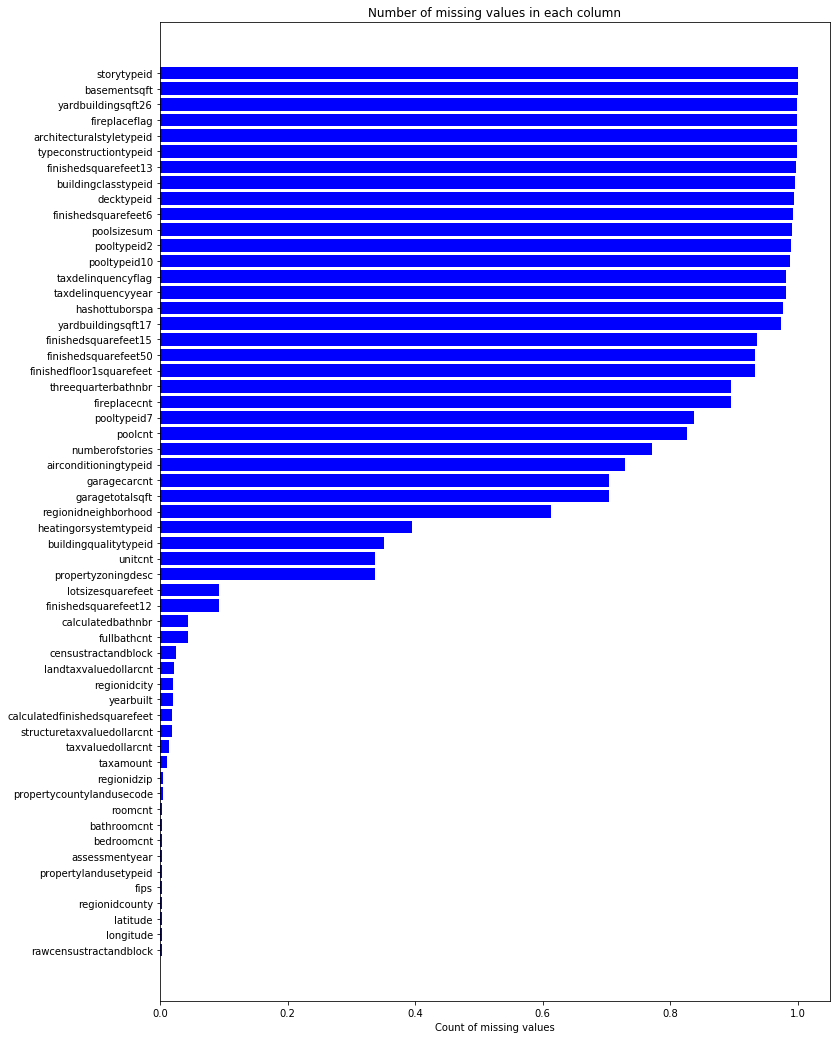

In [11]:
missing_2016_df = properties_2016_df.isnull().sum(axis=0).reset_index()
missing_2016_df.columns = ['column_name', 'missing_pct']
missing_2016_df = missing_2016_df.loc[missing_2016_df['missing_pct']>0]
missing_2016_df['missing_pct'] = missing_2016_df['missing_pct'] / length_properties_2016
missing_2016_df = missing_2016_df.sort_values(by='missing_pct')
ind = np.arange(missing_2016_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind, missing_2016_df.missing_pct.values, color='blue')
ax.set_yticks(ind)
ax.set_yticklabels(missing_2016_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")
plt.show()


In [13]:
m_2016 = properties_2016_df[np.isnan(properties_2016_df['propertylandusetypeid'])].shape[0]
m_2017 = properties_2017_df[np.isnan(properties_2017_df['propertylandusetypeid'])].shape[0]

logging.debug(m_2016)
logging.debug(m_2017)

DEBUG:root:11437
DEBUG:root:2932


In [14]:
length_features = properties_2016_df.shape[1]

gt9 = missing_2016_df[missing_2016_df['missing_pct'] > 0.9]
gt75 = missing_2016_df[missing_2016_df['missing_pct'] > 0.75]
gt5 = missing_2016_df[missing_2016_df['missing_pct'] > 0.5]

logging.debug("{} ({:0.2f}%) vars missing over 90%, {} ({:0.2f}%) vars over 75%, {} ({:0.2f}%) vars over 50%".format(gt9.shape[0], gt9.shape[0]/length_features*100, gt75.shape[0], gt75.shape[0]/length_features*100, gt5.shape[0], gt5.shape[0]/length_features*100))

DEBUG:root:20 (34.48%) vars missing over 90%, 25 (43.10%) vars over 75%, 29 (50.00%) vars over 50%


In [15]:
logging.debug(gt5)

DEBUG:root:                 column_name  missing_pct
38      regionidneighborhood     0.612624
21           garagetotalsqft     0.704120
20              garagecarcnt     0.704120
1      airconditioningtypeid     0.728154
48           numberofstories     0.771518
27                   poolcnt     0.826634
31               pooltypeid7     0.837379
18              fireplacecnt     0.895272
42       threequarterbathnbr     0.895609
10  finishedfloor1squarefeet     0.932093
15      finishedsquarefeet50     0.932093
14      finishedsquarefeet15     0.936086
45        yardbuildingsqft17     0.973082
22            hashottuborspa     0.976881
56        taxdelinquencyyear     0.981085
55        taxdelinquencyflag     0.981086
29              pooltypeid10     0.987626
30               pooltypeid2     0.989255
28               poolsizesum     0.990634
16       finishedsquarefeet6     0.992630
9                 decktypeid     0.994273
6        buildingclasstypeid     0.995769
13      finishedsquaref

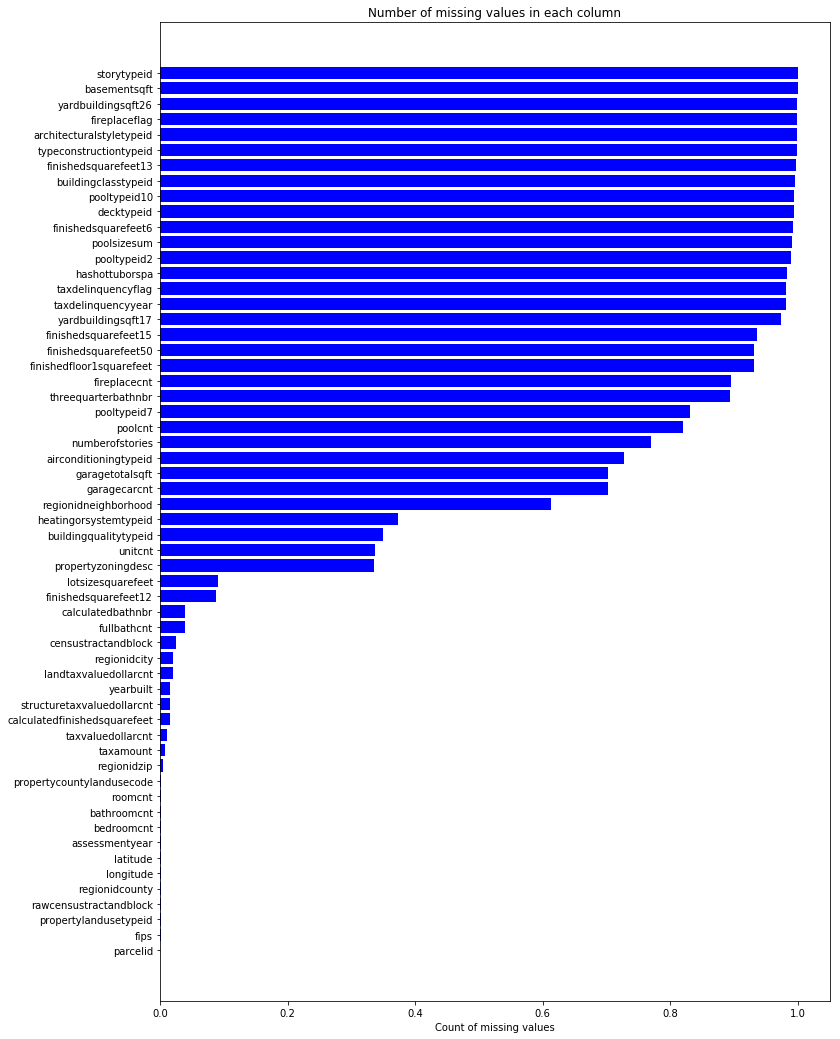

In [16]:
missing_2017_df = properties_2017_df.isnull().sum(axis=0).reset_index()
missing_2017_df.columns = ['column_name', 'missing_pct']
missing_2017_df = missing_2017_df.loc[missing_2017_df['missing_pct']>=0]
missing_2017_df['missing_pct'] = missing_2017_df['missing_pct'] / length_properties_2017
missing_2017_df = missing_2017_df.sort_values(by='missing_pct')
ind = np.arange(missing_2017_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind, missing_2017_df.missing_pct.values, color='blue')
ax.set_yticks(ind)
ax.set_yticklabels(missing_2017_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")
plt.show()


In [17]:
length_features = properties_2017_df.shape[1]

gt9 = missing_2017_df[missing_2017_df['missing_pct'] > 0.9]
gt75 = missing_2017_df[missing_2017_df['missing_pct'] > 0.75]
gt5 = missing_2017_df[missing_2017_df['missing_pct'] > 0.5]

logging.debug("{} ({:0.2f}%) vars missing over 90%, {} ({:0.2f}%) vars over 75%, {} ({:0.2f}%) vars over 50%".format(gt9.shape[0], gt9.shape[0]/length_features*100, gt75.shape[0], gt75.shape[0]/length_features*100, gt5.shape[0], gt5.shape[0]/length_features*100))

DEBUG:root:20 (34.48%) vars missing over 90%, 25 (43.10%) vars over 75%, 29 (50.00%) vars over 50%


In [18]:
logging.debug(gt5)

DEBUG:root:                 column_name  missing_pct
38      regionidneighborhood     0.612510
20              garagecarcnt     0.701527
21           garagetotalsqft     0.701527
1      airconditioningtypeid     0.726867
48           numberofstories     0.770309
27                   poolcnt     0.819232
31               pooltypeid7     0.830533
42       threequarterbathnbr     0.894025
18              fireplacecnt     0.895108
10  finishedfloor1squarefeet     0.931744
15      finishedsquarefeet50     0.931744
14      finishedsquarefeet15     0.936291
45        yardbuildingsqft17     0.972669
56        taxdelinquencyyear     0.981068
55        taxdelinquencyflag     0.981068
22            hashottuborspa     0.983230
30               pooltypeid2     0.988927
28               poolsizesum     0.990635
16       finishedsquarefeet6     0.992804
9                 decktypeid     0.994178
29              pooltypeid10     0.994303
6        buildingclasstypeid     0.995735
13      finishedsquaref

_Wow! Many of the features are pretty sparse. From the top (most sparse) we will determine if the feature is worth scrapping or not._

_First, the 'storytypeid'._

In [19]:
# take a look at the unique values for this variable
unique_vals = properties_2016_df['storytypeid'].unique()

logging.debug(unique_vals)

DEBUG:root:[ nan   7.]


_Let's see if this is the same for 2017._

In [20]:
unique_vals = properties_2017_df['storytypeid'].unique()

logging.debug(unique_vals)

DEBUG:root:[ nan   7.]


_Zillow lists a whopping 35 categories for this feature, but in both datasets only one type is even labelled. Interestingly, type 7 corresponds to "Basement" which may be relevant for our next variable. We could possibly infer some of them from other variables such as 'numberofstories', but that seems too tedious and would still be a lot of guessing, so we'll just remove this feature from both sets._

In [21]:
dummy_2016['storytypeid'] = properties_2016_df['storytypeid']
dummy_2017['storytypeid'] = properties_2017_df['storytypeid']

del properties_2016_df['storytypeid']
del properties_2017_df['storytypeid']

_Now, 'basementsqft'. A quick google search of "percent of southern california homes with basements" yields the following article ["Why basements are scarce in Southern California"](http://www.latimes.com/home/la-hm-basement-side-20150509-story.html). So apparently they are just really rare so the square foot measure doesn't really apply to most homes. But, I think we can compare apples to apples by replacing all of those missing values with 0 because isn't having a finished basement of 0 sqft the same as having no basement at all?_

In [22]:
dummy_2016['basementsqft'] = properties_2016_df['basementsqft']
dummy_2017['basementsqft'] = properties_2017_df['basementsqft']

properties_2016_df['basementsqft'] = properties_2016_df['basementsqft'].fillna(0)
properties_2017_df['basementsqft'] = properties_2017_df['basementsqft'].fillna(0)

_Moving right along to 'yardbuildingsqft26'. The term dictionary gives this description: "Storage shed/building in yard". So, I think we can make the same assumption as we did for the 'basementsqft'. No shed equals 0 square footage._

In [23]:
dummy_2016['yardbuildingsqft26'] = properties_2016_df['yardbuildingsqft26']
dummy_2017['yardbuildingsqft26'] = properties_2017_df['yardbuildingsqft26']

properties_2016_df['yardbuildingsqft26'] = properties_2016_df['yardbuildingsqft26'].fillna(0)
properties_2017_df['yardbuildingsqft26'] = properties_2017_df['yardbuildingsqft26'].fillna(0)

_No need to slow down now! Right on to 'fireplaceflag'. Now right off the bat, I know that this one is superfluous. There is another variable 'fireplacecnt' that will have this same information AND MORE. Let's scrap this one._

In [24]:
dummy_2016['fireplaceflag'] = properties_2016_df['fireplaceflag']
dummy_2017['fireplaceflag'] = properties_2017_df['fireplaceflag']

del properties_2016_df['fireplaceflag']
del properties_2017_df['fireplaceflag']

_Let's tackle one more and then see where we stand. Next is 'architecturalstyletypeid'. We'll start how we did with 'storytypeid' and see what we see._

In [25]:
# take a look at the unique values for this variable
unique_vals = properties_2016_df['architecturalstyletypeid'].unique()

logging.debug(unique_vals)

DEBUG:root:[ nan   7.  21.   8.   2.   3.   5.  10.  27.]


In [26]:
unique_vals = properties_2017_df['architecturalstyletypeid'].unique()

logging.debug(unique_vals)

DEBUG:root:[ nan   7.  21.   8.   2.   3.   5.  10.  27.]


_This one is a bit more tricky... Let's look at the distribution to get a better idea._

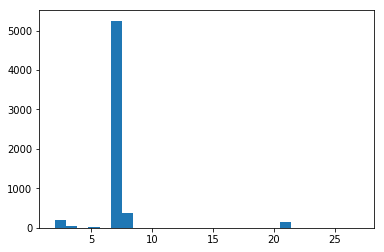

In [27]:
vals = properties_2016_df[np.isfinite(properties_2016_df['architecturalstyletypeid'])].architecturalstyletypeid.values

plt.close()
plt.hist(vals, bins=27)
plt.show()

_So we have a lot of 7's (contemporary), and a smattering of 2's (bungalow), 8's (conventional), and 21's (ranch/rambler). We'll have to be predicting logerrors for a lot of houses, and I can't imagine this variable being the deciding factor. We'll delete for now, but we may revisit this one later._

In [28]:
dummy_2016['architecturalstyletypeid'] = properties_2016_df['architecturalstyletypeid']
dummy_2017['architecturalstyletypeid'] = properties_2017_df['architecturalstyletypeid']

del properties_2016_df['architecturalstyletypeid']
del properties_2017_df['architecturalstyletypeid']

_Ok. Let's take stock of where we stand._

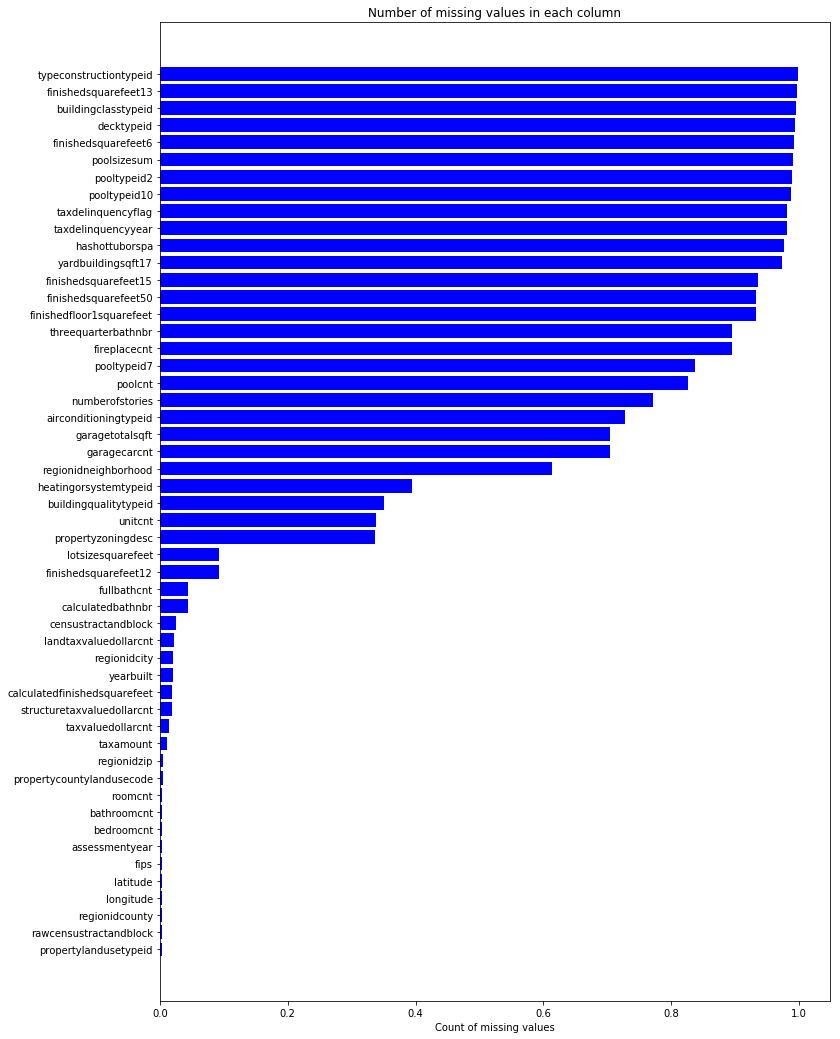

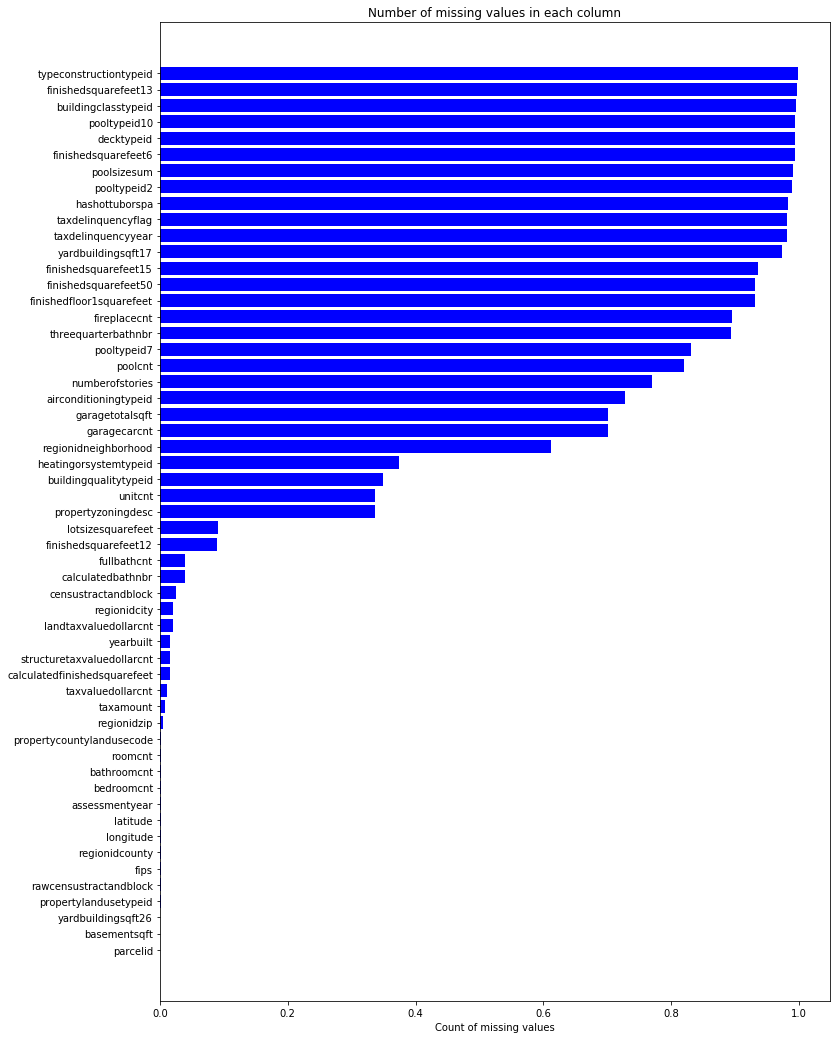

In [30]:
missing_2016_df = properties_2016_df.isnull().sum(axis=0).reset_index()
missing_2016_df.columns = ['column_name', 'missing_pct']
missing_2016_df = missing_2016_df.loc[missing_2016_df['missing_pct']>0]
missing_2016_df['missing_pct'] = missing_2016_df['missing_pct'] / length_properties_2016
missing_2016_df = missing_2016_df.sort_values(by='missing_pct')
ind = np.arange(missing_2016_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind, missing_2016_df.missing_pct.values, color='blue')
ax.set_yticks(ind)
ax.set_yticklabels(missing_2016_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")
plt.show()

missing_2017_df = properties_2017_df.isnull().sum(axis=0).reset_index()
missing_2017_df.columns = ['column_name', 'missing_pct']
missing_2017_df = missing_2017_df.loc[missing_2017_df['missing_pct']>=0]
missing_2017_df['missing_pct'] = missing_2017_df['missing_pct'] / length_properties_2017
missing_2017_df = missing_2017_df.sort_values(by='missing_pct')
ind = np.arange(missing_2017_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind, missing_2017_df.missing_pct.values, color='blue')
ax.set_yticks(ind)
ax.set_yticklabels(missing_2017_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")
plt.show()


In [31]:
length_features = properties_2017_df.shape[1]

gt9 = missing_2017_df[missing_2017_df['missing_pct'] > 0.9]
gt75 = missing_2017_df[missing_2017_df['missing_pct'] > 0.75]
gt5 = missing_2017_df[missing_2017_df['missing_pct'] > 0.5]

logging.debug("{} ({:0.2f}%) vars missing over 90%, {} ({:0.2f}%) vars over 75%, {} ({:0.2f}%) vars over 50%".format(gt9.shape[0], gt9.shape[0]/length_features*100, gt75.shape[0], gt75.shape[0]/length_features*100, gt5.shape[0], gt5.shape[0]/length_features*100))

DEBUG:root:15 (27.27%) vars missing over 90%, 20 (36.36%) vars over 75%, 24 (43.64%) vars over 50%


In [32]:
logging.debug(gt5)

DEBUG:root:                 column_name  missing_pct
37      regionidneighborhood     0.612510
19              garagecarcnt     0.701527
20           garagetotalsqft     0.701527
1      airconditioningtypeid     0.726867
46           numberofstories     0.770309
26                   poolcnt     0.819232
30               pooltypeid7     0.830533
40       threequarterbathnbr     0.894025
17              fireplacecnt     0.895108
9   finishedfloor1squarefeet     0.931744
14      finishedsquarefeet50     0.931744
13      finishedsquarefeet15     0.936291
43        yardbuildingsqft17     0.972669
53        taxdelinquencyyear     0.981068
52        taxdelinquencyflag     0.981068
21            hashottuborspa     0.983230
29               pooltypeid2     0.988927
27               poolsizesum     0.990635
15       finishedsquarefeet6     0.992804
8                 decktypeid     0.994178
28              pooltypeid10     0.994303
5        buildingclasstypeid     0.995735
12      finishedsquaref

_REMEMBER: IT'S ALWAYS IMPORTANT TO SAVE YOUR WORK SO LET'S WRITE OUT THIS DATASET TO A NEW FILE_

In [33]:
properties_2016_df.to_csv("Input/properties_2016_mod.csv", sep=',', encoding='utf-8', index=False)
properties_2017_df.to_csv("Input/properties_2017_mod.csv", sep=',', encoding='utf-8', index=False)

_Alrighty. Our new target is 'typeconstructiontypeid'. Wow! What a name! Let's see what it holds._

In [34]:
# take a look at the unique values for this variable
unique_vals = properties_2016_df['typeconstructiontypeid'].unique()

logging.debug(unique_vals)

DEBUG:root:[ nan   6.   4.  10.  13.  11.]


In [35]:
unique_vals = properties_2017_df['typeconstructiontypeid'].unique()

logging.debug(unique_vals)

DEBUG:root:[ nan   6.   4.  10.  13.  11.]


_Perhaps a glance at the distribution?_

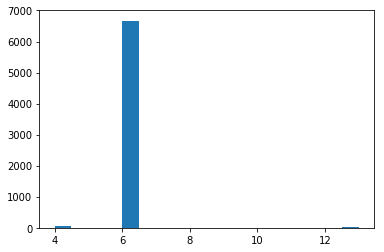

In [36]:
vals = properties_2016_df[np.isfinite(properties_2016_df['typeconstructiontypeid'])].typeconstructiontypeid.values

plt.close()
plt.hist(vals, bins=18)
plt.show()

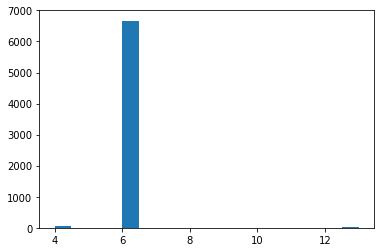

In [37]:
vals = properties_2017_df[np.isfinite(properties_2017_df['typeconstructiontypeid'])].typeconstructiontypeid.values

plt.close()
plt.hist(vals, bins=18)
plt.show()

_So one is far and away the leader (even more so than 'architecturalstyletypeid'). Most interpolation methods would continue to skew this so much more as to wash out any information. Besides, how savvy must a homebuyer be to be scrutinizing this feature? REMOVE._

In [38]:
dummy_2016['typeconstructiontypeid'] = properties_2016_df['typeconstructiontypeid']
dummy_2017['typeconstructiontypeid'] = properties_2017_df['typeconstructiontypeid']

del properties_2016_df['typeconstructiontypeid']
del properties_2017_df['typeconstructiontypeid']

_'finishedsquarefeet13'? Oh, "Perimeter  living area". Of course! Wait... What? Living area on the perimeter? Perimeter of the house? PERIMETER OF THE ROOMS?? We could do a bunch of guess-and-checks to try and find out. But honestly, only geeky engineering folks would even consider calculating perimeter of anything when buying a house. Real folks only care about number of rooms and sqare footage. Delete!_

In [39]:
dummy_2016['finishedsquarefeet13'] = properties_2016_df['finishedsquarefeet13']
dummy_2017['finishedsquarefeet13'] = properties_2017_df['finishedsquarefeet13']

del properties_2016_df['finishedsquarefeet13']
del properties_2017_df['finishedsquarefeet13']

_Cool! We're all the way to 'buildingclasstypeid'. Let's have a look into this category._

In [40]:
# take a look at the unique values for this variable
unique_vals = properties_2016_df['buildingclasstypeid'].unique()

logging.debug(unique_vals)

DEBUG:root:[ nan   3.   4.   5.   2.   1.]


In [41]:
unique_vals = properties_2017_df['buildingclasstypeid'].unique()

logging.debug(unique_vals)

DEBUG:root:[ nan   5.   3.   4.   2.   1.]


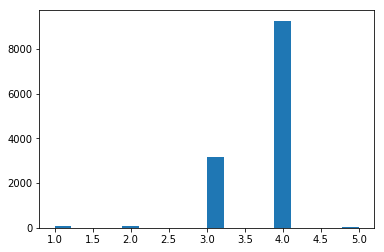

In [42]:
vals = properties_2016_df[np.isfinite(properties_2016_df['buildingclasstypeid'])].buildingclasstypeid.values

plt.close()
plt.hist(vals, bins=18)
plt.show()

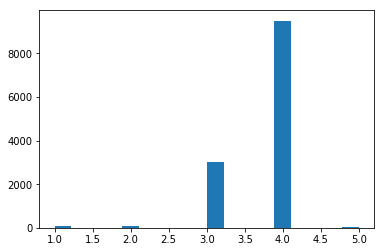

In [43]:
vals = properties_2017_df[np.isfinite(properties_2017_df['buildingclasstypeid'])].buildingclasstypeid.values

plt.close()
plt.hist(vals, bins=18)
plt.show()

_This variable seems to deal with some sort of fireproofing. 1 being the most fireproofed to 4 being the least. 5 is custom. This is a scale though WHICH IS GREAT! Data scientists (or at least I) prefer ordinal variables to strict categorical ones. An easy way to handle this var will be to transfrom 5 => 0 and nan => 5. That way we maintain the spirit of the scale._

In [44]:
dummy_2016['buildingclasstypeid'] = properties_2016_df['buildingclasstypeid']
dummy_2017['buildingclasstypeid'] = properties_2017_df['buildingclasstypeid']

properties_2016_df['buildingclasstypeid'] = properties_2016_df['buildingclasstypeid'].replace(to_replace=[5.0], value=0.0)
properties_2017_df['buildingclasstypeid'] = properties_2017_df['buildingclasstypeid'].replace(to_replace=[5.0], value=0.0)

In [45]:
properties_2016_df['buildingclasstypeid'] = properties_2016_df['buildingclasstypeid'].fillna(5.0)
properties_2017_df['buildingclasstypeid'] = properties_2017_df['buildingclasstypeid'].fillna(5.0)

_MOVING ALONG TO 'decktypeid'._

In [46]:
# take a look at the unique values for this variable
unique_vals = properties_2016_df['decktypeid'].unique()

logging.debug(unique_vals)

DEBUG:root:[ nan  66.]


In [47]:
unique_vals = properties_2017_df['decktypeid'].unique()

logging.debug(unique_vals)

DEBUG:root:[ nan  66.]


_Not a whole lot of information; the dataset doesn't even tell us how many types there may be or any other attributes. Now a quick web search yields one quote that states that decks can add 100% of THEIR cost to the value of a house. That is in the ballpark of 10s to Teens of thousands of dollars. However, we will scrap this one for now and hope that the 'yardbuildingsqft17' variable about patios will give us enough information._

In [48]:
dummy_2016['decktypeid'] = properties_2016_df['decktypeid']
dummy_2017['decktypeid'] = properties_2017_df['decktypeid']

del properties_2016_df['decktypeid']
del properties_2017_df['decktypeid']

_Time to look at our progress again!_

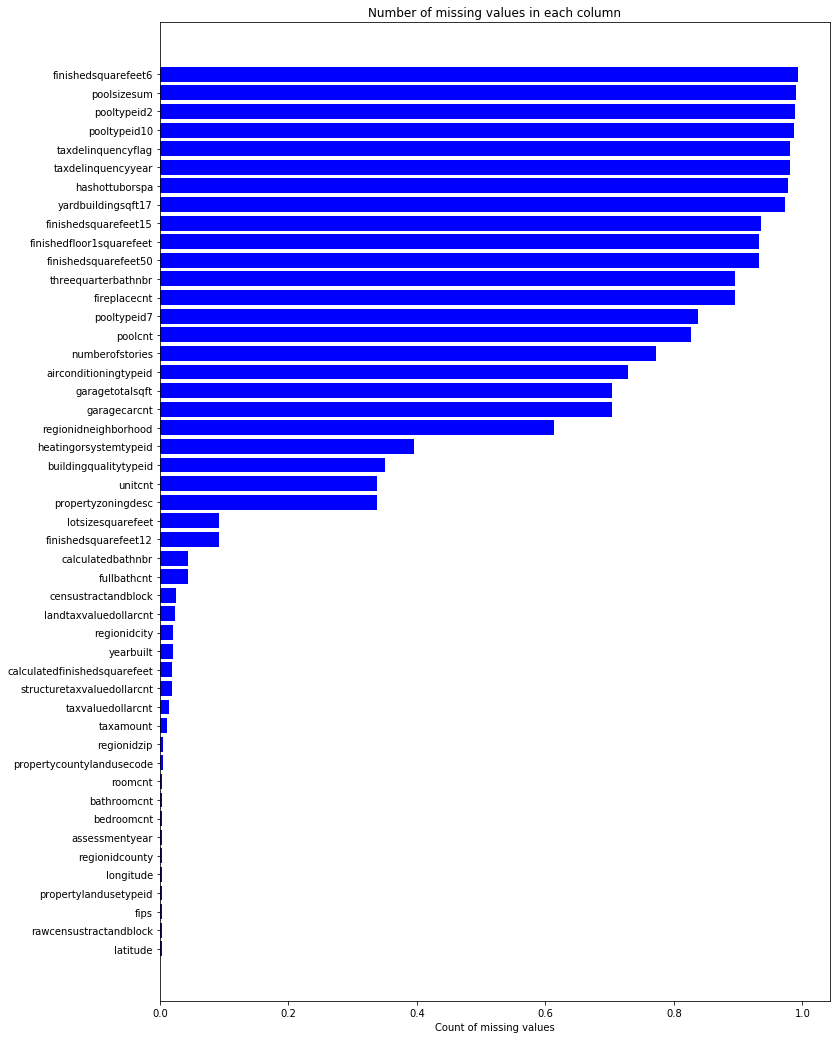

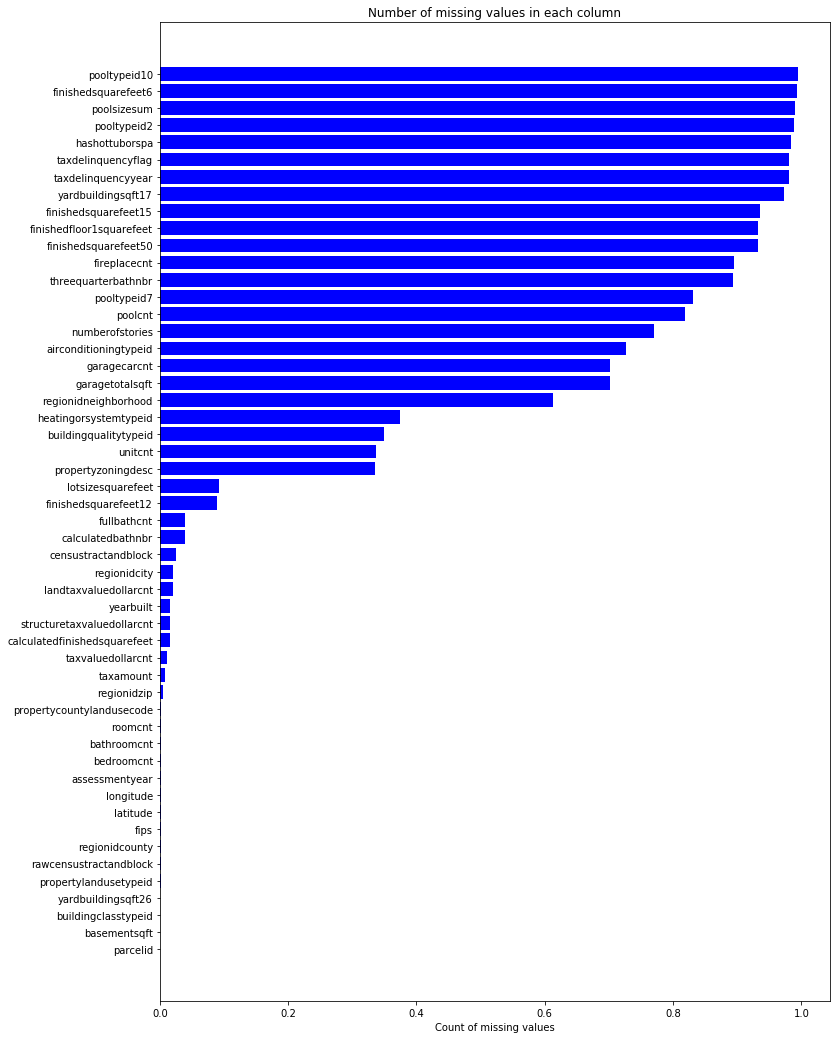

In [49]:
missing_2016_df = properties_2016_df.isnull().sum(axis=0).reset_index()
missing_2016_df.columns = ['column_name', 'missing_pct']
missing_2016_df = missing_2016_df.loc[missing_2016_df['missing_pct']>0]
missing_2016_df['missing_pct'] = missing_2016_df['missing_pct'] / length_properties_2016
missing_2016_df = missing_2016_df.sort_values(by='missing_pct')
ind = np.arange(missing_2016_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind, missing_2016_df.missing_pct.values, color='blue')
ax.set_yticks(ind)
ax.set_yticklabels(missing_2016_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")
plt.show()

missing_2017_df = properties_2017_df.isnull().sum(axis=0).reset_index()
missing_2017_df.columns = ['column_name', 'missing_pct']
missing_2017_df = missing_2017_df.loc[missing_2017_df['missing_pct']>=0]
missing_2017_df['missing_pct'] = missing_2017_df['missing_pct'] / length_properties_2017
missing_2017_df = missing_2017_df.sort_values(by='missing_pct')
ind = np.arange(missing_2017_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind, missing_2017_df.missing_pct.values, color='blue')
ax.set_yticks(ind)
ax.set_yticklabels(missing_2017_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")
plt.show()



_YOU HAVE REACHED THE NEXT SAVE POINT!_

In [ ]:
properties_2016_df.to_csv("Input/properties_2016_mod.csv", sep=',', encoding='utf-8', index=False)
properties_2017_df.to_csv("Input/properties_2017_mod.csv", sep=',', encoding='utf-8', index=False)

In [ ]:
logging.debug("READING IN 2016 PROPERTIES...")
properties_2016_df = pd.read_csv("Input/properties_2016_mod.csv")

logging.debug("READING IN 2017 PROPERTIES...")
properties_2017_df = pd.read_csv("Input/properties_2017_mod.csv")


_Another weirdly-named variable: 'finishedsquarefeet6'. The dictionary tells us that it means "Base unfinished and finished area". Interesting. Let's see if we can do some interpolation with the 'finishedsquarefeet12' variable or "Finished living area"._

In [50]:
overlap_2017 = properties_2017_df[(properties_2017_df['finishedsquarefeet6'] > 0) & (properties_2017_df['finishedsquarefeet12'] > 0)].parcelid.values
logging.debug(overlap_2017)

overlap_2016 = properties_2016_df[(properties_2016_df['finishedsquarefeet6'] > 0) & (properties_2016_df['finishedsquarefeet12'] > 0)].parcelid.values
logging.debug(overlap_2017)


DEBUG:root:[]
DEBUG:root:[]


_No overlap?? Interesting! Let's dig deeper._

In [51]:
finished_2017 = properties_2017_df[properties_2017_df['finishedsquarefeet12'] > 0].parcelid.values
length_finished_2017 = finished_2017.shape[0]

finandun_2017 = properties_2017_df[properties_2017_df['finishedsquarefeet6'] > 0].parcelid.values
length_finandun_2017 = finandun_2017.shape[0]

logging.debug("{} finished values, {} combined valued, {} total values, {} unaccounted".format(length_finished_2017, length_finandun_2017, length_finished_2017+length_finandun_2017, length_properties_2017-length_finished_2017-length_finandun_2017))

DEBUG:root:2720786 finished values, 21482 combined valued, 2742268 total values, 242949 unaccounted


In [52]:
finished_2016 = properties_2016_df[properties_2016_df['finishedsquarefeet12'] > 0].parcelid.values
length_finished_2016 = finished_2016.shape[0]

finandun_2016 = properties_2016_df[properties_2016_df['finishedsquarefeet6'] > 0].parcelid.values
length_finandun_2016 = finandun_2016.shape[0]

logging.debug("{} finished values, {} combined valued, {} total values, {} unaccounted".format(length_finished_2016, length_finandun_2016, length_finished_2016+length_finandun_2016, length_properties_2016-length_finished_2016-length_finandun_2016))

DEBUG:root:2709184 finished values, 22001 combined valued, 2731185 total values, 254032 unaccounted


_This variable is being a little finicky. We are going to LEAVE it for now and will come back to it._

_Also, believe it or not but I have also just wasted a lot of time trying to play nice with the pool variables and find out what they all mean.... No more. I'm moving past those and will handle them LAST._

_That means our next feature is 'taxdelinquencyflag', and we might as well handle 'taxdelinquencyyear' while we're at it! We will fill in 0's for the 'taxdelinquencyflag' and convert 'taxdelinquencyyear' to 'yearssincedelinquent' using 2018 as our anchor year._

In [55]:
properties_2017_df['taxdelinquencyflag'] = properties_2017_df['taxdelinquencyflag'].replace(to_replace=['Y'], value=1.0)
properties_2016_df['taxdelinquencyflag'] = properties_2016_df['taxdelinquencyflag'].replace(to_replace=['Y'], value=1.0)

In [56]:
u1 = properties_2016_df['taxdelinquencyflag'].unique()
u2 = properties_2017_df['taxdelinquencyflag'].unique()

logging.debug(u1)
logging.debug(u2)

DEBUG:root:[ nan   1.]
DEBUG:root:[ nan   1.]


In [57]:
properties_2017_df['taxdelinquencyflag'] = properties_2017_df['taxdelinquencyflag'].fillna(0)
properties_2016_df['taxdelinquencyflag'] = properties_2016_df['taxdelinquencyflag'].fillna(0)

In [58]:
unique = properties_2017_df['taxdelinquencyyear'].unique()
logging.debug(unique)

DEBUG:root:[ nan  13.  15.  11.  14.   9.  10.   8.  12.   7.   6.   2.  92.   5.   3.
   4.  95.  91.  93.  98.  82.  79.  94.  97.  90.  99.   0.   1.  87.  84.
  88.  96.]


_Great... So the values are only the last two digits and they span 1900 and 2000's. Y2K strikes again! We should go ahead and make them 4 digit values before contining._

In [59]:
properties_2017_df.loc[properties_2017_df['taxdelinquencyyear'] >= 20, 'taxdelinquencyyear'] += 1900
properties_2017_df.loc[properties_2017_df['taxdelinquencyyear'] < 20, 'taxdelinquencyyear'] += 2000

In [60]:
properties_2016_df.loc[properties_2016_df['taxdelinquencyyear'] >= 20, 'taxdelinquencyyear'] += 1900
properties_2016_df.loc[properties_2016_df['taxdelinquencyyear'] < 20, 'taxdelinquencyyear'] += 2000

In [61]:
unique = properties_2017_df['taxdelinquencyyear'].unique()
logging.debug(unique)

DEBUG:root:[   nan  2013.  2015.  2011.  2014.  2009.  2010.  2008.  2012.  2007.
  2006.  2002.  1992.  2005.  2003.  2004.  1995.  1991.  1993.  1998.
  1982.  1979.  1994.  1997.  1990.  1999.  2000.  2001.  1987.  1984.
  1988.  1996.]


In [62]:
properties_2017_df['taxdelinquencyyear'] = properties_2017_df['taxdelinquencyyear'].fillna(2017)
properties_2016_df['taxdelinquencyyear'] = properties_2016_df['taxdelinquencyyear'].fillna(2016)

properties_2017_df['yearssincedelinquent'] = 2017 - properties_2017_df['taxdelinquencyyear']
properties_2016_df['yearssincedelinquent'] = 2016 - properties_2016_df['taxdelinquencyyear']

In [63]:
unique = properties_2017_df['yearssincedelinquent'].unique()
logging.debug(unique)

DEBUG:root:[  0.   4.   2.   6.   3.   8.   7.   9.   5.  10.  11.  15.  25.  12.  14.
  13.  22.  26.  24.  19.  35.  38.  23.  20.  27.  18.  17.  16.  30.  33.
  29.  21.]


In [64]:
del properties_2016_df['taxdelinquencyyear']
del properties_2017_df['taxdelinquencyyear']

_Great! So let's move onto 'yardbuildingsqft17' which is the patio variable. Again, we'll just fill those na's with 0_

In [65]:
properties_2017_df['yardbuildingsqft17'] = properties_2017_df['yardbuildingsqft17'].fillna(0)
properties_2016_df['yardbuildingsqft17'] = properties_2016_df['yardbuildingsqft17'].fillna(0)

_These last few vars have really been pretty tough (a lot more work was done than what made it in the notebook). Let's take another look at our progress and save the data again._

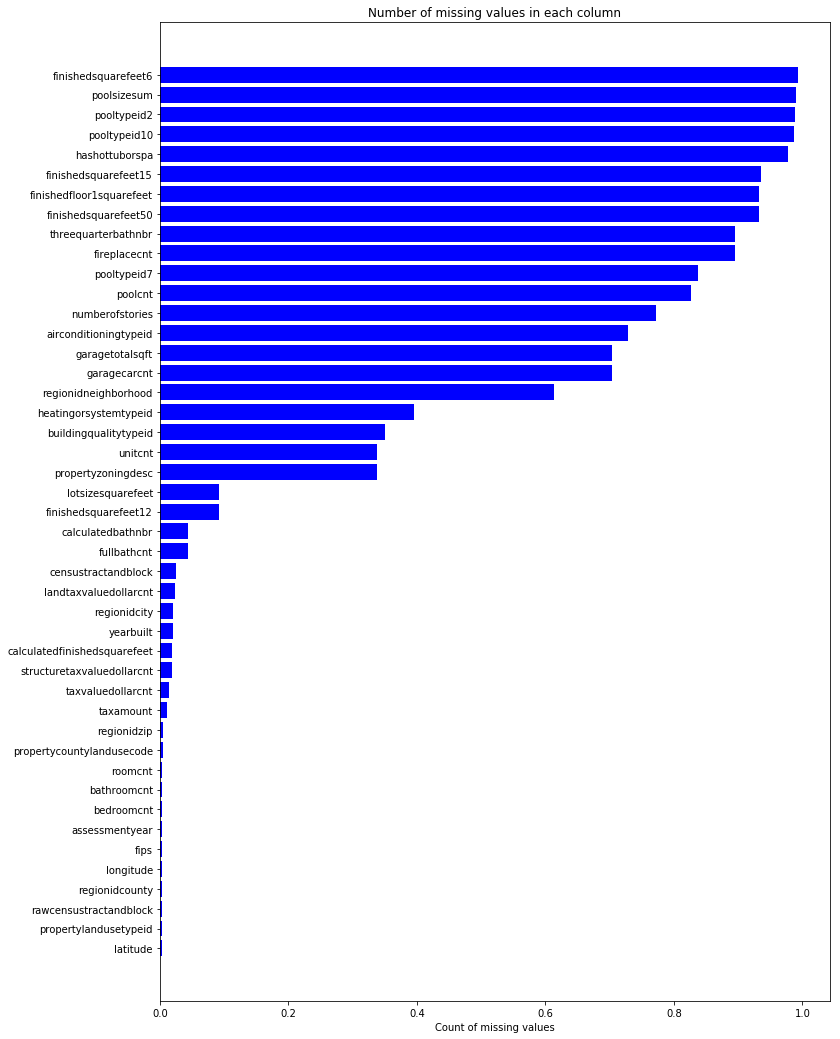

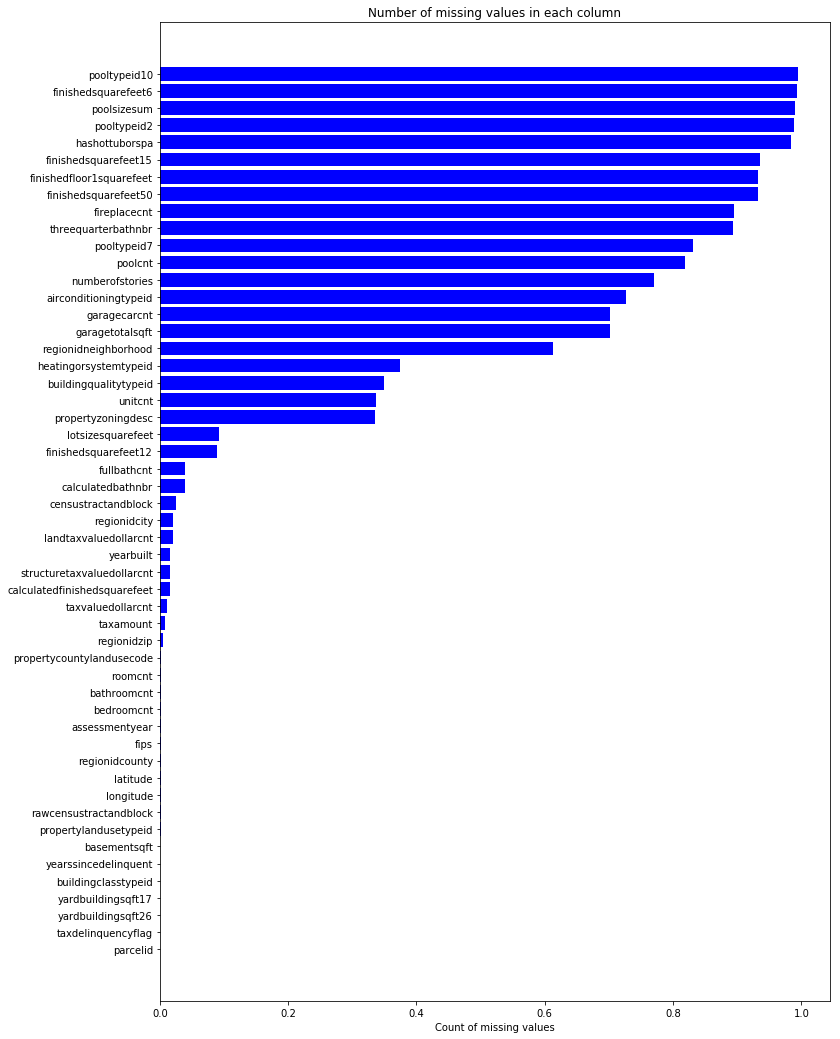

In [66]:
missing_2016_df = properties_2016_df.isnull().sum(axis=0).reset_index()
missing_2016_df.columns = ['column_name', 'missing_pct']
missing_2016_df = missing_2016_df.loc[missing_2016_df['missing_pct']>0]
missing_2016_df['missing_pct'] = missing_2016_df['missing_pct'] / length_properties_2016
missing_2016_df = missing_2016_df.sort_values(by='missing_pct')
ind = np.arange(missing_2016_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind, missing_2016_df.missing_pct.values, color='blue')
ax.set_yticks(ind)
ax.set_yticklabels(missing_2016_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")
plt.show()

missing_2017_df = properties_2017_df.isnull().sum(axis=0).reset_index()
missing_2017_df.columns = ['column_name', 'missing_pct']
missing_2017_df = missing_2017_df.loc[missing_2017_df['missing_pct']>=0]
missing_2017_df['missing_pct'] = missing_2017_df['missing_pct'] / length_properties_2017
missing_2017_df = missing_2017_df.sort_values(by='missing_pct')
ind = np.arange(missing_2017_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind, missing_2017_df.missing_pct.values, color='blue')
ax.set_yticks(ind)
ax.set_yticklabels(missing_2017_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")
plt.show()




In [ ]:
properties_2016_df.to_csv("Input/properties_2016_mod.csv", sep=',', encoding='utf-8', index=False)
properties_2017_df.to_csv("Input/properties_2017_mod.csv", sep=',', encoding='utf-8', index=False)

In [ ]:
logging.debug("READING IN 2016 PROPERTIES...")
properties_2016_df = pd.read_csv("Input/properties_2016_mod.csv")

logging.debug("READING IN 2017 PROPERTIES...")
properties_2017_df = pd.read_csv("Input/properties_2017_mod.csv")


_Ok so we're making good progress. Looks like we have some square footage variables coming up, but like the pool variables we'll skip these for now and pick off some easier ones. That puts us all the way down at 'fireplacecnt'._

In [68]:
unique = properties_2017_df['fireplacecnt'].unique()

logging.debug(unique)
unique = properties_2016_df['fireplacecnt'].unique()

logging.debug(unique)

DEBUG:root:[ nan   3.   1.   2.   4.   9.   5.   7.   6.   8.]
DEBUG:root:[ nan   3.   1.   2.   4.   9.   5.   7.   6.   8.]


_Yep. Easy enough. We'll assume those na's are 0's._

In [69]:
properties_2017_df['fireplacecnt'] = properties_2017_df['fireplacecnt'].fillna(0)
properties_2016_df['fireplacecnt'] = properties_2016_df['fireplacecnt'].fillna(0)

_Now we have 'threequarterbathnbr'. Let's check it out._

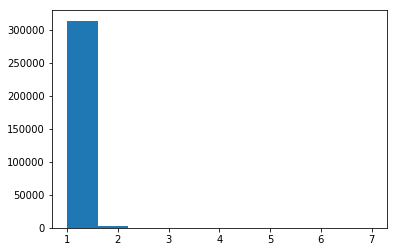

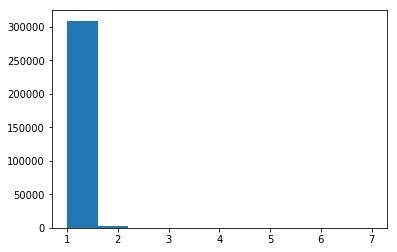

In [70]:
vals = properties_2017_df[np.isfinite(properties_2017_df['threequarterbathnbr'])].threequarterbathnbr.values

plt.close()
plt.hist(vals)
plt.show()

vals = properties_2016_df[np.isfinite(properties_2016_df['threequarterbathnbr'])].threequarterbathnbr.values

plt.close()
plt.hist(vals)
plt.show()

_Yea... One maybe two for very few houses. The rest are most likely 0._

In [71]:
properties_2017_df['threequarterbathnbr'] = properties_2017_df['threequarterbathnbr'].fillna(0)
properties_2016_df['threequarterbathnbr'] = properties_2016_df['threequarterbathnbr'].fillna(0)

_Now, we're up to a few more pool variables, BUT THOSE DRIVE ME CRAZY! So let's hit up 'numberofstories'._

DEBUG:root:[ nan   1.   4.   2.   3.  41.   5.   6.  20.   7.  14.  17.   8.]


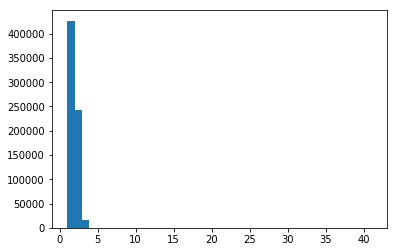

In [72]:
unique = properties_2017_df['numberofstories'].unique()

logging.debug(unique)

vals = properties_2017_df[np.isfinite(properties_2017_df['numberofstories'])].numberofstories.values

plt.close()
plt.hist(vals, bins=41)
plt.show()

_First of all, just wow... 41 stories?? Really? I bet the absolute logerror on that house is pretty high! Also, it's pretty incredible how many missing values there are for this. We could try to use the squarefootage values and try to make a best guess about whether a home has one or two stories. Perhaps the perimeter living area from earlier was a measurement of the house footprint, but it had too many missing values to be helpful. We'll com back to this one later too, unforunately._

_Let's try 'airconditioningtypeid'._

DEBUG:root:[  1.   3.   5.   9.  11.  12.  13.  nan]


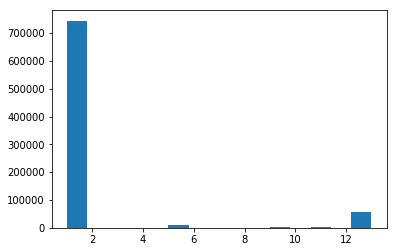

DEBUG:root:[  1.   3.   5.   9.  11.  12.  13.  nan]


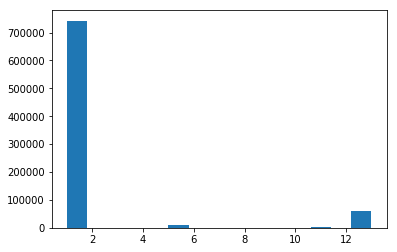

In [74]:
unique = properties_2017_df['airconditioningtypeid'].unique()
unique.sort()
logging.debug(unique)

vals = properties_2017_df[np.isfinite(properties_2017_df['airconditioningtypeid'])].airconditioningtypeid.values

plt.close()
plt.hist(vals, bins=15)
plt.show()

unique = properties_2016_df['airconditioningtypeid'].unique()
unique.sort()
logging.debug(unique)

vals = properties_2016_df[np.isfinite(properties_2016_df['airconditioningtypeid'])].airconditioningtypeid.values

plt.close()
plt.hist(vals, bins=15)
plt.show()

_For this variable we should look at how the distribution changes over time. That might give us insight as to how we could interpolate._

In [ ]:
unique = properties_2017_df['yearbuilt'].unique()
unique.sort()
logging.debug(unique)

vals = properties_2017_df[np.isfinite(properties_2017_df['yearbuilt'])].yearbuilt.values

plt.close()
plt.hist(vals, bins=15)
plt.show()

In [ ]:
unique = properties_2017_df.loc[properties_2017_df['yearbuilt'] < 1850, 'airconditioningtypeid'].unique()

logging.debug(unique)

vals = properties_2017_df[np.isfinite(properties_2017_df['airconditioningtypeid']) & (properties_2017_df['yearbuilt'] < 1850)].airconditioningtypeid.values

plt.close()
plt.hist(vals)
plt.show()

In [ ]:
unique = properties_2017_df.loc[(properties_2017_df['yearbuilt'] >= 1850) & (properties_2017_df['yearbuilt'] < 1900), 'airconditioningtypeid'].unique()
unique.sort()
logging.debug(unique)

vals = properties_2017_df[np.isfinite(properties_2017_df['airconditioningtypeid']) & (properties_2017_df['yearbuilt'] >= 1850) & (properties_2017_df['yearbuilt'] < 1900)].airconditioningtypeid.values

plt.close()
plt.hist(vals)
plt.show()

In [ ]:
unique = properties_2017_df.loc[(properties_2017_df['yearbuilt'] >= 1900) & (properties_2017_df['yearbuilt'] < 1950), 'airconditioningtypeid'].unique()
unique.sort()
logging.debug(unique)

vals = properties_2017_df[np.isfinite(properties_2017_df['airconditioningtypeid']) & (properties_2017_df['yearbuilt'] >= 1900) & (properties_2017_df['yearbuilt'] < 1950)].airconditioningtypeid.values

plt.close()
plt.hist(vals)
plt.show()

In [ ]:
unique = properties_2017_df.loc[(properties_2017_df['yearbuilt'] >= 1950) & (properties_2017_df['yearbuilt'] < 2000), 'airconditioningtypeid'].unique()
unique.sort()
logging.debug(unique)

vals = properties_2017_df[np.isfinite(properties_2017_df['airconditioningtypeid']) & (properties_2017_df['yearbuilt'] >= 1950) & (properties_2017_df['yearbuilt'] < 2000)].airconditioningtypeid.values

plt.close()
plt.hist(vals)
plt.show()

In [ ]:
unique = properties_2017_df.loc[(properties_2017_df['yearbuilt'] >= 2000) & (properties_2017_df['yearbuilt'] < 2050), 'airconditioningtypeid'].unique()
unique.sort()
logging.debug(unique)

vals = properties_2017_df[np.isfinite(properties_2017_df['airconditioningtypeid']) & (properties_2017_df['yearbuilt'] >= 2000) & (properties_2017_df['yearbuilt'] < 2050)].airconditioningtypeid.values

plt.close()
plt.hist(vals)
plt.show()

_Wow, so central air is far and away the winner and has been throughout the entire time period. So I will have create two categorical variables 'centralac' and 'otherac'. These will be flags that indicate which the house has and empty will represent unknown._

In [ ]:
# import pandas as pd

# # make a simple dataframe
# df = pd.DataFrame({'a':[1,2], 'b':[3,4]})
# df
# #    a  b
# # 0  1  3
# # 1  2  4

# # create an unattached column with an index
# df.apply(lambda row: row.a + row.b, axis=1)
# # 0    4
# # 1    6

# # do same but attach it to the dataframe
# df['c'] = df.apply(lambda row: row.a + row.b, axis=1)
# df
# #    a  b  c
# # 0  1  3  4
# # 1  2  4  6

In [75]:
properties_2017_df['centralac'] = properties_2017_df.apply(lambda row: 1 if row.airconditioningtypeid == 1 else 0, axis=1)
properties_2016_df['centralac'] = properties_2016_df.apply(lambda row: 1 if row.airconditioningtypeid == 1 else 0, axis=1)

properties_2017_df['otherac'] = properties_2017_df.apply(lambda row: 1 if row.airconditioningtypeid > 1 else 0, axis=1)
properties_2016_df['otherac'] = properties_2016_df.apply(lambda row: 1 if row.airconditioningtypeid > 1 else 0, axis=1)

In [77]:
temp1 = properties_2017_df[properties_2017_df['airconditioningtypeid'] == 1].shape[0]
temp2 = properties_2017_df[properties_2017_df['centralac'] == 1].shape[0]
logging.debug("{}, {}".format(temp1, temp2))

temp1 = properties_2016_df[properties_2016_df['airconditioningtypeid'] == 1].shape[0]
temp2 = properties_2016_df[properties_2016_df['centralac'] == 1].shape[0]
logging.debug("{}, {}".format(temp1, temp2))

DEBUG:root:744291, 744291
DEBUG:root:742364, 742364


In [78]:
del properties_2016_df['airconditioningtypeid']
del properties_2017_df['airconditioningtypeid']

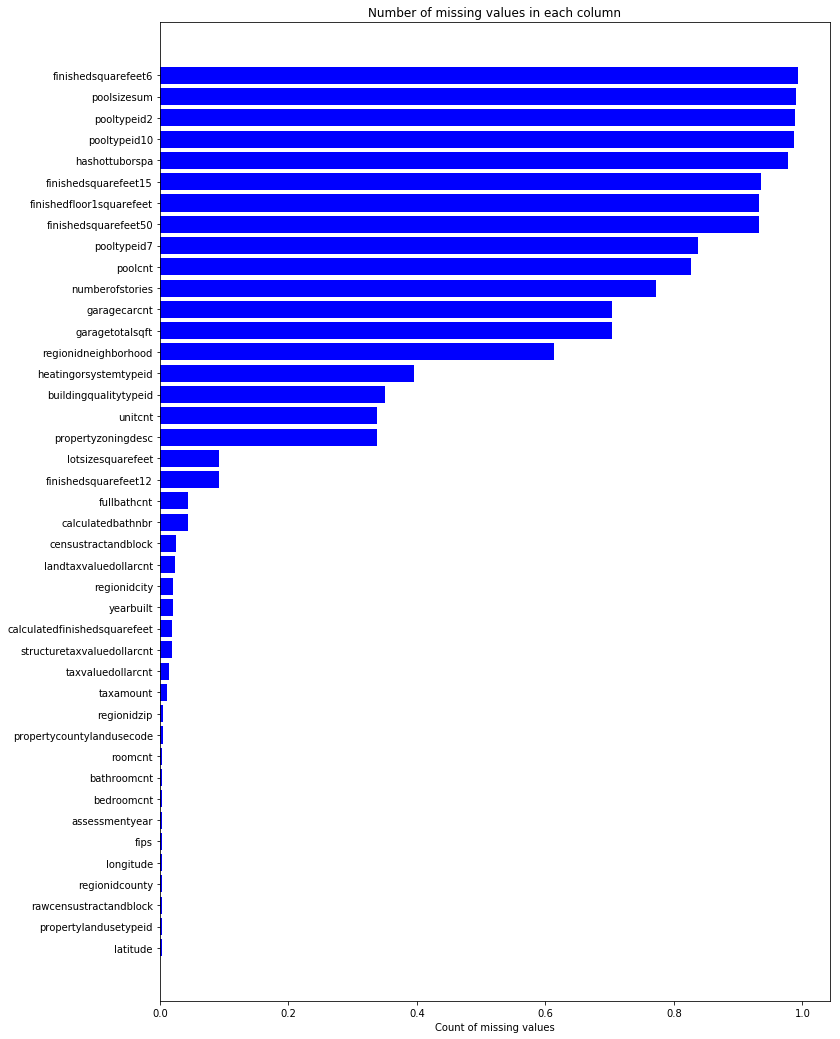

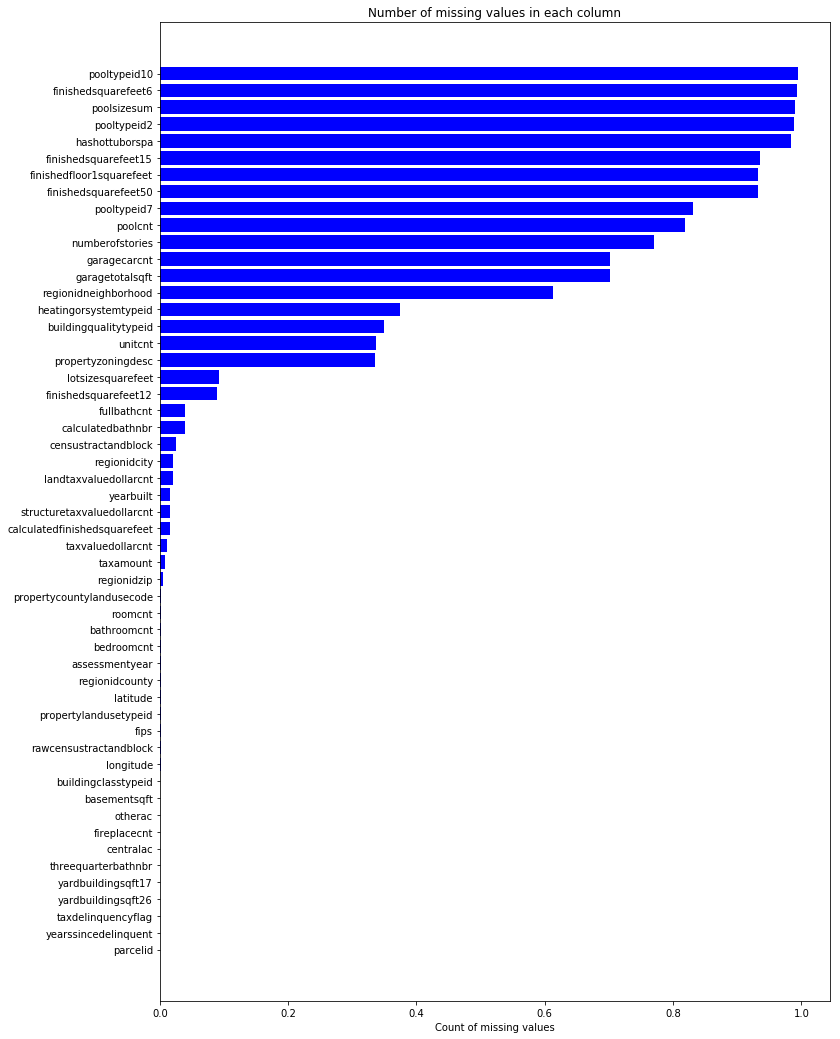

In [79]:
missing_2016_df = properties_2016_df.isnull().sum(axis=0).reset_index()
missing_2016_df.columns = ['column_name', 'missing_pct']
missing_2016_df = missing_2016_df.loc[missing_2016_df['missing_pct']>0]
missing_2016_df['missing_pct'] = missing_2016_df['missing_pct'] / length_properties_2016
missing_2016_df = missing_2016_df.sort_values(by='missing_pct')
ind = np.arange(missing_2016_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind, missing_2016_df.missing_pct.values, color='blue')
ax.set_yticks(ind)
ax.set_yticklabels(missing_2016_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")
plt.show()

missing_2017_df = properties_2017_df.isnull().sum(axis=0).reset_index()
missing_2017_df.columns = ['column_name', 'missing_pct']
missing_2017_df = missing_2017_df.loc[missing_2017_df['missing_pct']>=0]
missing_2017_df['missing_pct'] = missing_2017_df['missing_pct'] / length_properties_2017
missing_2017_df = missing_2017_df.sort_values(by='missing_pct')
ind = np.arange(missing_2017_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind, missing_2017_df.missing_pct.values, color='blue')
ax.set_yticks(ind)
ax.set_yticklabels(missing_2017_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")
plt.show()

In [ ]:
properties_2016_df.to_csv("Input/properties_2016_mod.csv", sep=',', encoding='utf-8', index=False)
properties_2017_df.to_csv("Input/properties_2017_mod.csv", sep=',', encoding='utf-8', index=False)

In [ ]:
logging.debug("READING IN 2016 PROPERTIES...")
properties_2016_df = pd.read_csv("Input/properties_2016_mod.csv")

logging.debug("READING IN 2017 PROPERTIES...")
properties_2017_df = pd.read_csv("Input/properties_2017_mod.csv")


_Now we will keep moving with the garage variables. 'garagetotalsqft' and 'garagecarcnt' are missing the same number of values. In such an urban area it is not impossible to image that houses without this information simply do not have garages, so we will fill them both with 0's._

In [80]:
properties_2017_df['garagetotalsqft'] = properties_2017_df['garagetotalsqft'].fillna(0)
properties_2016_df['garagetotalsqft'] = properties_2016_df['garagetotalsqft'].fillna(0)

properties_2017_df['garagecarcnt'] = properties_2017_df['garagecarcnt'].fillna(0)
properties_2016_df['garagecarcnt'] = properties_2016_df['garagecarcnt'].fillna(0)

_Great! So, now we are down to 'regionidneighborhood'. We can use 'latitude' and 'longitude' to find the nearest neighbor and use that value for interpolation. I found this code from [one of the kernels](https://www.kaggle.com/nikunjm88/carefully-dealing-with-missing-values) from the competition; they also reference [this kernel](https://www.kaggle.com/auroralht/restoring-the-missing-geo-data). The second link demonstrates that the neighborhood data would be very difficult to recover, but the information that does exist may be valuable, so we will keep it and fill in the rest of the entries with 0's again._

In [81]:
properties_2017_df['regionidneighborhood'] = properties_2017_df['regionidneighborhood'].fillna(0)
properties_2016_df['regionidneighborhood'] = properties_2016_df['regionidneighborhood'].fillna(0)

_That's it! We've plowed through all of the variables that are missing > 50% of their values (mostly). Let's keep pounding on the back nine._

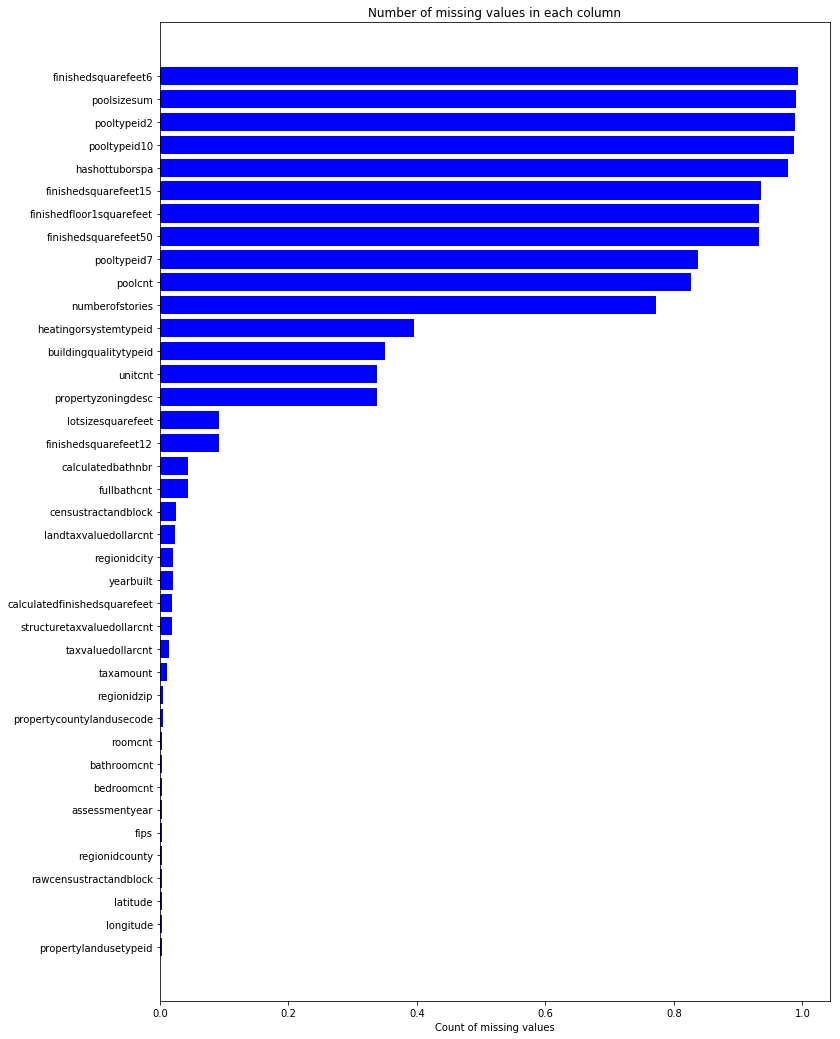

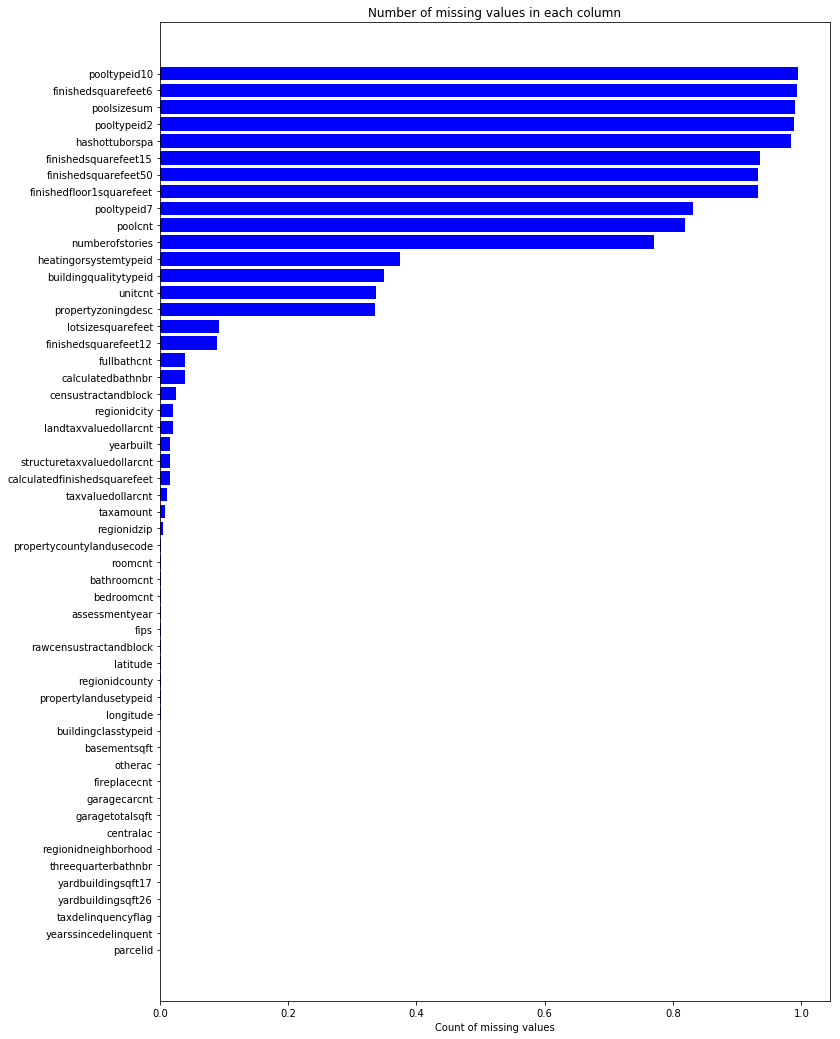

In [82]:
missing_2016_df = properties_2016_df.isnull().sum(axis=0).reset_index()
missing_2016_df.columns = ['column_name', 'missing_pct']
missing_2016_df = missing_2016_df.loc[missing_2016_df['missing_pct']>0]
missing_2016_df['missing_pct'] = missing_2016_df['missing_pct'] / length_properties_2016
missing_2016_df = missing_2016_df.sort_values(by='missing_pct')
ind = np.arange(missing_2016_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind, missing_2016_df.missing_pct.values, color='blue')
ax.set_yticks(ind)
ax.set_yticklabels(missing_2016_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")
plt.show()

missing_2017_df = properties_2017_df.isnull().sum(axis=0).reset_index()
missing_2017_df.columns = ['column_name', 'missing_pct']
missing_2017_df = missing_2017_df.loc[missing_2017_df['missing_pct']>=0]
missing_2017_df['missing_pct'] = missing_2017_df['missing_pct'] / length_properties_2017
missing_2017_df = missing_2017_df.sort_values(by='missing_pct')
ind = np.arange(missing_2017_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind, missing_2017_df.missing_pct.values, color='blue')
ax.set_yticks(ind)
ax.set_yticklabels(missing_2017_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")
plt.show()

_Now we will handle 'heatingorsystemtypeid'. First the values._

DEBUG:root:[  1.   2.   6.   7.  10.  11.  12.  13.  14.  18.  19.  20.  21.  24.  nan]


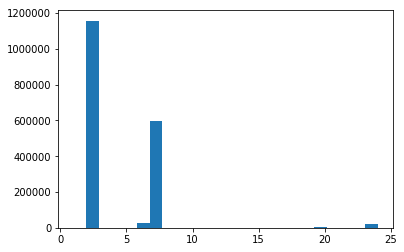

DEBUG:root:[  1.   2.   6.   7.  10.  11.  12.  13.  14.  18.  19.  20.  21.  24.  nan]


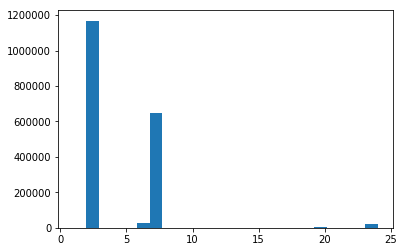

In [84]:
unique = properties_2016_df['heatingorsystemtypeid'].unique()
unique.sort()
logging.debug(unique)

values = properties_2016_df[np.isfinite(properties_2016_df['heatingorsystemtypeid'])].heatingorsystemtypeid.values

plt.close()
plt.hist(values, bins=24)
plt.show()

unique = properties_2017_df['heatingorsystemtypeid'].unique()
unique.sort()
logging.debug(unique)

values = properties_2017_df[np.isfinite(properties_2017_df['heatingorsystemtypeid'])].heatingorsystemtypeid.values

plt.close()
plt.hist(values, bins=24)
plt.show()

_Like the 'airconditioningtypeid' we should look at how the technology shifts over the years._

DEBUG:root:[ nan   7.   2.  20.   6.  13.  10.  18.  14.  24.]


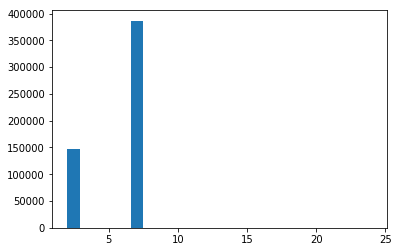

In [85]:
unique = properties_2017_df.loc[properties_2017_df['yearbuilt'] < 1950, 'heatingorsystemtypeid'].unique()

logging.debug(unique)

vals = properties_2017_df[np.isfinite(properties_2017_df['heatingorsystemtypeid']) & (properties_2017_df['yearbuilt'] < 1950)].heatingorsystemtypeid.values

plt.close()
plt.hist(vals, bins=24)
plt.show()

DEBUG:root:[ nan   2.   7.  20.   6.  13.  18.  24.  12.  10.   1.  14.  21.  11.  19.]


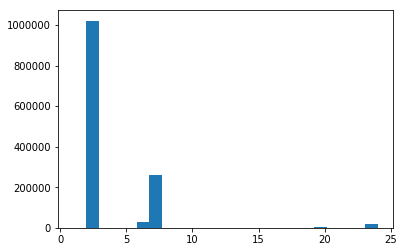

In [86]:
unique = properties_2017_df.loc[properties_2017_df['yearbuilt'] >= 1950, 'heatingorsystemtypeid'].unique()

logging.debug(unique)

vals = properties_2017_df[np.isfinite(properties_2017_df['heatingorsystemtypeid']) & (properties_2017_df['yearbuilt'] >= 1950)].heatingorsystemtypeid.values

plt.close()
plt.hist(vals, bins=24)
plt.show()

_After some exploration it seems like the easy interpolation will be that pre-1950 houses tend to be 7 (floor/wall) and post-1950 tend to be 2 (central). Again, we should create several categorical variables: 'centralheat', 'floorwallheat', and 'otherheat'. All properties will end up falling into one of these three categories._

In [87]:
def assigncentralheat(row):
    if row['heatingorsystemtypeid'] == 2:
        return 1
    else:
        if np.isnan(row['heatingorsystemtypeid']):
            if row['yearbuilt'] >= 1950:
                return 1
            else:
                return 0

def assignfloorwallheat(row):
    if row['heatingorsystemtypeid'] == 7:
        return 1
    else:
        if np.isnan(row['heatingorsystemtypeid']):
            if row['yearbuilt'] < 1950:
                return 1
            else:
                return 0
            
def assignotherheat(row):
    if np.isfinite(row['heatingorsystemtypeid']):
        if row['heatingorsystemtypeid'] == 2 or row['heatingorsystemtypeid'] == 7:
            return 0
        else:
            return 1
    else:
        return 0
    
properties_2017_df['centralheat'] = properties_2017_df.apply(assigncentralheat, axis=1)
properties_2016_df['centralheat'] = properties_2016_df.apply(assigncentralheat, axis=1)

properties_2017_df['floorwallheat'] = properties_2017_df.apply(assignfloorwallheat, axis=1)
properties_2016_df['floorwallheat'] = properties_2016_df.apply(assignfloorwallheat, axis=1)

properties_2017_df['otherheat'] = properties_2017_df.apply(assignotherheat, axis=1)
properties_2016_df['otherheat'] = properties_2016_df.apply(assignotherheat, axis=1)

_CHECKPOINT!_

In [88]:
properties_2016_df.to_csv("Input/properties_2016_mod.csv", sep=',', encoding='utf-8', index=False)
properties_2017_df.to_csv("Input/properties_2017_mod.csv", sep=',', encoding='utf-8', index=False)

In [ ]:
logging.debug("READING IN 2016 PROPERTIES...")
properties_2016_df = pd.read_csv("Input/properties_2016_mod.csv")

logging.debug("READING IN 2017 PROPERTIES...")
properties_2017_df = pd.read_csv("Input/properties_2017_mod.csv")

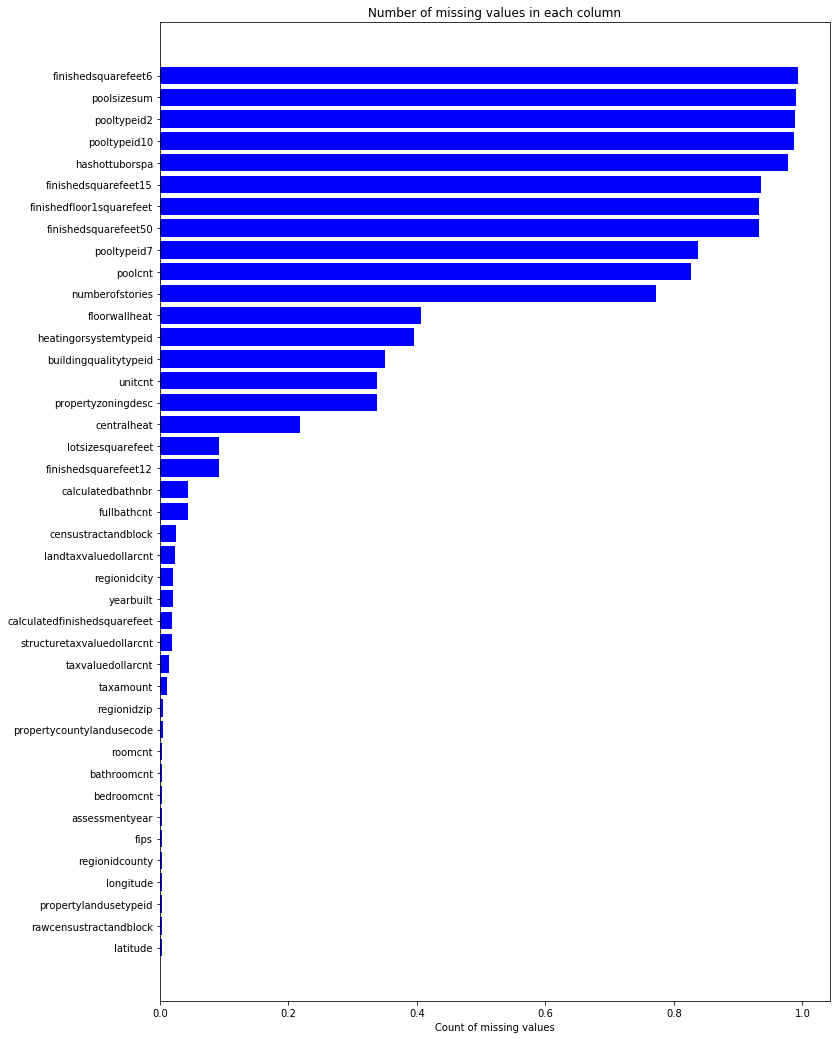

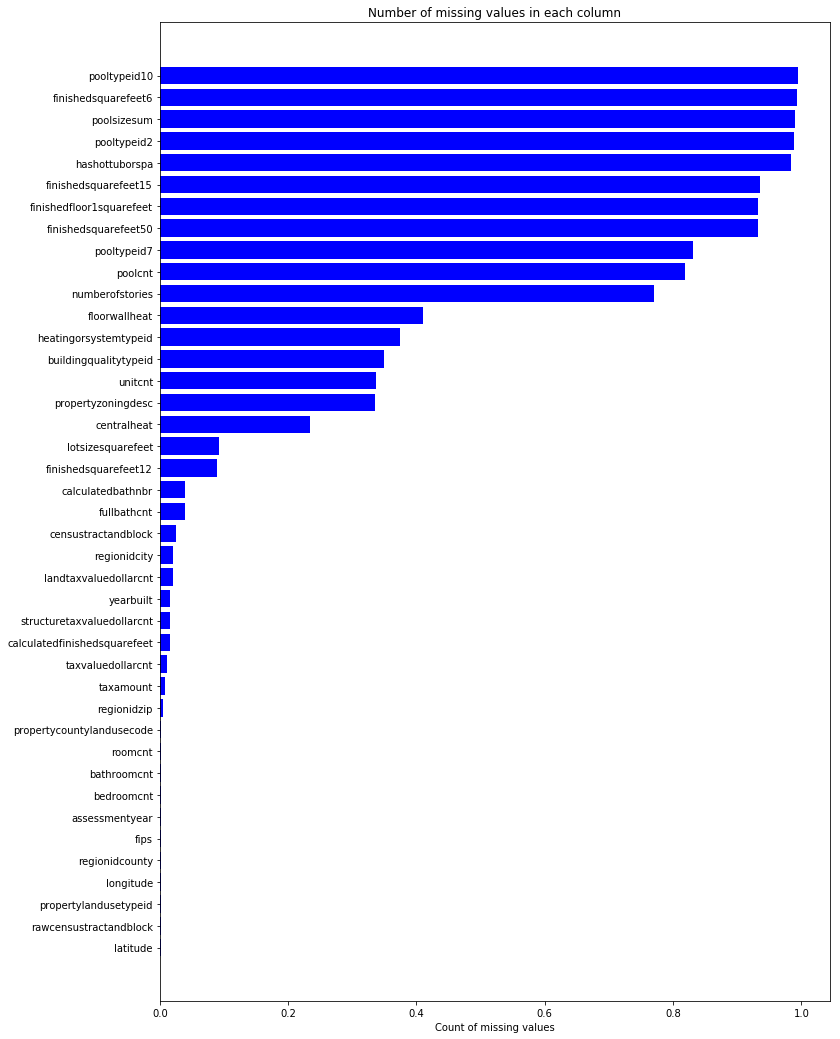

In [89]:
missing_2016_df = properties_2016_df.isnull().sum(axis=0).reset_index()
missing_2016_df.columns = ['column_name', 'missing_pct']
missing_2016_df = missing_2016_df.loc[missing_2016_df['missing_pct']>0]
missing_2016_df['missing_pct'] = missing_2016_df['missing_pct'] / length_properties_2016
missing_2016_df = missing_2016_df.sort_values(by='missing_pct')
ind = np.arange(missing_2016_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind, missing_2016_df.missing_pct.values, color='blue')
ax.set_yticks(ind)
ax.set_yticklabels(missing_2016_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")
plt.show()

missing_2017_df = properties_2017_df.isnull().sum(axis=0).reset_index()
missing_2017_df.columns = ['column_name', 'missing_pct']
missing_2017_df = missing_2017_df.loc[missing_2017_df['missing_pct']>0]
missing_2017_df['missing_pct'] = missing_2017_df['missing_pct'] / length_properties_2017
missing_2017_df = missing_2017_df.sort_values(by='missing_pct')
ind = np.arange(missing_2017_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind, missing_2017_df.missing_pct.values, color='blue')
ax.set_yticks(ind)
ax.set_yticklabels(missing_2017_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")
plt.show()

_Ah yes. We're not quite done with the heating variables yet._

In [90]:
properties_2017_df['centralheat'] = properties_2017_df['centralheat'].fillna(0)
properties_2016_df['centralheat'] = properties_2016_df['centralheat'].fillna(0)

properties_2017_df['floorwallheat'] = properties_2017_df['floorwallheat'].fillna(0)
properties_2016_df['floorwallheat'] = properties_2016_df['floorwallheat'].fillna(0)

del properties_2016_df['heatingorsystemtypeid']
del properties_2017_df['heatingorsystemtypeid']

_From now on, Let's only look at variables that have missing values._

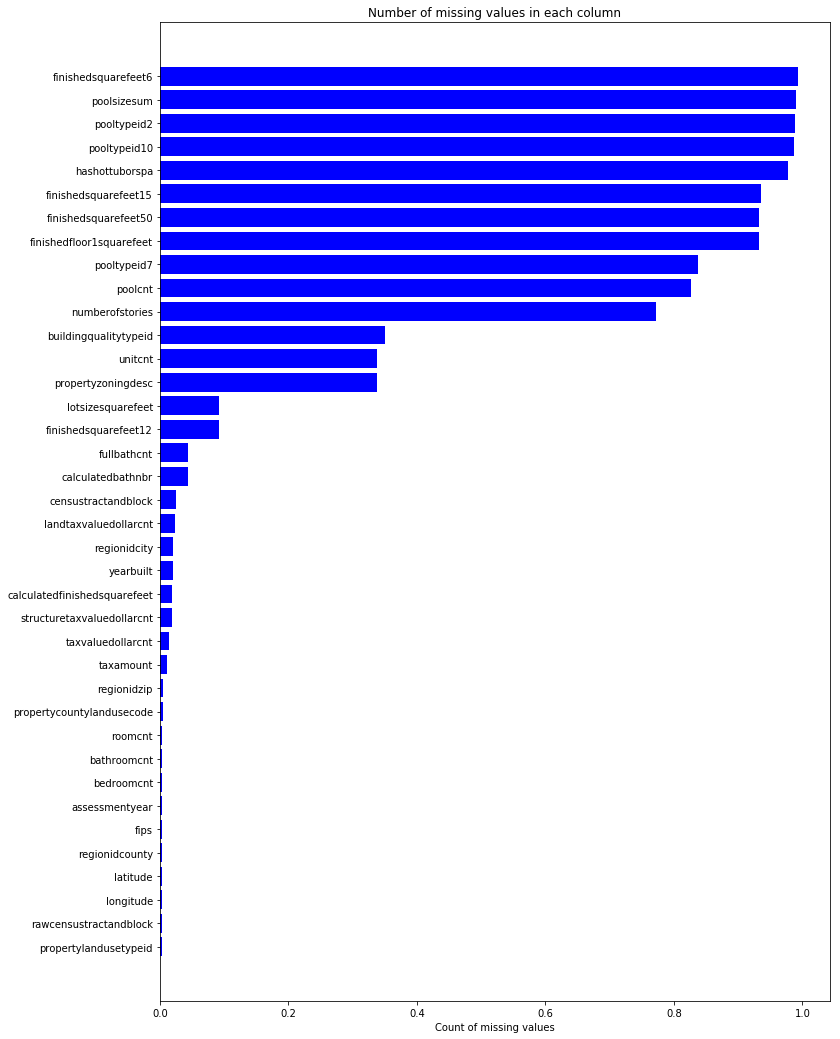

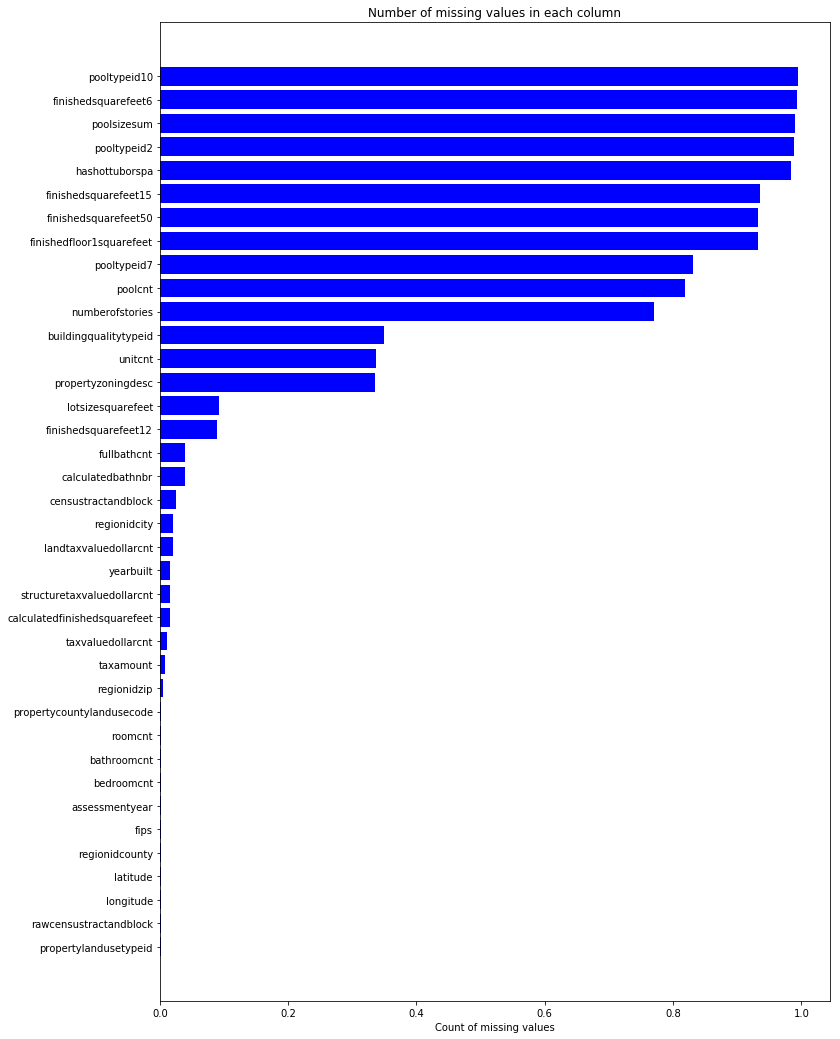

In [91]:
missing_2016_df = properties_2016_df.isnull().sum(axis=0).reset_index()
missing_2016_df.columns = ['column_name', 'missing_pct']
missing_2016_df = missing_2016_df.loc[missing_2016_df['missing_pct']>0]
missing_2016_df['missing_pct'] = missing_2016_df['missing_pct'] / length_properties_2016
missing_2016_df = missing_2016_df.sort_values(by='missing_pct')
ind = np.arange(missing_2016_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind, missing_2016_df.missing_pct.values, color='blue')
ax.set_yticks(ind)
ax.set_yticklabels(missing_2016_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")
plt.show()

missing_2017_df = properties_2017_df.isnull().sum(axis=0).reset_index()
missing_2017_df.columns = ['column_name', 'missing_pct']
missing_2017_df = missing_2017_df.loc[missing_2017_df['missing_pct']>0]
missing_2017_df['missing_pct'] = missing_2017_df['missing_pct'] / length_properties_2017
missing_2017_df = missing_2017_df.sort_values(by='missing_pct')
ind = np.arange(missing_2017_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind, missing_2017_df.missing_pct.values, color='blue')
ax.set_yticks(ind)
ax.set_yticklabels(missing_2017_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")
plt.show()

_Much better. Let's see if we can knock out the next three real fast - starting with 'buildingqualitytypeid'._

In [93]:
unique = properties_2017_df['buildingqualitytypeid'].unique()
unique.sort()
logging.debug(unique)

unique = properties_2016_df['buildingqualitytypeid'].unique()
unique.sort()
logging.debug(unique)

DEBUG:root:[  1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  nan]
DEBUG:root:[  1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  nan]


_Hmmmm that seems like all of the levels are present. Let's take a look at the distribution and figure out how to impute those values._

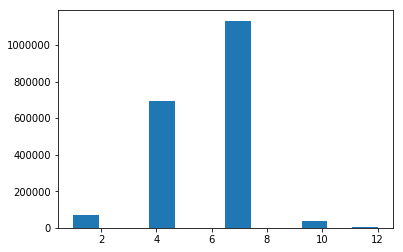

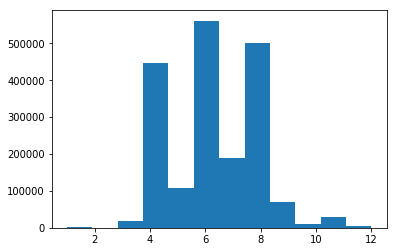

In [94]:
values = properties_2016_df[np.isfinite(properties_2016_df['buildingqualitytypeid'])].buildingqualitytypeid.values

plt.close()
plt.hist(values, bins=12)
plt.show()

values = properties_2017_df[np.isfinite(properties_2017_df['buildingqualitytypeid'])].buildingqualitytypeid.values

plt.close()
plt.hist(values, bins=12)
plt.show()

_Wow. That's a little strange and unexpected. The description says, " Overall assessment of condition of the building from best (lowest) to worst (highest)." So we should probably do a couple things here._

- First, we should probably reduce the number of values (and hopefully smooth out the distribution)
- Second, we need to impute the missing values

_We could also take a look at the distributions over time to see if there is any trend there._

In [95]:
import math

def assignquality(row):
    if np.isfinite(row['buildingqualitytypeid']):
        return math.ceil(row['buildingqualitytypeid'] / 2)

properties_2017_df['buildingquality'] = properties_2017_df.apply(assignquality, axis=1)
properties_2016_df['buildingquality'] = properties_2016_df.apply(assignquality, axis=1)


In [96]:
unique = properties_2016_df['buildingquality'].unique()
unique.sort()
logging.debug(unique)

unique = properties_2017_df['buildingquality'].unique()
unique.sort()
logging.debug(unique)

DEBUG:root:[  1.   2.   3.   4.   5.   6.  nan]
DEBUG:root:[  1.   2.   3.   4.   5.   6.  nan]


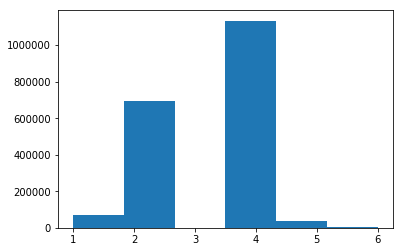

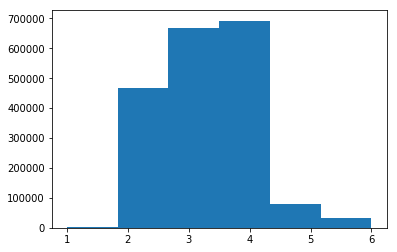

In [97]:
values = properties_2016_df[np.isfinite(properties_2016_df['buildingquality'])].buildingquality.values

plt.close()
plt.hist(values, bins=6)
plt.show()

values = properties_2017_df[np.isfinite(properties_2017_df['buildingquality'])].buildingquality.values

plt.close()
plt.hist(values, bins=6)
plt.show()

_Before we move on any further, let's write out our progress one more time just to be safe._

In [98]:
properties_2016_df.to_csv("Input/properties_2016_mod.csv", sep=',', encoding='utf-8', index=False)
properties_2017_df.to_csv("Input/properties_2017_mod.csv", sep=',', encoding='utf-8', index=False)

In [ ]:
logging.debug("READING IN 2016 PROPERTIES...")
properties_2016_df = pd.read_csv("Input/properties_2016_mod.csv")

logging.debug("READING IN 2017 PROPERTIES...")
properties_2017_df = pd.read_csv("Input/properties_2017_mod.csv")

_Ok! This has been a lot of fun, BUT I think the best use of my time will be slapping some mean, meds, and modes into the missing values for now and getting on to the fun stuff! THE ANALYSIS!_

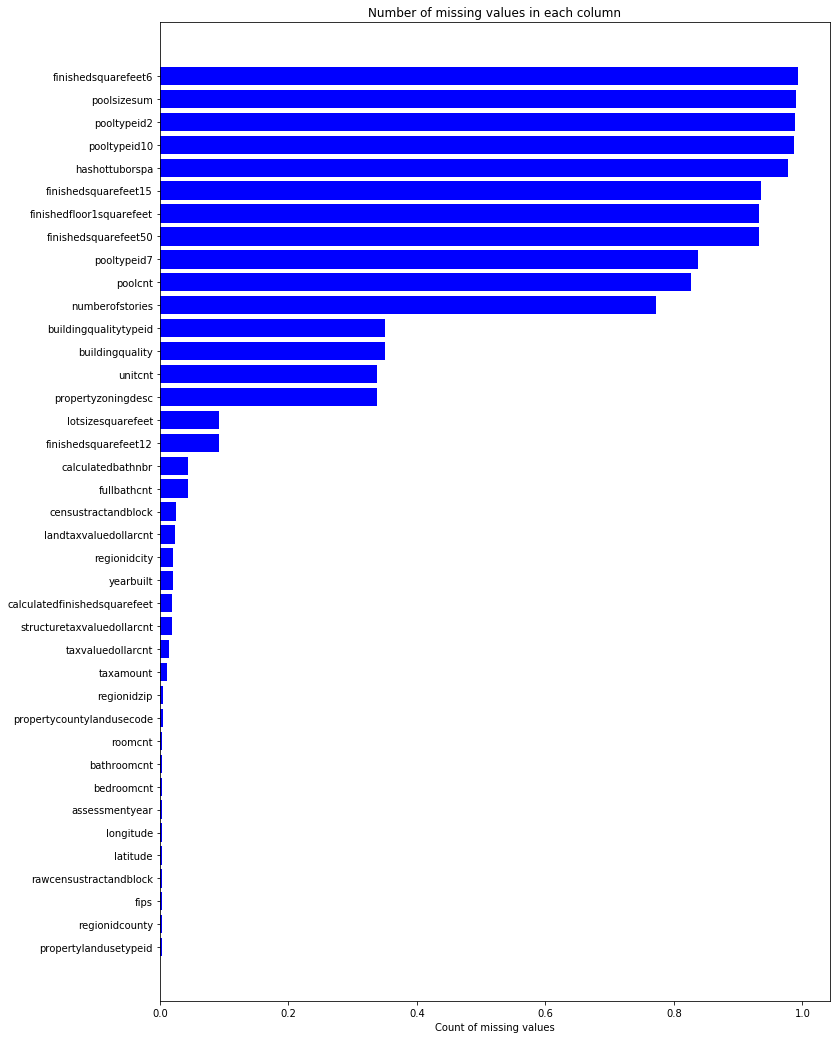

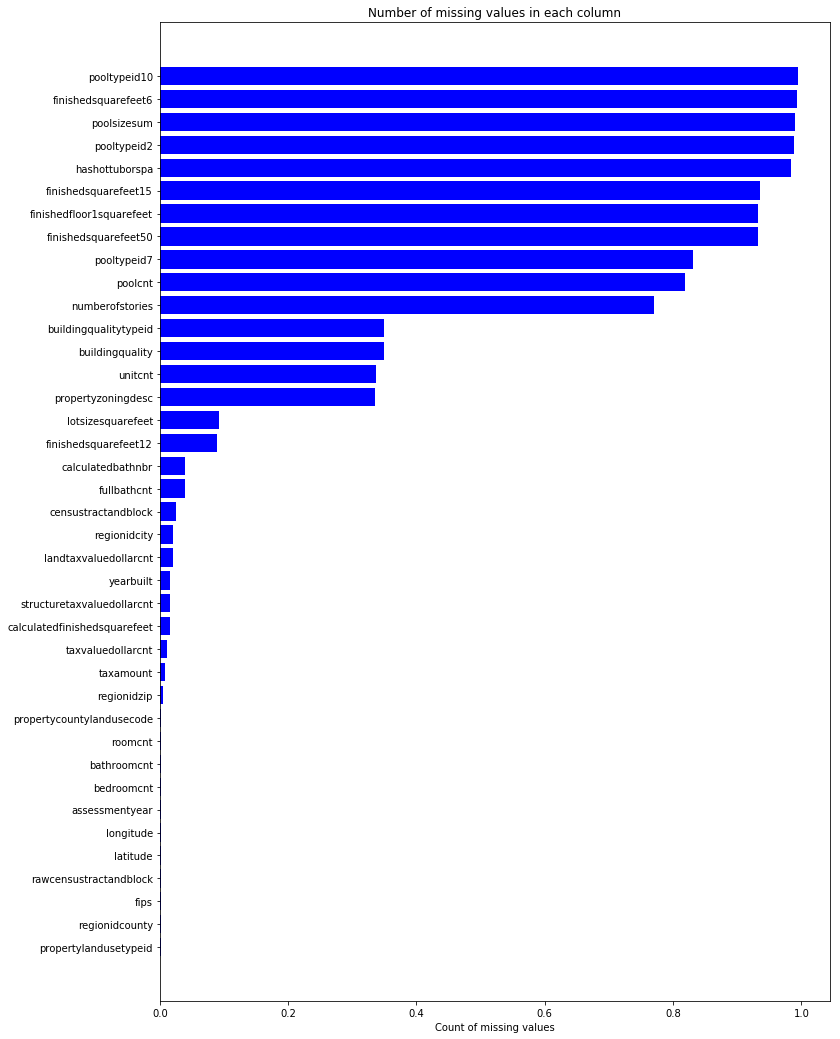

In [99]:
missing_2016_df = properties_2016_df.isnull().sum(axis=0).reset_index()
missing_2016_df.columns = ['column_name', 'missing_pct']
missing_2016_df = missing_2016_df.loc[missing_2016_df['missing_pct']>0]
missing_2016_df['missing_pct'] = missing_2016_df['missing_pct'] / length_properties_2016
missing_2016_df = missing_2016_df.sort_values(by='missing_pct')
ind = np.arange(missing_2016_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind, missing_2016_df.missing_pct.values, color='blue')
ax.set_yticks(ind)
ax.set_yticklabels(missing_2016_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")
plt.show()

missing_2017_df = properties_2017_df.isnull().sum(axis=0).reset_index()
missing_2017_df.columns = ['column_name', 'missing_pct']
missing_2017_df = missing_2017_df.loc[missing_2017_df['missing_pct']>0]
missing_2017_df['missing_pct'] = missing_2017_df['missing_pct'] / length_properties_2017
missing_2017_df = missing_2017_df.sort_values(by='missing_pct')
ind = np.arange(missing_2017_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind, missing_2017_df.missing_pct.values, color='blue')
ax.set_yticks(ind)
ax.set_yticklabels(missing_2017_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")
plt.show()

_Great! That cleared it up! Now let's work from the bottom up. First: 'assessmentyear'._

In [100]:
unique = properties_2017_df['assessmentyear'].unique()

logging.debug(unique)

DEBUG:root:[ 2016.  2015.  2014.  2003.  2012.  2001.  2011.  2013.  2010.    nan
  2004.  2005.  2002.  2000.  2009.]


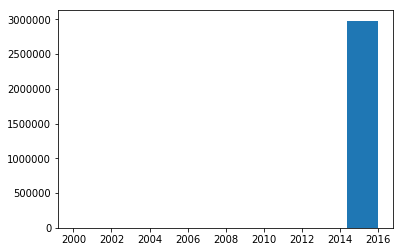

DEBUG:root:2015.9982305508127, 2016.0, 0    2016.0
dtype: float64


In [101]:
values = properties_2017_df[np.isfinite(properties_2017_df['assessmentyear'])].assessmentyear.values

plt.close()
plt.hist(values)
plt.show()

mean = properties_2017_df['assessmentyear'].mean()
med = properties_2017_df['assessmentyear'].median()
mode = properties_2017_df['assessmentyear'].mode()

logging.debug("{}, {}, {}".format(mean, med, mode))

In [102]:
properties_2017_df['assessmentyear'] = properties_2017_df['assessmentyear'].fillna(2016)

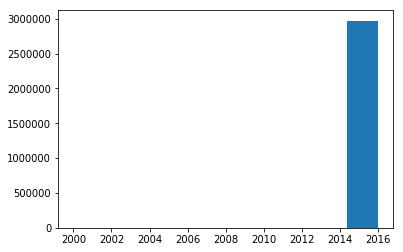

DEBUG:root:2014.999458937419, 2015.0, 0    2015.0
dtype: float64


In [103]:
values = properties_2016_df[np.isfinite(properties_2016_df['assessmentyear'])].assessmentyear.values

plt.close()
plt.hist(values)
plt.show()

mean = properties_2016_df['assessmentyear'].mean()
med = properties_2016_df['assessmentyear'].median()
mode = properties_2016_df['assessmentyear'].mode()

logging.debug("{}, {}, {}".format(mean, med, mode))

In [104]:
properties_2016_df['assessmentyear'] = properties_2016_df['assessmentyear'].fillna(2015)

_Great! Now 'bedroomcnt'._

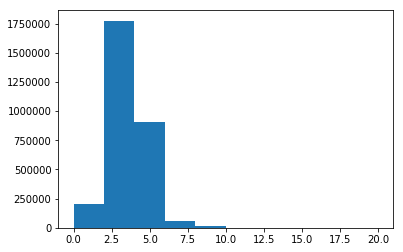

DEBUG:root:3.088948797938776, 3.0, 0    3.0
dtype: float64


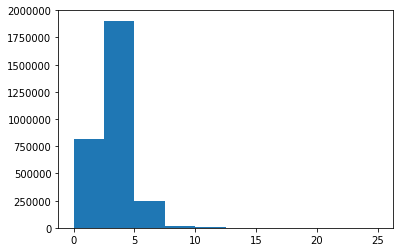

DEBUG:root:3.093362040752822, 3.0, 0    3.0
dtype: float64


In [106]:
values = properties_2016_df[np.isfinite(properties_2016_df['bedroomcnt'])].bedroomcnt.values

plt.close()
plt.hist(values)
plt.show()

mean = properties_2016_df['bedroomcnt'].mean()
med = properties_2016_df['bedroomcnt'].median()
mode = properties_2016_df['bedroomcnt'].mode()

logging.debug("{}, {}, {}".format(mean, med, mode))

values = properties_2017_df[np.isfinite(properties_2017_df['bedroomcnt'])].bedroomcnt.values

plt.close()
plt.hist(values)
plt.show()

mean = properties_2017_df['bedroomcnt'].mean()
med = properties_2017_df['bedroomcnt'].median()
mode = properties_2017_df['bedroomcnt'].mode()

logging.debug("{}, {}, {}".format(mean, med, mode))

In [107]:
properties_2017_df['bedroomcnt'] = properties_2017_df['bedroomcnt'].fillna(3)
properties_2016_df['bedroomcnt'] = properties_2016_df['bedroomcnt'].fillna(3)

_And 'bathroomcnt'._

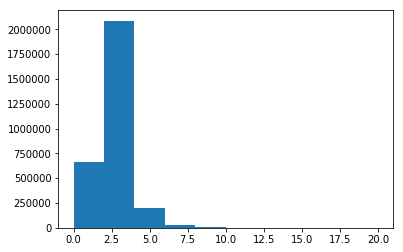

DEBUG:root:2.2091427336818263, 2.0, 0    2.0
dtype: float64


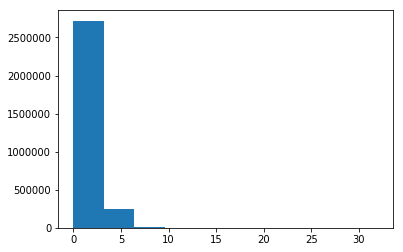

DEBUG:root:2.216195770992469, 2.0, 0    2.0
dtype: float64


In [108]:
values = properties_2016_df[np.isfinite(properties_2016_df['bathroomcnt'])].bathroomcnt.values

plt.close()
plt.hist(values)
plt.show()

mean = properties_2016_df['bathroomcnt'].mean()
med = properties_2016_df['bathroomcnt'].median()
mode = properties_2016_df['bathroomcnt'].mode()

logging.debug("{}, {}, {}".format(mean, med, mode))

values = properties_2017_df[np.isfinite(properties_2017_df['bathroomcnt'])].bathroomcnt.values

plt.close()
plt.hist(values)
plt.show()

mean = properties_2017_df['bathroomcnt'].mean()
med = properties_2017_df['bathroomcnt'].median()
mode = properties_2017_df['bathroomcnt'].mode()

logging.debug("{}, {}, {}".format(mean, med, mode))

In [109]:
properties_2017_df['bathroomcnt'] = properties_2017_df['bathroomcnt'].fillna(2)
properties_2016_df['bathroomcnt'] = properties_2016_df['bathroomcnt'].fillna(2)

_And 'roomcnt'._

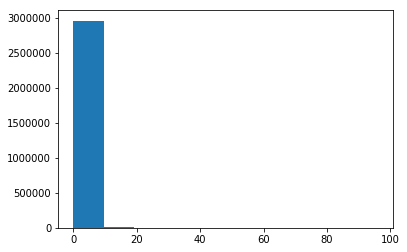

DEBUG:root:1.4750183438912992, 0.0, 0    0.0
dtype: float64


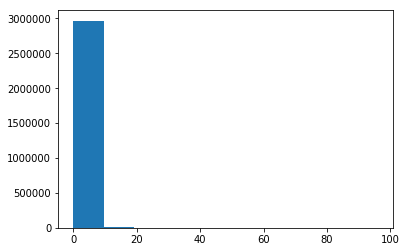

DEBUG:root:1.4743572633798396, 0.0, 0    0.0
dtype: float64


In [110]:
values = properties_2016_df[np.isfinite(properties_2016_df['roomcnt'])].roomcnt.values

plt.close()
plt.hist(values)
plt.show()

mean = properties_2016_df['roomcnt'].mean()
med = properties_2016_df['roomcnt'].median()
mode = properties_2016_df['roomcnt'].mode()

logging.debug("{}, {}, {}".format(mean, med, mode))

values = properties_2017_df[np.isfinite(properties_2017_df['roomcnt'])].roomcnt.values

plt.close()
plt.hist(values)
plt.show()

mean = properties_2017_df['roomcnt'].mean()
med = properties_2017_df['roomcnt'].median()
mode = properties_2017_df['roomcnt'].mode()

logging.debug("{}, {}, {}".format(mean, med, mode))

_This variable is missing so few values AND it seems sooooo wrong, so we're going to scrap it._

In [111]:
del properties_2016_df['roomcnt']
del properties_2017_df['roomcnt']

_Time to save again and check in._

In [ ]:
properties_2016_df.to_csv("Input/properties_2016_mod.csv", sep=',', encoding='utf-8', index=False)
properties_2017_df.to_csv("Input/properties_2017_mod.csv", sep=',', encoding='utf-8', index=False)

In [ ]:
logging.debug("READING IN 2016 PROPERTIES...")
properties_2016_df = pd.read_csv("Input/properties_2016_mod.csv")

logging.debug("READING IN 2017 PROPERTIES...")
properties_2017_df = pd.read_csv("Input/properties_2017_mod.csv")

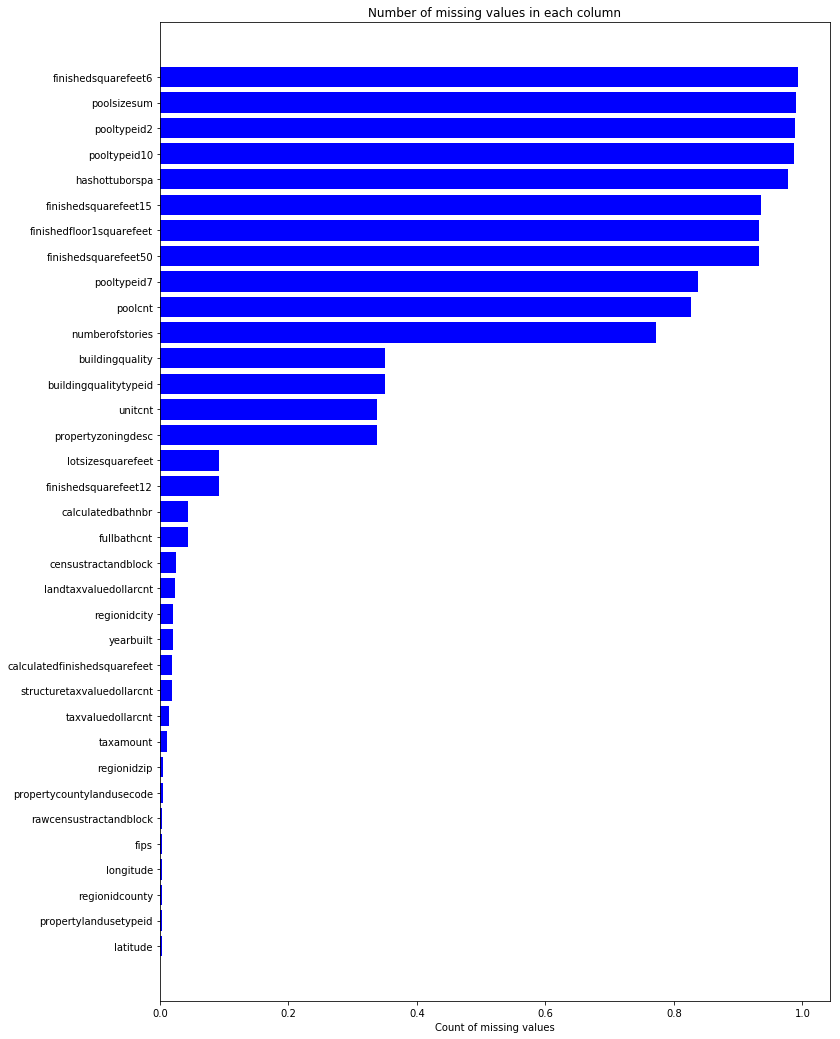

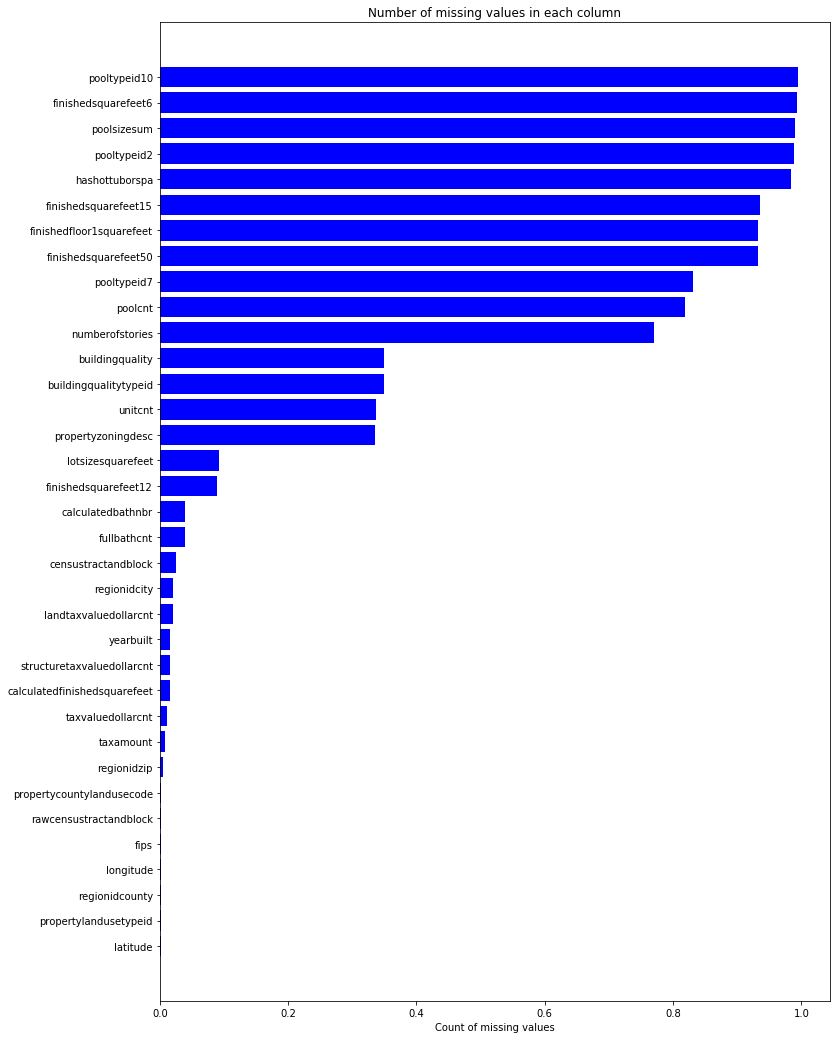

In [112]:
missing_2016_df = properties_2016_df.isnull().sum(axis=0).reset_index()
missing_2016_df.columns = ['column_name', 'missing_pct']
missing_2016_df = missing_2016_df.loc[missing_2016_df['missing_pct']>0]
missing_2016_df['missing_pct'] = missing_2016_df['missing_pct'] / length_properties_2016
missing_2016_df = missing_2016_df.sort_values(by='missing_pct')
ind = np.arange(missing_2016_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind, missing_2016_df.missing_pct.values, color='blue')
ax.set_yticks(ind)
ax.set_yticklabels(missing_2016_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")
plt.show()

missing_2017_df = properties_2017_df.isnull().sum(axis=0).reset_index()
missing_2017_df.columns = ['column_name', 'missing_pct']
missing_2017_df = missing_2017_df.loc[missing_2017_df['missing_pct']>0]
missing_2017_df['missing_pct'] = missing_2017_df['missing_pct'] / length_properties_2017
missing_2017_df = missing_2017_df.sort_values(by='missing_pct')
ind = np.arange(missing_2017_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind, missing_2017_df.missing_pct.values, color='blue')
ax.set_yticks(ind)
ax.set_yticklabels(missing_2017_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")
plt.show()

_We'll move on to 'fullbathcnt'._

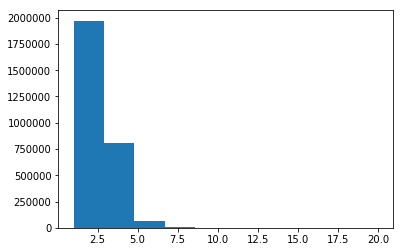

DEBUG:root:2.2441651014159905, 2.0, 0    2.0
dtype: float64


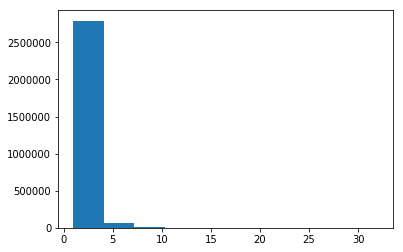

DEBUG:root:2.248088865613388, 2.0, 0    2.0
dtype: float64


In [113]:
values = properties_2016_df[np.isfinite(properties_2016_df['fullbathcnt'])].fullbathcnt.values

plt.close()
plt.hist(values)
plt.show()

mean = properties_2016_df['fullbathcnt'].mean()
med = properties_2016_df['fullbathcnt'].median()
mode = properties_2016_df['fullbathcnt'].mode()

logging.debug("{}, {}, {}".format(mean, med, mode))

values = properties_2017_df[np.isfinite(properties_2017_df['fullbathcnt'])].fullbathcnt.values

plt.close()
plt.hist(values)
plt.show()

mean = properties_2017_df['fullbathcnt'].mean()
med = properties_2017_df['fullbathcnt'].median()
mode = properties_2017_df['fullbathcnt'].mode()

logging.debug("{}, {}, {}".format(mean, med, mode))

In [114]:
properties_2017_df['fullbathcnt'] = properties_2017_df['fullbathcnt'].fillna(2)
properties_2016_df['fullbathcnt'] = properties_2016_df['fullbathcnt'].fillna(2)

_On to 'calculatedbathnbr'._

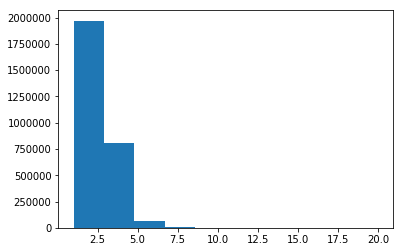

DEBUG:root:2.2992625087306853, 2.0, 0    2.0
dtype: float64


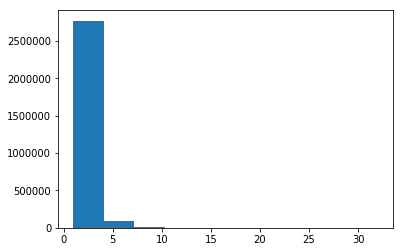

DEBUG:root:2.3038258251829373, 2.0, 0    2.0
dtype: float64


In [115]:
values = properties_2016_df[np.isfinite(properties_2016_df['calculatedbathnbr'])].calculatedbathnbr.values

plt.close()
plt.hist(values)
plt.show()

mean = properties_2016_df['calculatedbathnbr'].mean()
med = properties_2016_df['calculatedbathnbr'].median()
mode = properties_2016_df['calculatedbathnbr'].mode()

logging.debug("{}, {}, {}".format(mean, med, mode))

values = properties_2017_df[np.isfinite(properties_2017_df['calculatedbathnbr'])].calculatedbathnbr.values

plt.close()
plt.hist(values)
plt.show()

mean = properties_2017_df['calculatedbathnbr'].mean()
med = properties_2017_df['calculatedbathnbr'].median()
mode = properties_2017_df['calculatedbathnbr'].mode()

logging.debug("{}, {}, {}".format(mean, med, mode))

_This variable seems redundant so we will remove it._

In [116]:
del properties_2017_df['calculatedbathnbr']
del properties_2016_df['calculatedbathnbr']

_'unitcnt'._

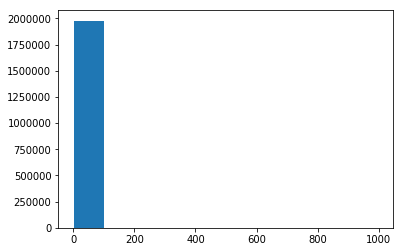

DEBUG:root:1.181171080511153, 1.0, 0    1.0
dtype: float64


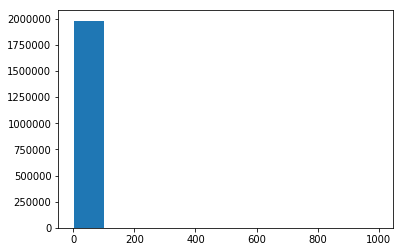

DEBUG:root:1.1803030930187244, 1.0, 0    1.0
dtype: float64


In [117]:
values = properties_2016_df[np.isfinite(properties_2016_df['unitcnt'])].unitcnt.values

plt.close()
plt.hist(values)
plt.show()

mean = properties_2016_df['unitcnt'].mean()
med = properties_2016_df['unitcnt'].median()
mode = properties_2016_df['unitcnt'].mode()

logging.debug("{}, {}, {}".format(mean, med, mode))

values = properties_2017_df[np.isfinite(properties_2017_df['unitcnt'])].unitcnt.values

plt.close()
plt.hist(values)
plt.show()

mean = properties_2017_df['unitcnt'].mean()
med = properties_2017_df['unitcnt'].median()
mode = properties_2017_df['unitcnt'].mode()

logging.debug("{}, {}, {}".format(mean, med, mode))

_Seems probable._

In [118]:
properties_2017_df['unitcnt'] = properties_2017_df['unitcnt'].fillna(1)
properties_2016_df['unitcnt'] = properties_2016_df['unitcnt'].fillna(1)

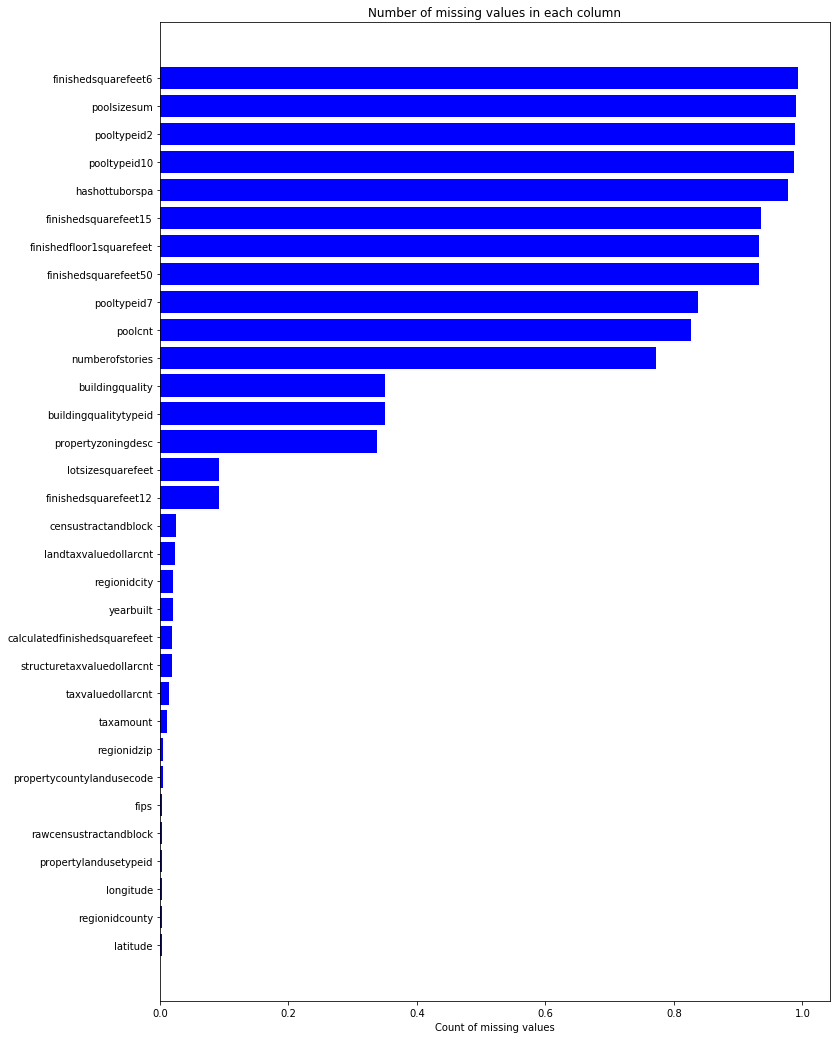

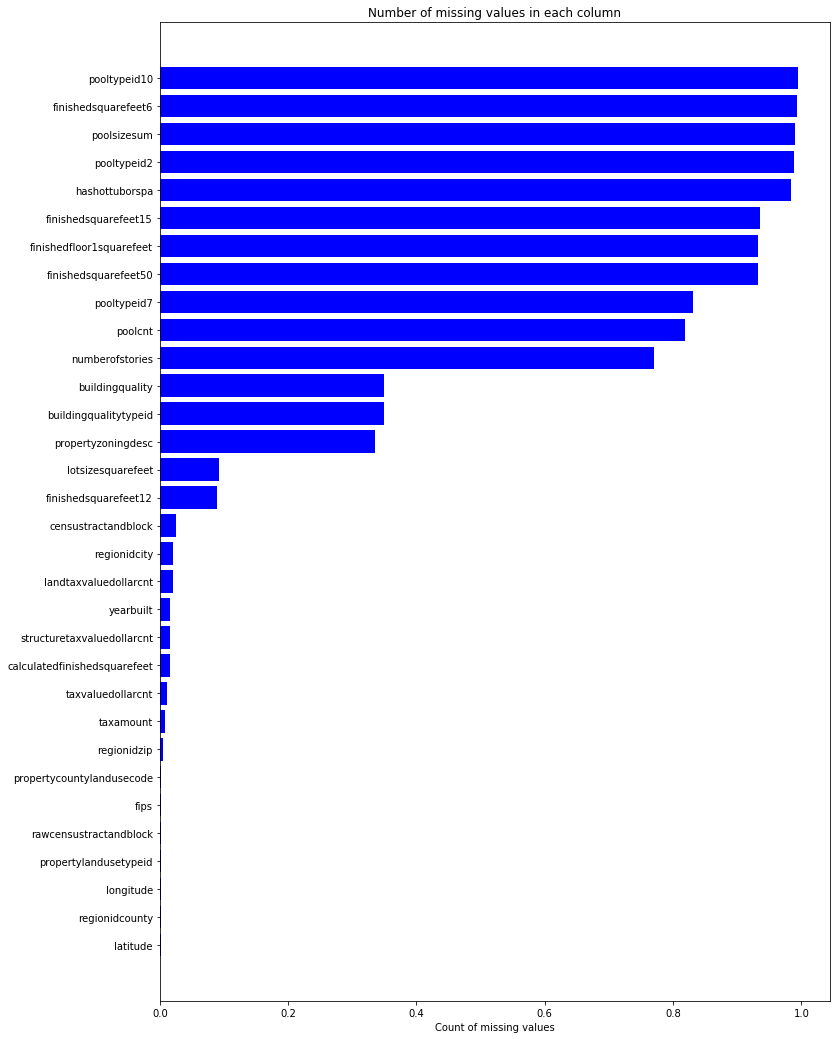

In [119]:
missing_2016_df = properties_2016_df.isnull().sum(axis=0).reset_index()
missing_2016_df.columns = ['column_name', 'missing_pct']
missing_2016_df = missing_2016_df.loc[missing_2016_df['missing_pct']>0]
missing_2016_df['missing_pct'] = missing_2016_df['missing_pct'] / length_properties_2016
missing_2016_df = missing_2016_df.sort_values(by='missing_pct')
ind = np.arange(missing_2016_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind, missing_2016_df.missing_pct.values, color='blue')
ax.set_yticks(ind)
ax.set_yticklabels(missing_2016_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")
plt.show()

missing_2017_df = properties_2017_df.isnull().sum(axis=0).reset_index()
missing_2017_df.columns = ['column_name', 'missing_pct']
missing_2017_df = missing_2017_df.loc[missing_2017_df['missing_pct']>0]
missing_2017_df['missing_pct'] = missing_2017_df['missing_pct'] / length_properties_2017
missing_2017_df = missing_2017_df.sort_values(by='missing_pct')
ind = np.arange(missing_2017_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind, missing_2017_df.missing_pct.values, color='blue')
ax.set_yticks(ind)
ax.set_yticklabels(missing_2017_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")
plt.show()

_Now would be a great time to have the location-based knn up and running for many of these values... Let's try one more time._

In [120]:
from sklearn import neighbors
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder


def fillna_knn( df, base, target, fraction = 1, threshold = 10, n_neighbors = 5 ):
    assert isinstance( base , list ) or isinstance( base , np.ndarray ) and isinstance( target, str ) 
    
    miss = df[target].isnull()
    notmiss = ~miss 
    nummiss = miss.sum()
    
    X = df.loc[notmiss, base]
    Y = df.loc[notmiss, target]
    
    logging.debug("FITTING...")
    n_neighbors = n_neighbors
    clf = neighbors.KNeighborsClassifier( n_neighbors, weights = 'uniform' )
    clf.fit( X, Y )
    
    logging.debug("PREDICTING...")
    Z = clf.predict(df.loc[miss, base])
    
    logging.debug(Z)
    logging.debug("{}, {}".format(len(Z), df[miss].shape[0]))
    
    i = 0

    logging.debug("POPULATING...")
    df.loc[miss, target] = Z


In [121]:
from sklearn import neighbors
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder


def fillna_knr( df, base, target, fraction = 1, threshold = 10, n_neighbors = 5 ):
    assert isinstance( base , list ) or isinstance( base , np.ndarray ) and isinstance( target, str ) 
    
    miss = df[target].isnull()
    notmiss = ~miss 
    nummiss = miss.sum()
    
    X = df.loc[notmiss, base]
    Y = df.loc[notmiss, target]
    
    logging.debug("FITTING...")
    n_neighbors = n_neighbors
    clf = neighbors.KNeighborsRegressor( n_neighbors, weights = 'uniform' )
    clf.fit( X, Y )
    
    logging.debug("PREDICTING...")
    Z = clf.predict(df.loc[miss, base])
    
    logging.debug(Z)
    logging.debug("{}, {}".format(len(Z), df[miss].shape[0]))
    
    i = 0

    logging.debug("POPULATING...")
    df.loc[miss, target] = Z



_Before we can fill in anymore values, we need to handle the properties that are missing 'latitude' and 'longitude'. We will do this by assuming that 'parcelid' is not completely arbitrary and will use 1NN._

In [122]:
fillna_knr( df = properties_2016_df,
                  base = ['parcelid'] ,
                  target = 'latitude',
                  n_neighbors = 1)

fillna_knr( df = properties_2017_df,
                  base = ['parcelid'] ,
                  target = 'latitude',
                  n_neighbors = 1)

DEBUG:root:FITTING...
DEBUG:root:PREDICTING...
DEBUG:root:[ 34506027.  33720178.  34430204. ...,  34506027.  34506027.  34506027.]
DEBUG:root:11437, 11437
DEBUG:root:POPULATING...
DEBUG:root:FITTING...
DEBUG:root:PREDICTING...
DEBUG:root:[ 34762600.  34762600.  34762600. ...,  34288110.  33782127.  34059255.]
DEBUG:root:2932, 2932
DEBUG:root:POPULATING...


In [123]:
fillna_knr( df = properties_2016_df,
                  base = ['parcelid'] ,
                  target = 'longitude',
                  n_neighbors = 1)

fillna_knr( df = properties_2017_df,
                  base = ['parcelid'] ,
                  target = 'longitude',
                  n_neighbors = 1)

DEBUG:root:FITTING...
DEBUG:root:PREDICTING...
DEBUG:root:[ -1.17900624e+08  -1.18287362e+08  -1.18529781e+08 ...,  -1.17900624e+08
  -1.17900624e+08  -1.17900624e+08]
DEBUG:root:11437, 11437
DEBUG:root:POPULATING...
DEBUG:root:FITTING...
DEBUG:root:PREDICTING...
DEBUG:root:[ -1.18089000e+08  -1.18089000e+08  -1.18089000e+08 ...,  -1.18879899e+08
  -1.17810589e+08  -1.18023995e+08]
DEBUG:root:2932, 2932
DEBUG:root:POPULATING...


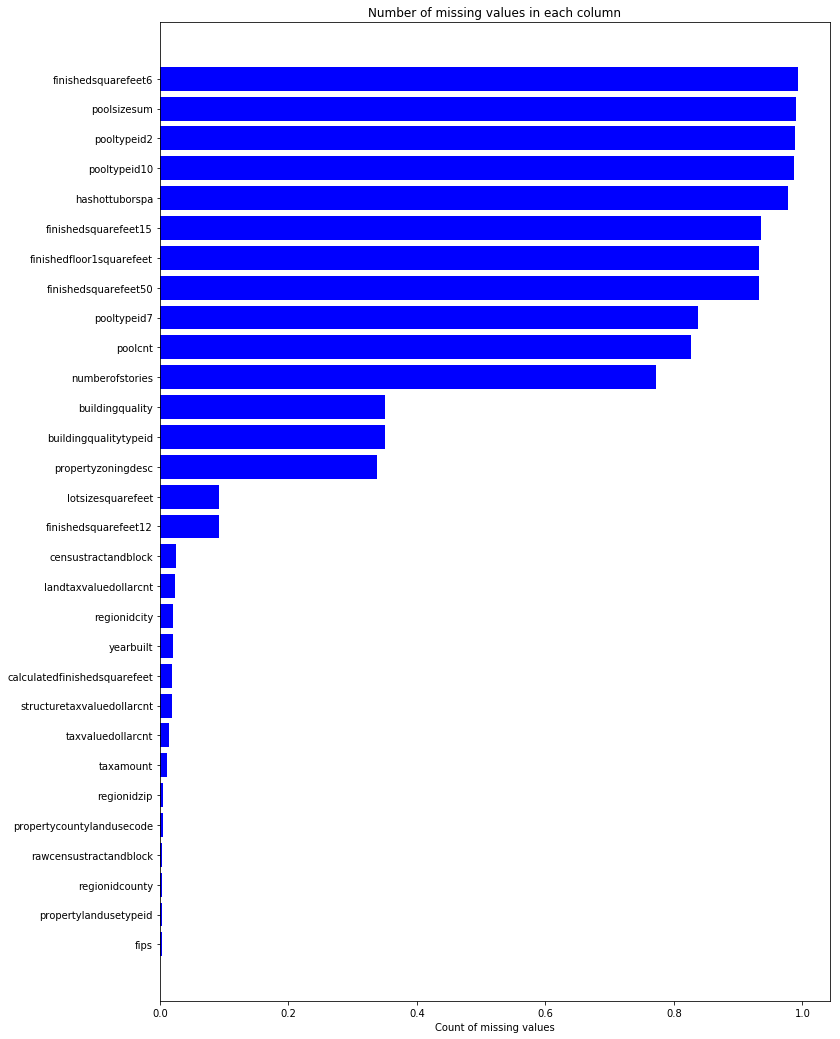

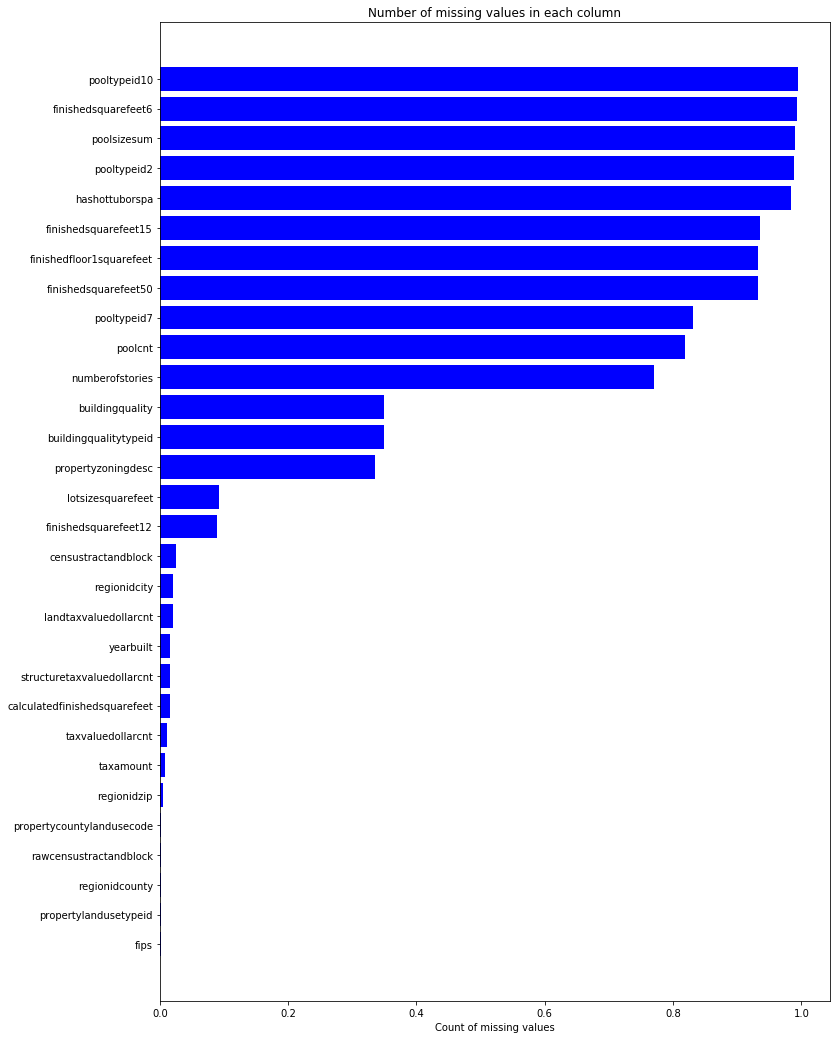

In [124]:
missing_2016_df = properties_2016_df.isnull().sum(axis=0).reset_index()
missing_2016_df.columns = ['column_name', 'missing_pct']
missing_2016_df = missing_2016_df.loc[missing_2016_df['missing_pct']>0]
missing_2016_df['missing_pct'] = missing_2016_df['missing_pct'] / length_properties_2016
missing_2016_df = missing_2016_df.sort_values(by='missing_pct')
ind = np.arange(missing_2016_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind, missing_2016_df.missing_pct.values, color='blue')
ax.set_yticks(ind)
ax.set_yticklabels(missing_2016_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")
plt.show()

missing_2017_df = properties_2017_df.isnull().sum(axis=0).reset_index()
missing_2017_df.columns = ['column_name', 'missing_pct']
missing_2017_df = missing_2017_df.loc[missing_2017_df['missing_pct']>0]
missing_2017_df['missing_pct'] = missing_2017_df['missing_pct'] / length_properties_2017
missing_2017_df = missing_2017_df.sort_values(by='missing_pct')
ind = np.arange(missing_2017_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind, missing_2017_df.missing_pct.values, color='blue')
ax.set_yticks(ind)
ax.set_yticklabels(missing_2017_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")
plt.show()

_Now all samples have both 'latitude' and 'longitude' variables, so we can continue imputing the other values._

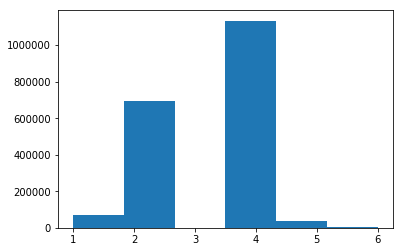

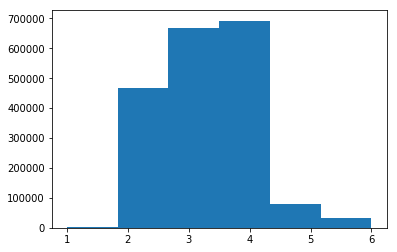

In [125]:
values = properties_2016_df[np.isfinite(properties_2016_df['buildingquality'])].buildingquality.values

plt.close()
plt.hist(values, bins=6)
plt.show()

values = properties_2017_df[np.isfinite(properties_2017_df['buildingquality'])].buildingquality.values

plt.close()
plt.hist(values, bins=6)
plt.show()

In [126]:
fillna_knn( df = properties_2017_df,
                  base = [ 'latitude', 'longitude' ] ,
                  target = 'buildingquality')

fillna_knn( df = properties_2016_df,
                  base = [ 'latitude', 'longitude' ] ,
                  target = 'buildingquality')

DEBUG:root:FITTING...
DEBUG:root:PREDICTING...
DEBUG:root:[ 5.  4.  3. ...,  4.  4.  4.]
DEBUG:root:1043822, 1043822
DEBUG:root:POPULATING...
DEBUG:root:FITTING...
DEBUG:root:PREDICTING...
DEBUG:root:[ 1.  4.  4. ...,  4.  4.  4.]
DEBUG:root:1046729, 1046729
DEBUG:root:POPULATING...


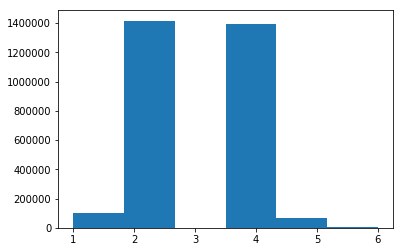

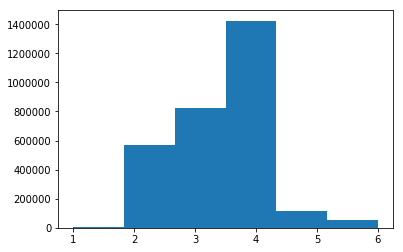

In [127]:
values = properties_2016_df[np.isfinite(properties_2016_df['buildingquality'])].buildingquality.values

plt.close()
plt.hist(values, bins=6)
plt.show()

values = properties_2017_df[np.isfinite(properties_2017_df['buildingquality'])].buildingquality.values

plt.close()
plt.hist(values, bins=6)
plt.show()

In [ ]:
properties_2016_df.to_csv("Input/properties_2016_mod.csv", sep=',', encoding='utf-8', index=False)
properties_2017_df.to_csv("Input/properties_2017_mod.csv", sep=',', encoding='utf-8', index=False)

_Now that we know that our function works, let's knock out a few more! 'regionidzip'._

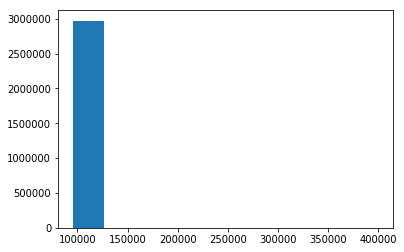

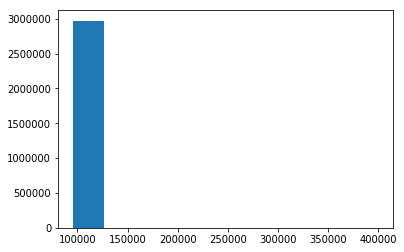

In [128]:
values = properties_2016_df[np.isfinite(properties_2016_df['regionidzip'])].regionidzip.values

plt.close()
plt.hist(values)
plt.show()

values = properties_2017_df[np.isfinite(properties_2017_df['regionidzip'])].regionidzip.values

plt.close()
plt.hist(values)
plt.show()

In [129]:
fillna_knn( df = properties_2017_df,
                  base = [ 'latitude', 'longitude' ] ,
                  target = 'regionidzip')

fillna_knn( df = properties_2016_df,
                  base = [ 'latitude', 'longitude' ] ,
                  target = 'regionidzip')

DEBUG:root:FITTING...
DEBUG:root:PREDICTING...
DEBUG:root:[ 97018.  97018.  97084. ...,  97097.  97067.  96479.]
DEBUG:root:12714, 12714
DEBUG:root:POPULATING...
DEBUG:root:FITTING...
DEBUG:root:PREDICTING...
DEBUG:root:[ 96426.  96366.  96378. ...,  97331.  97331.  97331.]
DEBUG:root:13980, 13980
DEBUG:root:POPULATING...


_'yearbuilt'_

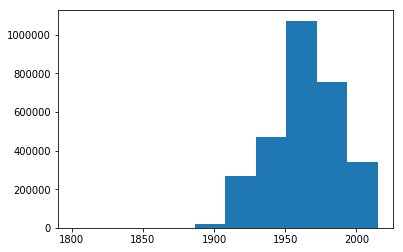

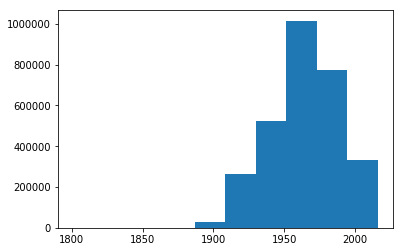

In [130]:
values = properties_2016_df[np.isfinite(properties_2016_df['yearbuilt'])].yearbuilt.values

plt.close()
plt.hist(values)
plt.show()

values = properties_2017_df[np.isfinite(properties_2017_df['yearbuilt'])].yearbuilt.values

plt.close()
plt.hist(values)
plt.show()

In [131]:
fillna_knn( df = properties_2017_df,
                  base = [ 'latitude', 'longitude' ] ,
                  target = 'yearbuilt')

fillna_knn( df = properties_2016_df,
                  base = [ 'latitude', 'longitude' ] ,
                  target = 'yearbuilt')

DEBUG:root:FITTING...
DEBUG:root:PREDICTING...
DEBUG:root:[ 1987.  1938.  1934. ...,  1995.  1960.  2009.]
DEBUG:root:47833, 47833
DEBUG:root:POPULATING...
DEBUG:root:FITTING...
DEBUG:root:PREDICTING...
DEBUG:root:[ 1987.  1972.  1948. ...,  1942.  1942.  1942.]
DEBUG:root:59928, 59928
DEBUG:root:POPULATING...


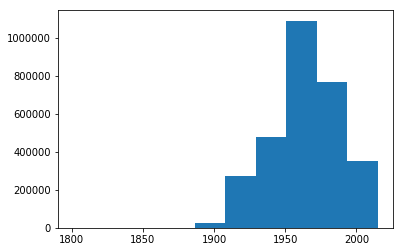

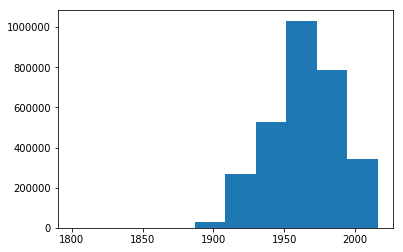

In [132]:
values = properties_2016_df[np.isfinite(properties_2016_df['yearbuilt'])].yearbuilt.values

plt.close()
plt.hist(values)
plt.show()

values = properties_2017_df[np.isfinite(properties_2017_df['yearbuilt'])].yearbuilt.values

plt.close()
plt.hist(values)
plt.show()

_'regionidcity'_

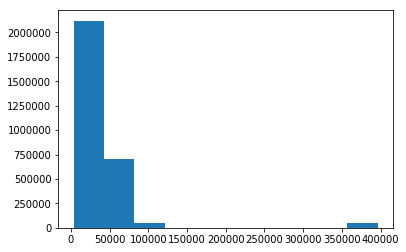

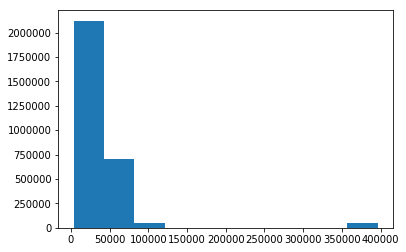

In [133]:
values = properties_2016_df[np.isfinite(properties_2016_df['regionidcity'])].regionidcity.values

plt.close()
plt.hist(values)
plt.show()

values = properties_2017_df[np.isfinite(properties_2017_df['regionidcity'])].regionidcity.values

plt.close()
plt.hist(values)
plt.show()

In [134]:
fillna_knn( df = properties_2017_df,
                  base = [ 'latitude', 'longitude' ] ,
                  target = 'regionidcity')

fillna_knn( df = properties_2016_df,
                  base = [ 'latitude', 'longitude' ] ,
                  target = 'regionidcity')

DEBUG:root:FITTING...
DEBUG:root:PREDICTING...
DEBUG:root:[ 54311.  54311.  12520. ...,  25974.  33252.  51861.]
DEBUG:root:62128, 62128
DEBUG:root:POPULATING...
DEBUG:root:FITTING...
DEBUG:root:PREDICTING...
DEBUG:root:[ 54311.  54311.  12520. ...,  13232.  13232.  13232.]
DEBUG:root:62845, 62845
DEBUG:root:POPULATING...


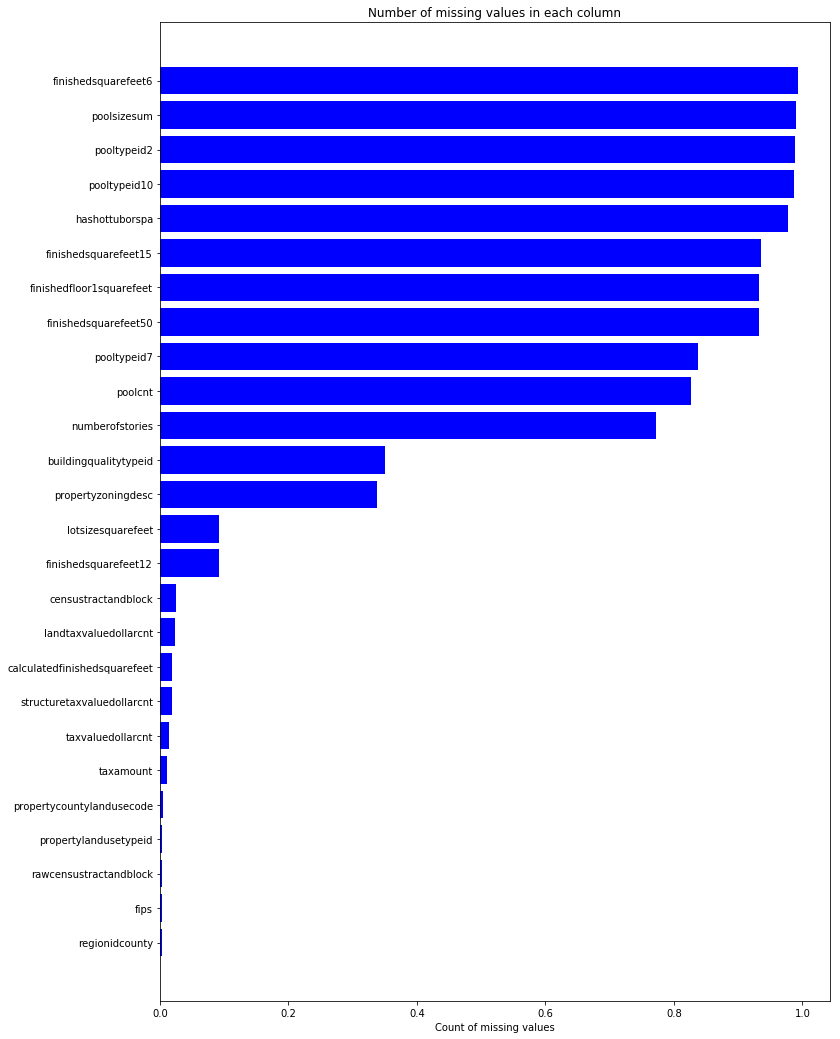

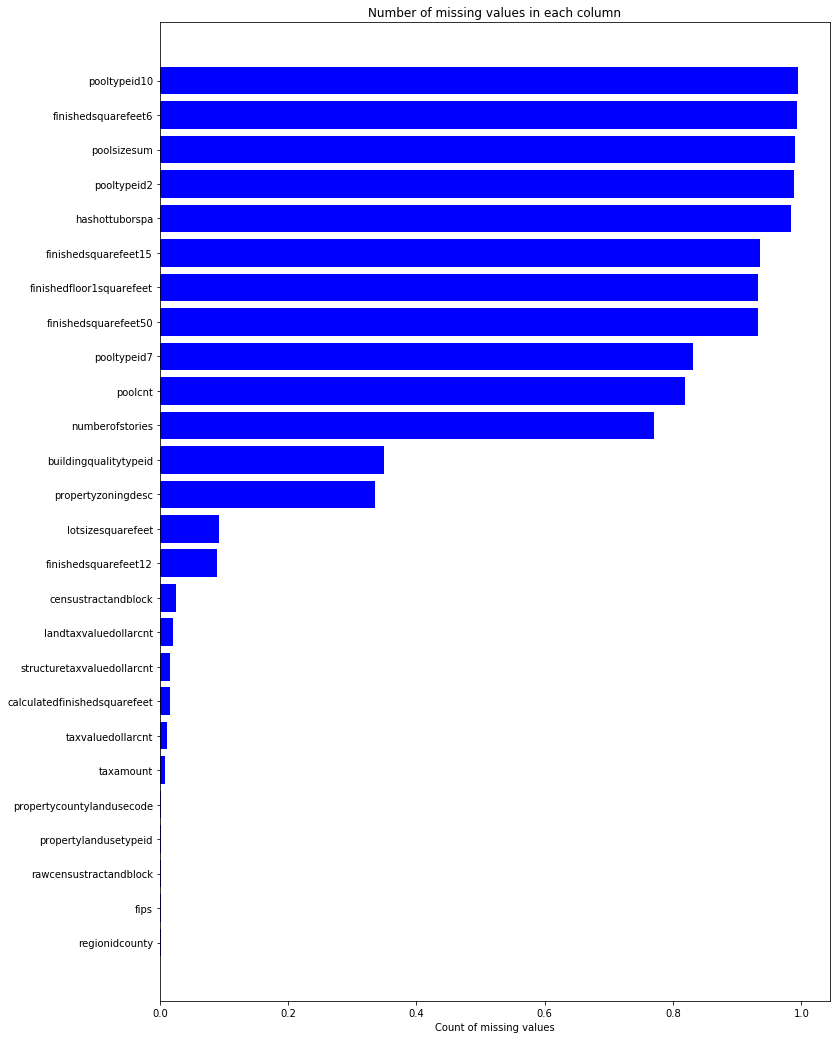

In [135]:
missing_2016_df = properties_2016_df.isnull().sum(axis=0).reset_index()
missing_2016_df.columns = ['column_name', 'missing_pct']
missing_2016_df = missing_2016_df.loc[missing_2016_df['missing_pct']>0]
missing_2016_df['missing_pct'] = missing_2016_df['missing_pct'] / length_properties_2016
missing_2016_df = missing_2016_df.sort_values(by='missing_pct')
ind = np.arange(missing_2016_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind, missing_2016_df.missing_pct.values, color='blue')
ax.set_yticks(ind)
ax.set_yticklabels(missing_2016_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")
plt.show()

missing_2017_df = properties_2017_df.isnull().sum(axis=0).reset_index()
missing_2017_df.columns = ['column_name', 'missing_pct']
missing_2017_df = missing_2017_df.loc[missing_2017_df['missing_pct']>0]
missing_2017_df['missing_pct'] = missing_2017_df['missing_pct'] / length_properties_2017
missing_2017_df = missing_2017_df.sort_values(by='missing_pct')
ind = np.arange(missing_2017_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind, missing_2017_df.missing_pct.values, color='blue')
ax.set_yticks(ind)
ax.set_yticklabels(missing_2017_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")
plt.show()

_Now let's try 'taxamount'._

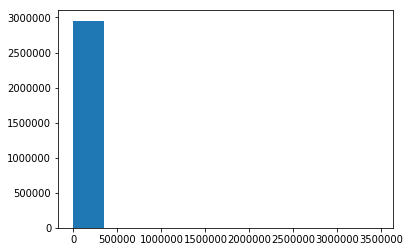

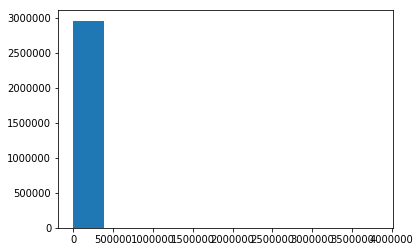

In [136]:
values = properties_2016_df[np.isfinite(properties_2016_df['taxamount'])].taxamount.values

plt.close()
plt.hist(values)
plt.show()

values = properties_2017_df[np.isfinite(properties_2017_df['taxamount'])].taxamount.values

plt.close()
plt.hist(values)
plt.show()

In [137]:
fillna_knr( df = properties_2017_df,
                  base = [ 'latitude', 'longitude' ] ,
                  target = 'taxamount')

fillna_knr( df = properties_2016_df,
                  base = [ 'latitude', 'longitude' ] ,
                  target = 'taxamount')

DEBUG:root:FITTING...
DEBUG:root:PREDICTING...
DEBUG:root:[ 14369.888   2692.904  14207.576 ...,   4428.76    8959.448   5909.878]
DEBUG:root:22752, 22752
DEBUG:root:POPULATING...
DEBUG:root:FITTING...
DEBUG:root:PREDICTING...
DEBUG:root:[ 14369.888   4273.212  14207.576 ...,   1612.912   1612.912   1612.912]
DEBUG:root:31250, 31250
DEBUG:root:POPULATING...


_More taxes! 'taxvaluedollarcnt'._

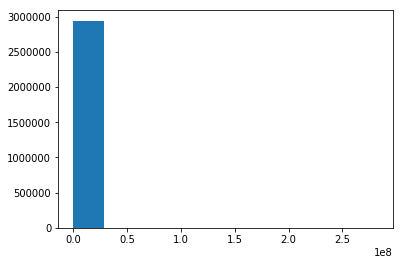

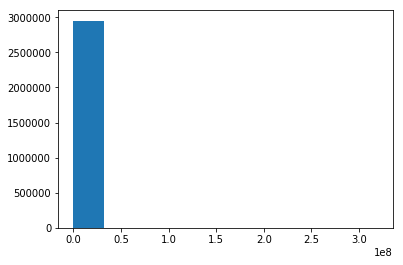

In [138]:
values = properties_2016_df[np.isfinite(properties_2016_df['taxvaluedollarcnt'])].taxvaluedollarcnt.values

plt.close()
plt.hist(values)
plt.show()

values = properties_2017_df[np.isfinite(properties_2017_df['taxvaluedollarcnt'])].taxvaluedollarcnt.values

plt.close()
plt.hist(values)
plt.show()

In [139]:
fillna_knr( df = properties_2017_df,
                  base = [ 'latitude', 'longitude' ] ,
                  target = 'taxvaluedollarcnt')

fillna_knr( df = properties_2016_df,
                  base = [ 'latitude', 'longitude' ] ,
                  target = 'taxvaluedollarcnt')

DEBUG:root:FITTING...
DEBUG:root:PREDICTING...
DEBUG:root:[ 131372.2  131372.2  207355.4 ...,  397343.8  837661.6  423708.2]
DEBUG:root:34266, 34266
DEBUG:root:POPULATING...
DEBUG:root:FITTING...
DEBUG:root:PREDICTING...
DEBUG:root:[ 129400.   129400.   177407.  ...,  116050.8  116050.8  116050.8]
DEBUG:root:42550, 42550
DEBUG:root:POPULATING...


_AND MORE TAXES! 'structuretaxvaluedollarcnt'._

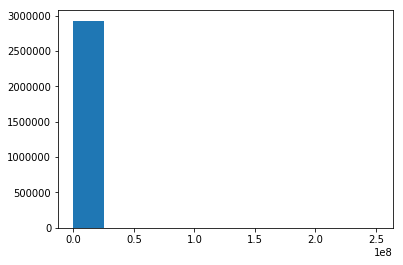

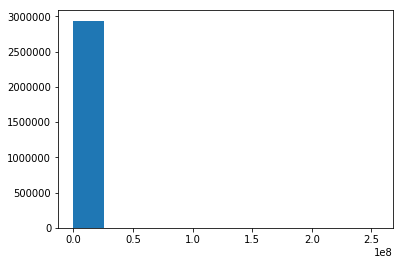

In [140]:
values = properties_2016_df[np.isfinite(properties_2016_df['structuretaxvaluedollarcnt'])].structuretaxvaluedollarcnt.values

plt.close()
plt.hist(values)
plt.show()

values = properties_2017_df[np.isfinite(properties_2017_df['structuretaxvaluedollarcnt'])].structuretaxvaluedollarcnt.values

plt.close()
plt.hist(values)
plt.show()

In [141]:
fillna_knr( df = properties_2017_df,
                  base = [ 'latitude', 'longitude' ] ,
                  target = 'structuretaxvaluedollarcnt')

fillna_knr( df = properties_2016_df,
                  base = [ 'latitude', 'longitude' ] ,
                  target = 'structuretaxvaluedollarcnt')

DEBUG:root:FITTING...
DEBUG:root:PREDICTING...
DEBUG:root:[ 573937.2   75064.8  612128.2 ...,  169069.8  600342.6  198365.8]
DEBUG:root:46464, 46464
DEBUG:root:POPULATING...
DEBUG:root:FITTING...
DEBUG:root:PREDICTING...
DEBUG:root:[ 538534.8   96049.   602934.  ...,   67890.8   67890.8   67890.8]
DEBUG:root:54982, 54982
DEBUG:root:POPULATING...


_AND EVEN MORE TAXES... MY GOSH! 'landtaxvaluedollarcnt'._

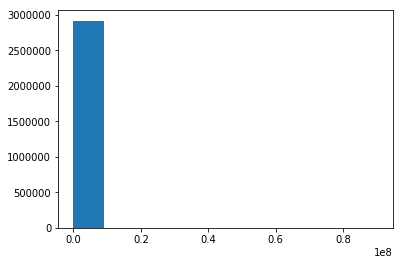

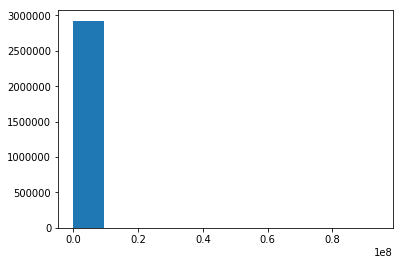

In [142]:
values = properties_2016_df[np.isfinite(properties_2016_df['landtaxvaluedollarcnt'])].landtaxvaluedollarcnt.values

plt.close()
plt.hist(values)
plt.show()

values = properties_2017_df[np.isfinite(properties_2017_df['landtaxvaluedollarcnt'])].landtaxvaluedollarcnt.values

plt.close()
plt.hist(values)
plt.show()

In [143]:
fillna_knr( df = properties_2017_df,
                  base = [ 'latitude', 'longitude' ] ,
                  target = 'landtaxvaluedollarcnt')

fillna_knr( df = properties_2016_df,
                  base = [ 'latitude', 'longitude' ] ,
                  target = 'landtaxvaluedollarcnt')

DEBUG:root:FITTING...
DEBUG:root:PREDICTING...
DEBUG:root:[  28885.8   28885.8  125126.6 ...,  228274.   237319.   225342.4]
DEBUG:root:59926, 59926
DEBUG:root:POPULATING...
DEBUG:root:FITTING...
DEBUG:root:PREDICTING...
DEBUG:root:[  28452.6   28452.6  112405.2 ...,   48160.    48160.    48160. ]
DEBUG:root:67733, 67733
DEBUG:root:POPULATING...


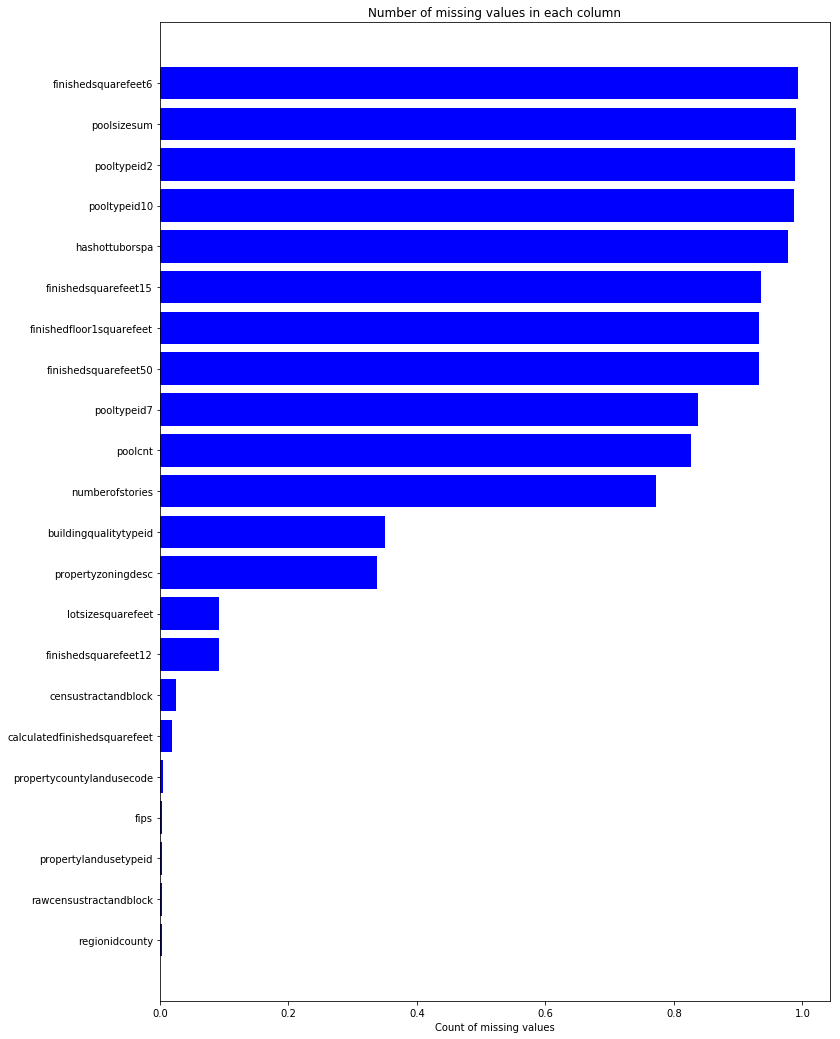

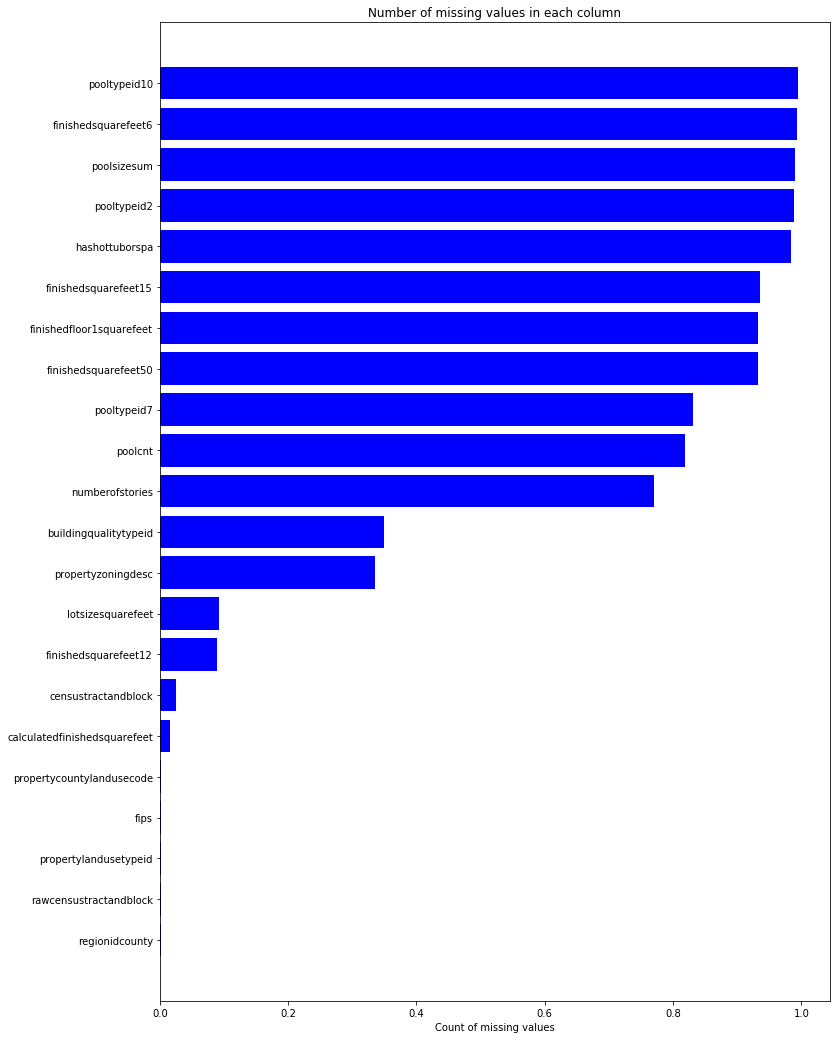

In [144]:
missing_2016_df = properties_2016_df.isnull().sum(axis=0).reset_index()
missing_2016_df.columns = ['column_name', 'missing_pct']
missing_2016_df = missing_2016_df.loc[missing_2016_df['missing_pct']>0]
missing_2016_df['missing_pct'] = missing_2016_df['missing_pct'] / length_properties_2016
missing_2016_df = missing_2016_df.sort_values(by='missing_pct')
ind = np.arange(missing_2016_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind, missing_2016_df.missing_pct.values, color='blue')
ax.set_yticks(ind)
ax.set_yticklabels(missing_2016_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")
plt.show()

missing_2017_df = properties_2017_df.isnull().sum(axis=0).reset_index()
missing_2017_df.columns = ['column_name', 'missing_pct']
missing_2017_df = missing_2017_df.loc[missing_2017_df['missing_pct']>0]
missing_2017_df['missing_pct'] = missing_2017_df['missing_pct'] / length_properties_2017
missing_2017_df = missing_2017_df.sort_values(by='missing_pct')
ind = np.arange(missing_2017_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind, missing_2017_df.missing_pct.values, color='blue')
ax.set_yticks(ind)
ax.set_yticklabels(missing_2017_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")
plt.show()

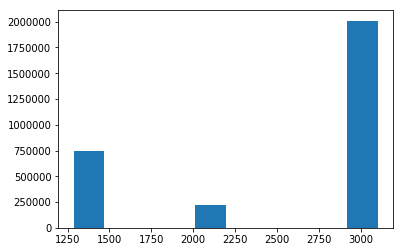

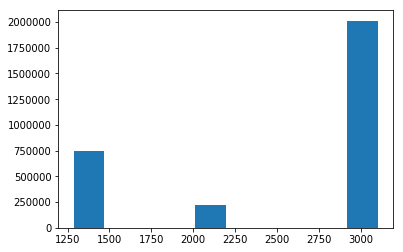

In [146]:
values = properties_2016_df[np.isfinite(properties_2016_df['regionidcounty'])].regionidcounty.values

plt.close()
plt.hist(values)
plt.show()

values = properties_2017_df[np.isfinite(properties_2017_df['regionidcounty'])].regionidcounty.values

plt.close()
plt.hist(values)
plt.show()

In [147]:
fillna_knn( df = properties_2017_df,
                  base = [ 'latitude', 'longitude' ] ,
                  target = 'regionidcounty')

fillna_knn( df = properties_2016_df,
                  base = [ 'latitude', 'longitude' ] ,
                  target = 'regionidcounty')

DEBUG:root:FITTING...
DEBUG:root:PREDICTING...
DEBUG:root:[ 3101.  3101.  3101. ...,  2061.  1286.  3101.]
DEBUG:root:2932, 2932
DEBUG:root:POPULATING...
DEBUG:root:FITTING...
DEBUG:root:PREDICTING...
DEBUG:root:[ 3101.  3101.  3101. ...,  3101.  3101.  3101.]
DEBUG:root:11437, 11437
DEBUG:root:POPULATING...


DEBUG:root:[ 60378002.041       60378001.011002    60377030.012017   ...,
  60371835.103002    61110073.0010734   60375013.00301041]


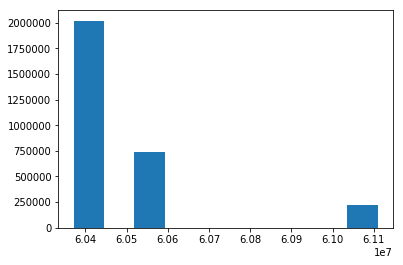

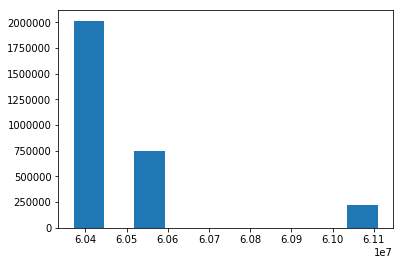

In [152]:
values = properties_2016_df[np.isfinite(properties_2016_df['rawcensustractandblock'])].rawcensustractandblock.values

plt.close()
plt.hist(values)
plt.show()

values = properties_2017_df[np.isfinite(properties_2017_df['rawcensustractandblock'])].rawcensustractandblock.values

plt.close()
plt.hist(values)
plt.show()

In [149]:
fillna_knr( df = properties_2017_df,
                  base = [ 'latitude', 'longitude' ] ,
                  target = 'rawcensustractandblock')

fillna_knr( df = properties_2016_df,
                  base = [ 'latitude', 'longitude' ] ,
                  target = 'rawcensustractandblock')

DEBUG:root:FITTING...
DEBUG:root:PREDICTING...
DEBUG:root:[ 60379003.001007   60379003.001007   60379003.001007  ...,
  61110076.131015   60590758.071005   60374339.0130008]
DEBUG:root:2932, 2932
DEBUG:root:POPULATING...
DEBUG:root:FITTING...
DEBUG:root:PREDICTING...
DEBUG:root:[ 60379110.011023    60372976.02100799  60379200.1330024  ...,
  60379110.011023    60379110.011023    60379110.011023  ]
DEBUG:root:11437, 11437
DEBUG:root:POPULATING...


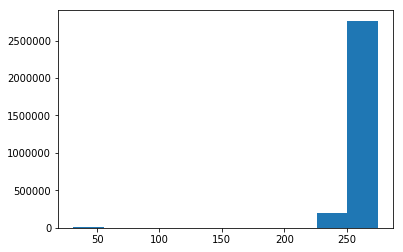

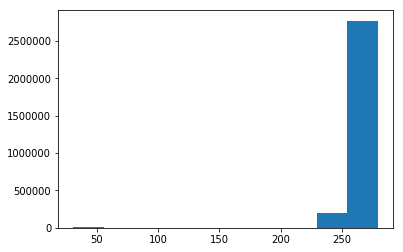

In [150]:
values = properties_2016_df[np.isfinite(properties_2016_df['propertylandusetypeid'])].propertylandusetypeid.values

plt.close()
plt.hist(values)
plt.show()

values = properties_2017_df[np.isfinite(properties_2017_df['propertylandusetypeid'])].propertylandusetypeid.values

plt.close()
plt.hist(values)
plt.show()

In [153]:
fillna_knn( df = properties_2017_df,
                  base = [ 'latitude', 'longitude' ] ,
                  target = 'propertylandusetypeid')

fillna_knn( df = properties_2016_df,
                  base = [ 'latitude', 'longitude' ] ,
                  target = 'propertylandusetypeid')

DEBUG:root:FITTING...
DEBUG:root:PREDICTING...
DEBUG:root:[ 263.  263.  263. ...,  261.  261.  269.]
DEBUG:root:2932, 2932
DEBUG:root:POPULATING...
DEBUG:root:FITTING...
DEBUG:root:PREDICTING...
DEBUG:root:[  31.  261.  261. ...,   31.   31.   31.]
DEBUG:root:11437, 11437
DEBUG:root:POPULATING...


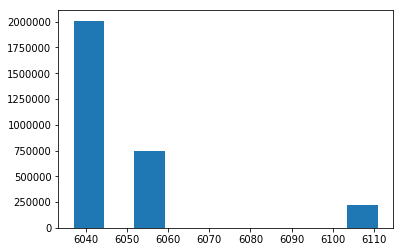

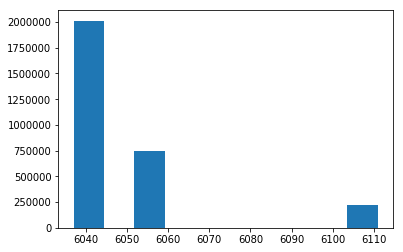

In [154]:
values = properties_2016_df[np.isfinite(properties_2016_df['fips'])].fips.values

plt.close()
plt.hist(values)
plt.show()

values = properties_2017_df[np.isfinite(properties_2017_df['fips'])].fips.values

plt.close()
plt.hist(values)
plt.show()

In [155]:
fillna_knn( df = properties_2017_df,
                  base = [ 'latitude', 'longitude' ] ,
                  target = 'fips')

fillna_knn( df = properties_2016_df,
                  base = [ 'latitude', 'longitude' ] ,
                  target = 'fips')

DEBUG:root:FITTING...
DEBUG:root:PREDICTING...
DEBUG:root:[ 6037.  6037.  6037. ...,  6111.  6059.  6037.]
DEBUG:root:2932, 2932
DEBUG:root:POPULATING...
DEBUG:root:FITTING...
DEBUG:root:PREDICTING...
DEBUG:root:[ 6037.  6037.  6037. ...,  6037.  6037.  6037.]
DEBUG:root:11437, 11437
DEBUG:root:POPULATING...


_Let's see if it the knn works for the categorical variables too. We'll begin with 'propertycountylandusecode' and then move on to 'censustractandblock'._

In [156]:
unique = properties_2016_df['propertycountylandusecode'].unique()

logging.debug(unique)

unique = properties_2017_df['propertycountylandusecode'].unique()

logging.debug(unique)

DEBUG:root:['010D' '0109' '1200' '1210' '010V' '300V' '0100' '0200' '010C' '0300'
 '1204' '100V' '01HC' '120C' '040V' '1214' '0101' nan '070P' '0700' '1'
 '128' '0' '1112' '5050' '1110' '1118' '010E' '1111' '1129' '1420' '1222'
 '1128' '1310' '1117' '1333' '1116' '1410' '0104' '070D' '0108' '012C'
 '0400' '0103' '01DC' '0201' '010M' '030V' '0110' '010F' '010G' '010H'
 '0301' '0102' '020E' '020M' '0401' '0113' '0141' '122' '38' '135' '96'
 '71' '73' '34' '0209' '040G' '010L' '012E' '0111' '1720' '1014' '012D'
 '1213' '1201' '1321' '1444' '1421' '0140' '0123' '0133' '020G' '030G'
 '105' '0204' '010T' '0120' '1202' '121G' '010X' '020V' '880V' '1120'
 '0130' '0118' '01HE' '120G' '5060' '0131' '0203' '011C' '1215' '1212'
 '040D' '120T' '0420' '8' '1203' '070X' '0114' '030E' '121T' '1012' '121C'
 '0105' '5' '020C' '0106' '040B' '10E' '1216' '3' '0121' '1722' '1432'
 '1119' '9000' '103' '6050' '8800' '0304' '0303' '172C' '1011' '070V'
 '0309' '030C' '1211' '020X' '84' '070L' '12TO' '121L' '07

In [157]:
fillna_knn( df = properties_2017_df,
                  base = [ 'latitude', 'longitude' ] ,
                  target = 'propertycountylandusecode')

fillna_knn( df = properties_2016_df,
                  base = [ 'latitude', 'longitude' ] ,
                  target = 'propertycountylandusecode')

DEBUG:root:FITTING...
DEBUG:root:PREDICTING...
DEBUG:root:['122' '96' '122' ..., '1110' '122' '010D']
DEBUG:root:2999, 2999
DEBUG:root:POPULATING...
DEBUG:root:FITTING...
DEBUG:root:PREDICTING...
DEBUG:root:['0100' '0100' '0100' ..., '1210' '1210' '1210']
DEBUG:root:12277, 12277
DEBUG:root:POPULATING...


_Not bad! It looks like it works! And 'censustractandblock' isn't even a categorical one anyway._

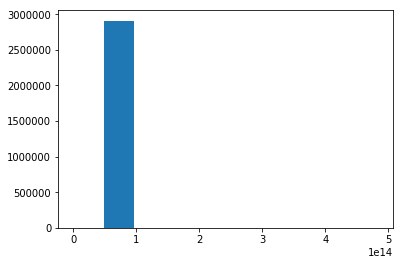

DEBUG:root:[  6.11100100e+13   6.11100090e+13   6.11100100e+13 ...,   6.05909924e+13
   6.05906264e+13   6.03790121e+13]


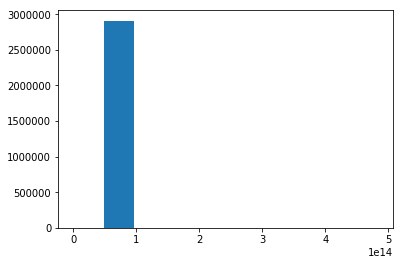

In [159]:
values = properties_2016_df[np.isfinite(properties_2016_df['censustractandblock'])].censustractandblock.values

plt.close()
plt.hist(values)
plt.show()

values = properties_2017_df[np.isfinite(properties_2017_df['censustractandblock'])].censustractandblock.values

plt.close()
plt.hist(values)
plt.show()

In [160]:
fillna_knn( df = properties_2017_df,
                  base = [ 'latitude', 'longitude' ] ,
                  target = 'censustractandblock')

fillna_knn( df = properties_2016_df,
                  base = [ 'latitude', 'longitude' ] ,
                  target = 'censustractandblock')

DEBUG:root:FITTING...
DEBUG:root:PREDICTING...
DEBUG:root:[  6.03780020e+13   6.03780010e+13   6.03770260e+13 ...,   6.11100761e+13
   6.05907581e+13   6.03743390e+13]
DEBUG:root:74985, 74985
DEBUG:root:POPULATING...
DEBUG:root:FITTING...
DEBUG:root:PREDICTING...
DEBUG:root:[  6.03780020e+13   6.03780010e+13   6.03770260e+13 ...,   6.03791100e+13
   6.03791100e+13   6.03791100e+13]
DEBUG:root:75126, 75126
DEBUG:root:POPULATING...


_Let's take one more look and then write out our progress._

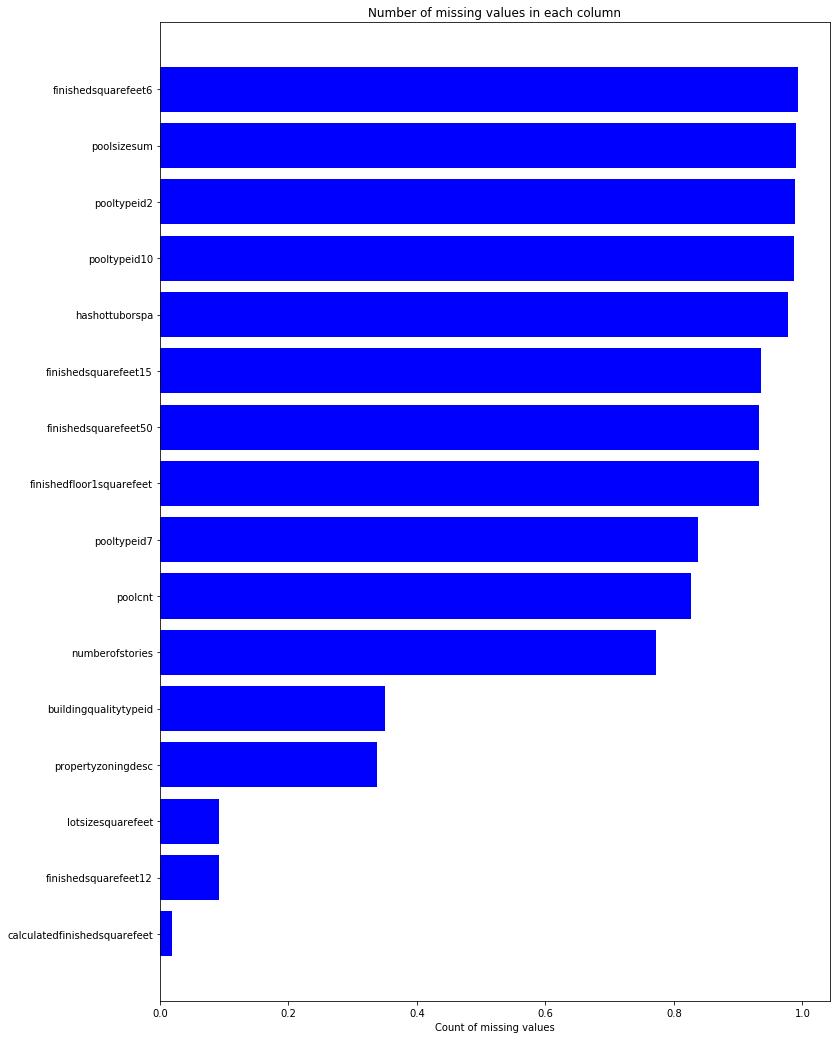

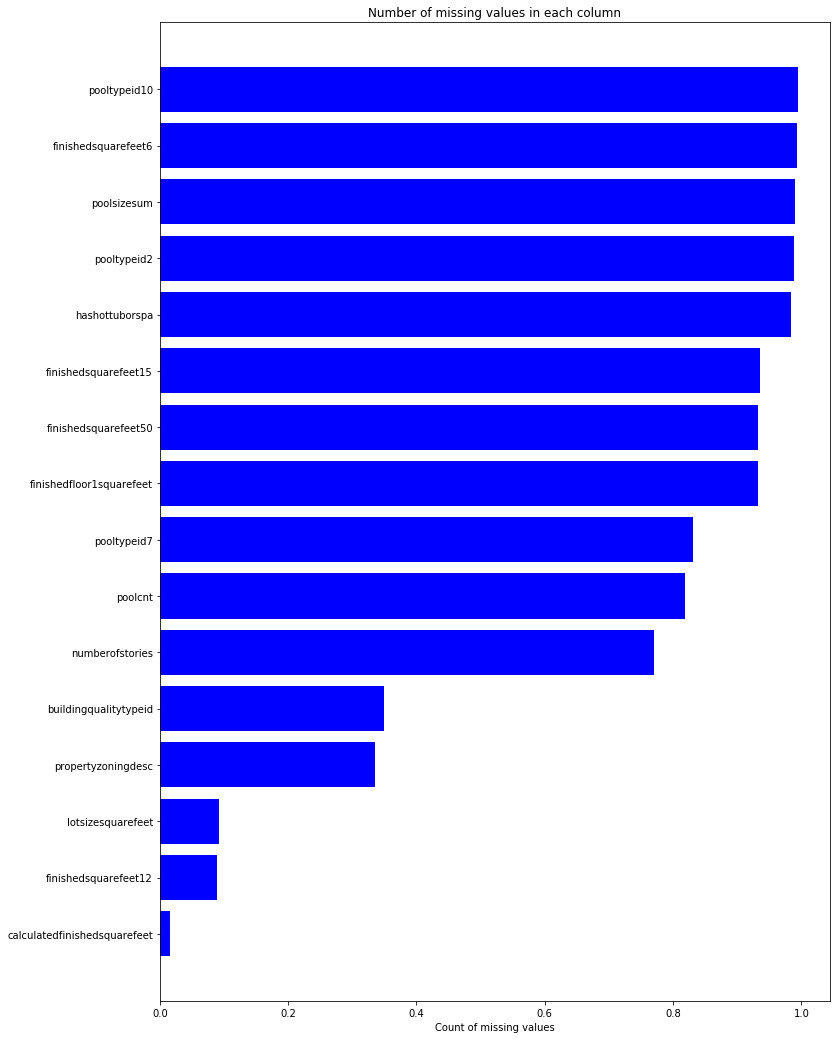

In [161]:
missing_2016_df = properties_2016_df.isnull().sum(axis=0).reset_index()
missing_2016_df.columns = ['column_name', 'missing_pct']
missing_2016_df = missing_2016_df.loc[missing_2016_df['missing_pct']>0]
missing_2016_df['missing_pct'] = missing_2016_df['missing_pct'] / length_properties_2016
missing_2016_df = missing_2016_df.sort_values(by='missing_pct')
ind = np.arange(missing_2016_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind, missing_2016_df.missing_pct.values, color='blue')
ax.set_yticks(ind)
ax.set_yticklabels(missing_2016_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")
plt.show()

missing_2017_df = properties_2017_df.isnull().sum(axis=0).reset_index()
missing_2017_df.columns = ['column_name', 'missing_pct']
missing_2017_df = missing_2017_df.loc[missing_2017_df['missing_pct']>0]
missing_2017_df['missing_pct'] = missing_2017_df['missing_pct'] / length_properties_2017
missing_2017_df = missing_2017_df.sort_values(by='missing_pct')
ind = np.arange(missing_2017_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind, missing_2017_df.missing_pct.values, color='blue')
ax.set_yticks(ind)
ax.set_yticklabels(missing_2017_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")
plt.show()

_Oh yea. We need to drop 'buildingqualitytypeid' still._

In [162]:
del properties_2017_df['buildingqualitytypeid']
del properties_2016_df['buildingqualitytypeid']

_And we can still knock out 'propertyzoningdesc'._

In [163]:
unique = properties_2016_df['propertyzoningdesc'].unique()

logging.debug(unique)

unique = properties_2017_df['propertyzoningdesc'].unique()

logging.debug(unique)

DEBUG:root:[nan 'LCA11*' 'LAC2' ..., 'WCR1400000' 'EMPYYY' 'RMM2*']
DEBUG:root:[nan 'LCA11*' 'LAC2' ..., 'WCR1400000' 'EMPYYY' 'RMM2*']


In [164]:
fillna_knn( df = properties_2017_df,
                  base = [ 'latitude', 'longitude' ] ,
                  target = 'propertyzoningdesc')

fillna_knn( df = properties_2016_df,
                  base = [ 'latitude', 'longitude' ] ,
                  target = 'propertyzoningdesc')

DEBUG:root:FITTING...
DEBUG:root:PREDICTING...
DEBUG:root:['LCRPD12U*' 'LRR6000*' 'LRR6000*' ..., 'WVA21*' 'LCR19000*' 'EMC4*']
DEBUG:root:1002746, 1002746
DEBUG:root:POPULATING...
DEBUG:root:FITTING...
DEBUG:root:PREDICTING...
DEBUG:root:['LCRPD12U*' 'LAR1' 'LAR1' ..., 'LCC3*' 'LCC3*' 'LCC3*']
DEBUG:root:1006588, 1006588
DEBUG:root:POPULATING...


In [165]:
properties_2016_df.to_csv("Input/properties_2016_mod.csv", sep=',', encoding='utf-8', index=False)
properties_2017_df.to_csv("Input/properties_2017_mod.csv", sep=',', encoding='utf-8', index=False)

_So now we're left with square footage and pool features to deal with._

_Let's pick off 'lotsizesquarefeet'._

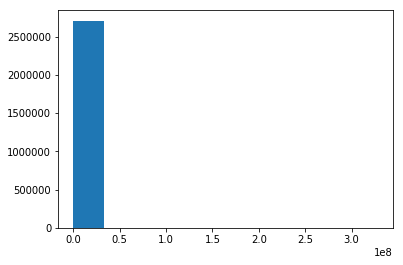

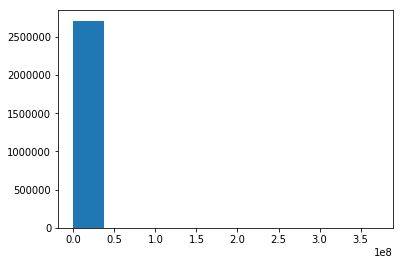

In [166]:
values = properties_2016_df[np.isfinite(properties_2016_df['lotsizesquarefeet'])].lotsizesquarefeet.values

plt.close()
plt.hist(values)
plt.show()

values = properties_2017_df[np.isfinite(properties_2017_df['lotsizesquarefeet'])].lotsizesquarefeet.values

plt.close()
plt.hist(values)
plt.show()

In [167]:
fillna_knr( df = properties_2017_df,
                  base = [ 'latitude', 'longitude' ] ,
                  target = 'lotsizesquarefeet')

fillna_knr( df = properties_2016_df,
                  base = [ 'latitude', 'longitude' ] ,
                  target = 'lotsizesquarefeet')

DEBUG:root:FITTING...
DEBUG:root:PREDICTING...
DEBUG:root:[  4802.2   6971.2  17770.6 ...,  22683.   16395.8  15961.8]
DEBUG:root:272706, 272706
DEBUG:root:POPULATING...
DEBUG:root:FITTING...
DEBUG:root:PREDICTING...
DEBUG:root:[  4802.2  17770.6   5701.  ...,  34132.2  34132.2  34132.2]
DEBUG:root:276099, 276099
DEBUG:root:POPULATING...


In [175]:
pool_vars = ['poolcnt', 'pooltypeid7', 'hashottuborspa', 'pooltypeid2', 'poolsizesum', 'pooltypeid10']

for v in pool_vars:
    logging.debug(properties_2016_df[v].unique())
    
for v in pool_vars:
    logging.debug(properties_2017_df[v].unique())

DEBUG:root:[ nan   1.]
DEBUG:root:[ nan   1.]
DEBUG:root:[ nan   1.]
DEBUG:root:[ nan   1.]
DEBUG:root:[    nan    800.    450.    503.    735.    903.    400.     70.    648.
    645.    475.    324.    610.    840.    576.    720.    640.    449.
    702.    448.    420.    385.    629.    782.    360.    578.    480.
    496.    380.    490.    810.    390.    529.    429.    560.    691.
    555.    512.    723.    570.    518.     64.    680.    350.    627.
    541.    404.    320.    630.    600.    684.    376.    750.    352.
    590.    410.    900.    761.    525.    469.    342.    442.    620.
    540.    660.    462.    440.    220.    579.   1064.    588.    563.
    384.    739.    486.    435.    405.    554.    599.    888.    264.
    700.    756.    544.    527.    375.    520.    472.    632.    495.
    272.    614.    500.    457.    467.    325.    432.    510.    795.
    558.    575.    370.    580.    392.    550.    538.    240.    300.
    557.    583.    9

DEBUG:root:[ nan   1.]


In [174]:
properties_2016_df['hashottuborspa'] = properties_2016_df['hashottuborspa'].replace([True], 1)
properties_2017_df['hashottuborspa'] = properties_2017_df['hashottuborspa'].replace([True], 1)

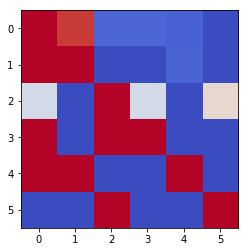

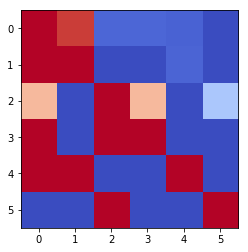

In [176]:
pool_vars = ['poolcnt', 'pooltypeid7', 'hashottuborspa', 'pooltypeid2', 'poolsizesum', 'pooltypeid10']
l = len(pool_vars)
arr = np.zeros((l, l))

for i in range(len(pool_vars)):
    for j in range(len(pool_vars)):
        
        similarity = properties_2016_df[np.isfinite(properties_2016_df[pool_vars[i]]) & np.isfinite(properties_2016_df[pool_vars[j]])][pool_vars[i]].values
        arr[i, j] = similarity.shape[0] / properties_2016_df[np.isfinite(properties_2016_df[pool_vars[i]])].values.shape[0]

plt.close()
plt.imshow(arr, cmap='coolwarm')
plt.show()

pool_vars = ['poolcnt', 'pooltypeid7', 'hashottuborspa', 'pooltypeid2', 'poolsizesum', 'pooltypeid10']
l = len(pool_vars)
arr = np.zeros((l, l))

for i in range(len(pool_vars)):
    for j in range(len(pool_vars)):
        
        similarity = properties_2017_df[np.isfinite(properties_2017_df[pool_vars[i]]) & np.isfinite(properties_2017_df[pool_vars[j]])][pool_vars[i]].values
        arr[i, j] = similarity.shape[0] / properties_2017_df[np.isfinite(properties_2017_df[pool_vars[i]])].values.shape[0]

plt.close()
plt.imshow(arr, cmap='coolwarm')
plt.show()

_Interesting. Let's piece together the pool data first. Let's combine the two pool variables into a variable 'haspool'. Also, it appears that the 'poolcnt' variable containes both pools and hottubs. We'll confirm this soon._

In [177]:
properties_2017_df['haspool'] = properties_2017_df['pooltypeid7']
properties_2017_df.loc[np.isfinite(properties_2017_df['pooltypeid2']), 'haspool'] = properties_2017_df[np.isfinite(properties_2017_df['pooltypeid2'])]['pooltypeid2'].values

properties_2016_df['haspool'] = properties_2016_df['pooltypeid7']
properties_2016_df.loc[np.isfinite(properties_2016_df['pooltypeid2']), 'haspool'] = properties_2016_df[np.isfinite(properties_2016_df['pooltypeid2'])]['pooltypeid2'].values

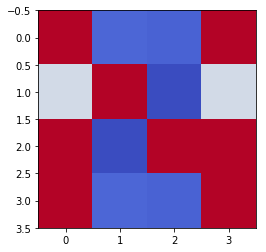

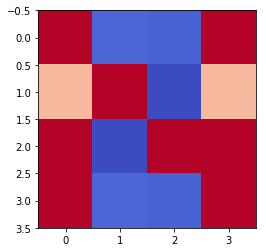

In [178]:
pool_vars = ['poolcnt', 'hashottuborspa', 'poolsizesum', 'haspool']
l = len(pool_vars)
arr = np.zeros((l, l))

for i in range(len(pool_vars)):
    for j in range(len(pool_vars)):
        
        similarity = properties_2016_df[np.isfinite(properties_2016_df[pool_vars[i]]) & np.isfinite(properties_2016_df[pool_vars[j]])][pool_vars[i]].values
        arr[i, j] = similarity.shape[0] / properties_2016_df[np.isfinite(properties_2016_df[pool_vars[i]])].values.shape[0]

plt.close()
plt.imshow(arr, cmap='coolwarm')
plt.show()

pool_vars = ['poolcnt', 'hashottuborspa', 'poolsizesum', 'haspool']
l = len(pool_vars)
arr = np.zeros((l, l))

for i in range(len(pool_vars)):
    for j in range(len(pool_vars)):
        
        similarity = properties_2017_df[np.isfinite(properties_2017_df[pool_vars[i]]) & np.isfinite(properties_2017_df[pool_vars[j]])][pool_vars[i]].values
        arr[i, j] = similarity.shape[0] / properties_2017_df[np.isfinite(properties_2017_df[pool_vars[i]])].values.shape[0]

plt.close()
plt.imshow(arr, cmap='coolwarm')
plt.show()

_So, we have several things to look at. First of all, we can now get rid of the two pooltype* variables because they are now encompassed by 'hashottuborspa' and 'haspool'._

In [179]:
del properties_2017_df['pooltypeid2']
del properties_2016_df['pooltypeid2']

del properties_2017_df['pooltypeid7']
del properties_2016_df['pooltypeid7']

del properties_2017_df['pooltypeid10']
del properties_2016_df['pooltypeid10']

_Now we can see that 'poolcnt' and 'haspool' overlap so we can delete 'poolcnt'._

In [180]:
del properties_2017_df['poolcnt']
del properties_2016_df['poolcnt']

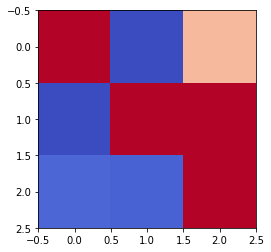

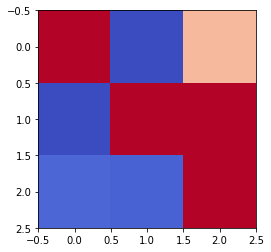

In [181]:
pool_vars = ['hashottuborspa', 'poolsizesum', 'haspool']
l = len(pool_vars)
arr = np.zeros((l, l))

for i in range(len(pool_vars)):
    for j in range(len(pool_vars)):
        
        similarity = properties_2017_df[np.isfinite(properties_2017_df[pool_vars[i]]) & np.isfinite(properties_2017_df[pool_vars[j]])][pool_vars[i]].values
        arr[i, j] = similarity.shape[0] / properties_2017_df[np.isfinite(properties_2017_df[pool_vars[i]])].values.shape[0]

plt.close()
plt.imshow(arr, cmap='coolwarm')
plt.show()

l = len(pool_vars)
arr = np.zeros((l, l))

for i in range(len(pool_vars)):
    for j in range(len(pool_vars)):
        
        similarity = properties_2017_df[np.isfinite(properties_2017_df[pool_vars[i]]) & np.isfinite(properties_2017_df[pool_vars[j]])][pool_vars[i]].values
        arr[i, j] = similarity.shape[0] / properties_2017_df[np.isfinite(properties_2017_df[pool_vars[i]])].values.shape[0]

plt.close()
plt.imshow(arr, cmap='coolwarm')
plt.show()

_Let's flesh out the two 'has*' variables._

In [182]:
properties_2017_df['hashottuborspa'] = properties_2017_df['hashottuborspa'].fillna(0)
properties_2016_df['hashottuborspa'] = properties_2016_df['hashottuborspa'].fillna(0)

properties_2017_df['haspool'] = properties_2017_df['haspool'].fillna(0)
properties_2016_df['haspool'] = properties_2016_df['haspool'].fillna(0)

_So now let's use the knn function to fill out 'poolsizesum' for houses that have pools._

In [183]:
fillna_knr( df = properties_2017_df[properties_2017_df['haspool'] == 1],
                  base = [ 'latitude', 'longitude' ] ,
                  target = 'poolsizesum',
                  n_neighbors=1)

fillna_knr( df = properties_2016_df[properties_2016_df['haspool'] == 1],
                  base = [ 'latitude', 'longitude' ] ,
                  target = 'poolsizesum',
                  n_neighbors=1)

DEBUG:root:FITTING...
DEBUG:root:PREDICTING...
DEBUG:root:[ 760.  760.  600. ...,  760.  760.  760.]
DEBUG:root:510993, 510993
DEBUG:root:POPULATING...
/Users/admiral/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
DEBUG:root:FITTING...
DEBUG:root:PREDICTING...
DEBUG:root:[ 760.  760.  510. ...,  760.  760.  760.]
DEBUG:root:489574, 489574
DEBUG:root:POPULATING...


In [184]:
properties_2017_df['poolsizesum'] = properties_2017_df['poolsizesum'].fillna(0)
properties_2016_df['poolsizesum'] = properties_2016_df['poolsizesum'].fillna(0)

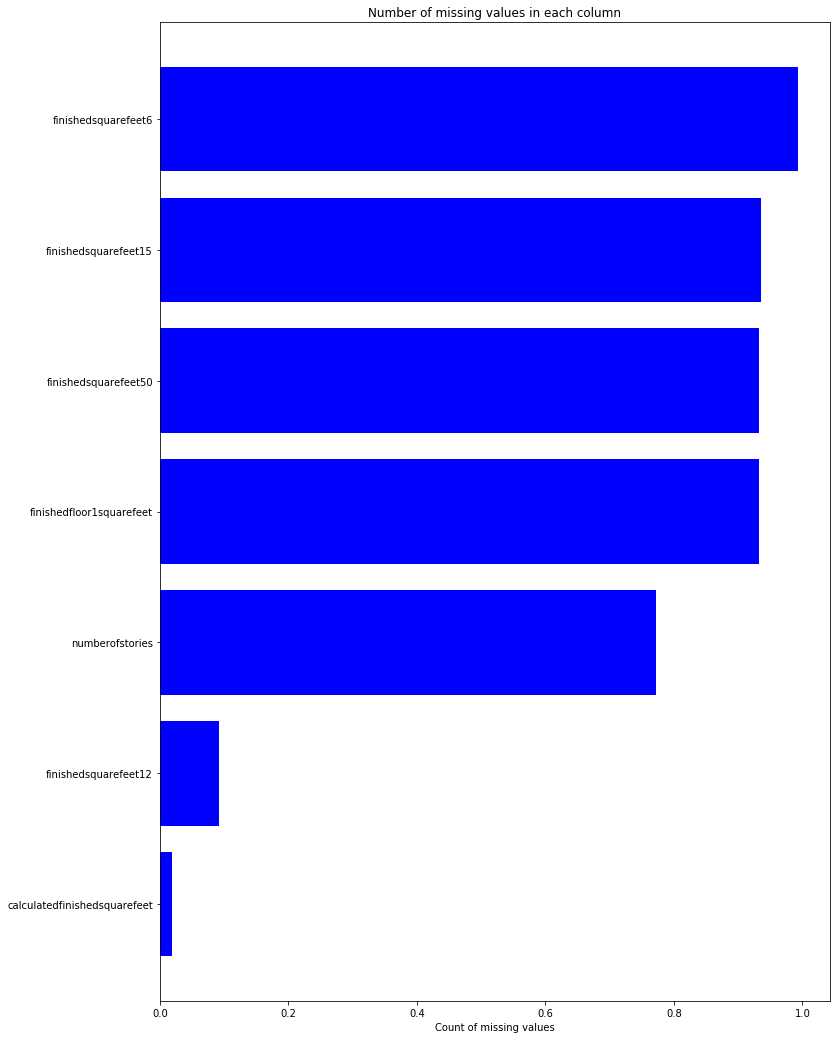

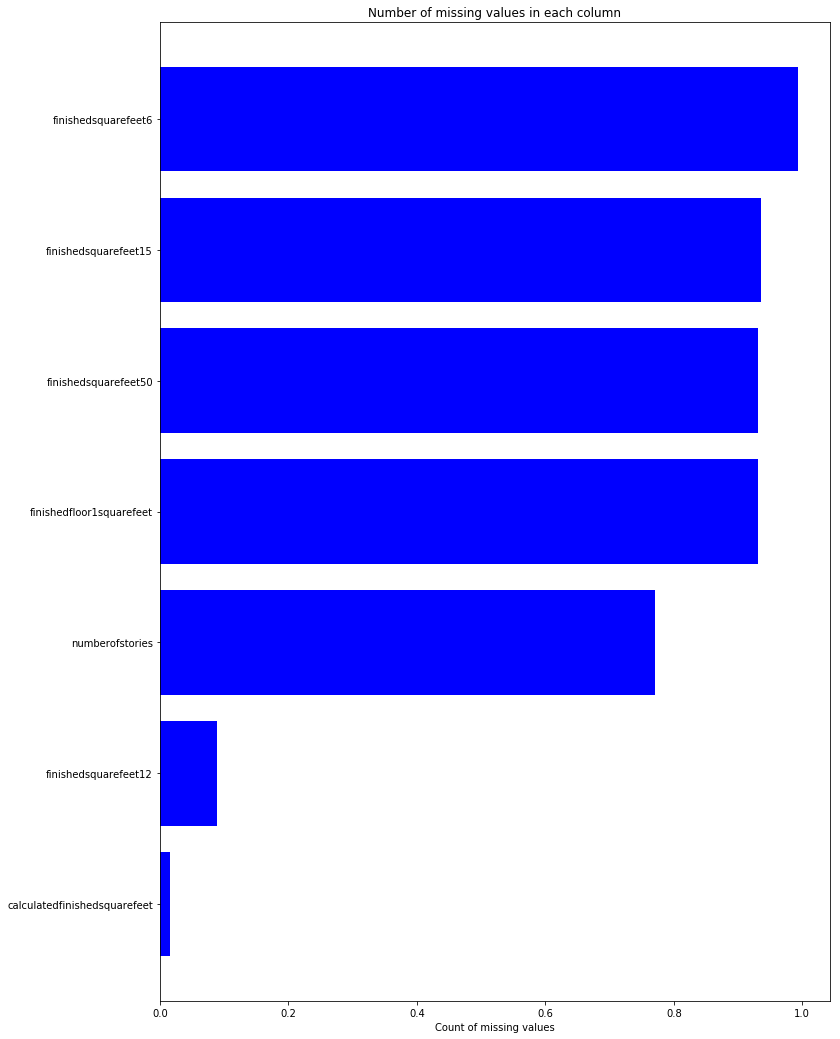

In [185]:
missing_2016_df = properties_2016_df.isnull().sum(axis=0).reset_index()
missing_2016_df.columns = ['column_name', 'missing_pct']
missing_2016_df = missing_2016_df.loc[missing_2016_df['missing_pct']>0]
missing_2016_df['missing_pct'] = missing_2016_df['missing_pct'] / length_properties_2016
missing_2016_df = missing_2016_df.sort_values(by='missing_pct')
ind = np.arange(missing_2016_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind, missing_2016_df.missing_pct.values, color='blue')
ax.set_yticks(ind)
ax.set_yticklabels(missing_2016_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")
plt.show()

missing_2017_df = properties_2017_df.isnull().sum(axis=0).reset_index()
missing_2017_df.columns = ['column_name', 'missing_pct']
missing_2017_df = missing_2017_df.loc[missing_2017_df['missing_pct']>0]
missing_2017_df['missing_pct'] = missing_2017_df['missing_pct'] / length_properties_2017
missing_2017_df = missing_2017_df.sort_values(by='missing_pct')
ind = np.arange(missing_2017_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind, missing_2017_df.missing_pct.values, color='blue')
ax.set_yticks(ind)
ax.set_yticklabels(missing_2017_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")
plt.show()

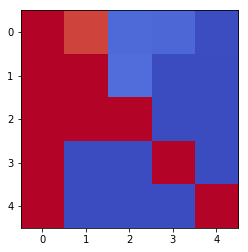

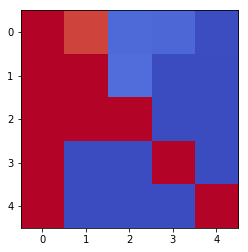

In [186]:
sqft_vars = ['calculatedfinishedsquarefeet', 'finishedsquarefeet12', 'finishedsquarefeet50', 'finishedsquarefeet15', 'finishedsquarefeet6']

l = len(sqft_vars)
arr = np.zeros((l, l))

for i in range(len(sqft_vars)):
    for j in range(len(sqft_vars)):
        
        similarity = properties_2016_df[np.isfinite(properties_2016_df[sqft_vars[i]]) & np.isfinite(properties_2016_df[sqft_vars[j]])][sqft_vars[i]].values
        arr[i, j] = similarity.shape[0] / properties_2016_df[np.isfinite(properties_2016_df[sqft_vars[i]])].values.shape[0]
        
plt.close()
plt.imshow(arr, cmap='coolwarm')
plt.show()

sqft_vars = ['calculatedfinishedsquarefeet', 'finishedsquarefeet12', 'finishedsquarefeet50', 'finishedsquarefeet15', 'finishedsquarefeet6']

l = len(sqft_vars)
arr = np.zeros((l, l))

for i in range(len(sqft_vars)):
    for j in range(len(sqft_vars)):
        
        similarity = properties_2017_df[np.isfinite(properties_2017_df[sqft_vars[i]]) & np.isfinite(properties_2017_df[sqft_vars[j]])][sqft_vars[i]].values
        arr[i, j] = similarity.shape[0] / properties_2017_df[np.isfinite(properties_2017_df[sqft_vars[i]])].values.shape[0]
        
plt.close()
plt.imshow(arr, cmap='coolwarm')
plt.show()



_So 2 and 3 are the exact same. Let's delete one._

In [187]:
del properties_2017_df['finishedfloor1squarefeet']
del properties_2016_df['finishedfloor1squarefeet']

In [ ]:
sqft_vars = ['calculatedfinishedsquarefeet', 'finishedsquarefeet12', 'finishedsquarefeet50', 'finishedsquarefeet15', 'finishedsquarefeet6']

l = len(sqft_vars)
arr = np.zeros((l, l))

for i in range(len(sqft_vars)):
    for j in range(len(sqft_vars)):
        
        similarity = properties_2017_df[np.isfinite(properties_2017_df[sqft_vars[i]]) & np.isfinite(properties_2017_df[sqft_vars[j]])][v].values
        arr[i, j] = similarity.shape[0] / properties_2017_df[np.isfinite(properties_2017_df[sqft_vars[i]])].values.shape[0]
        
plt.close()
plt.imshow(arr, cmap='coolwarm')
plt.show()


_These all seem to be incredibly redundant so I will remove all but 0 and 1 and then interpolate those values._

In [188]:
sqft_vars = ['finishedsquarefeet50', 'finishedsquarefeet15', 'finishedsquarefeet6']

for v in sqft_vars:
    del properties_2017_df[v]
    del properties_2016_df[v]

In [189]:
fillna_knr( df = properties_2017_df,
                  base = [ 'latitude', 'longitude' ] ,
                  target = 'calculatedfinishedsquarefeet',
                  n_neighbors=3)

fillna_knr( df = properties_2016_df,
                  base = [ 'latitude', 'longitude' ] ,
                  target = 'calculatedfinishedsquarefeet',
                  n_neighbors=3)

DEBUG:root:FITTING...
DEBUG:root:PREDICTING...
DEBUG:root:[ 4185.66666667   982.33333333  1581.         ...,  2174.66666667
  3148.66666667  1506.66666667]
DEBUG:root:45097, 45097
DEBUG:root:POPULATING...
DEBUG:root:FITTING...
DEBUG:root:PREDICTING...
DEBUG:root:[ 4185.66666667  1623.66666667  1581.         ...,  3219.33333333
  3219.33333333  3219.33333333]
DEBUG:root:55565, 55565
DEBUG:root:POPULATING...


In [190]:
fillna_knr( df = properties_2017_df,
                  base = [ 'latitude', 'longitude' ] ,
                  target = 'finishedsquarefeet12',
                  n_neighbors=3)

fillna_knr( df = properties_2016_df,
                  base = [ 'latitude', 'longitude' ] ,
                  target = 'finishedsquarefeet12',
                  n_neighbors=3)

DEBUG:root:FITTING...
DEBUG:root:PREDICTING...
DEBUG:root:[ 4185.66666667   982.33333333  7589.         ...,  2174.66666667
  3148.66666667  1506.66666667]
DEBUG:root:264431, 264431
DEBUG:root:POPULATING...
DEBUG:root:FITTING...
DEBUG:root:PREDICTING...
DEBUG:root:[ 4185.66666667  1623.66666667  1318.33333333 ...,  1152.33333333
  1152.33333333  1152.33333333]
DEBUG:root:276033, 276033
DEBUG:root:POPULATING...


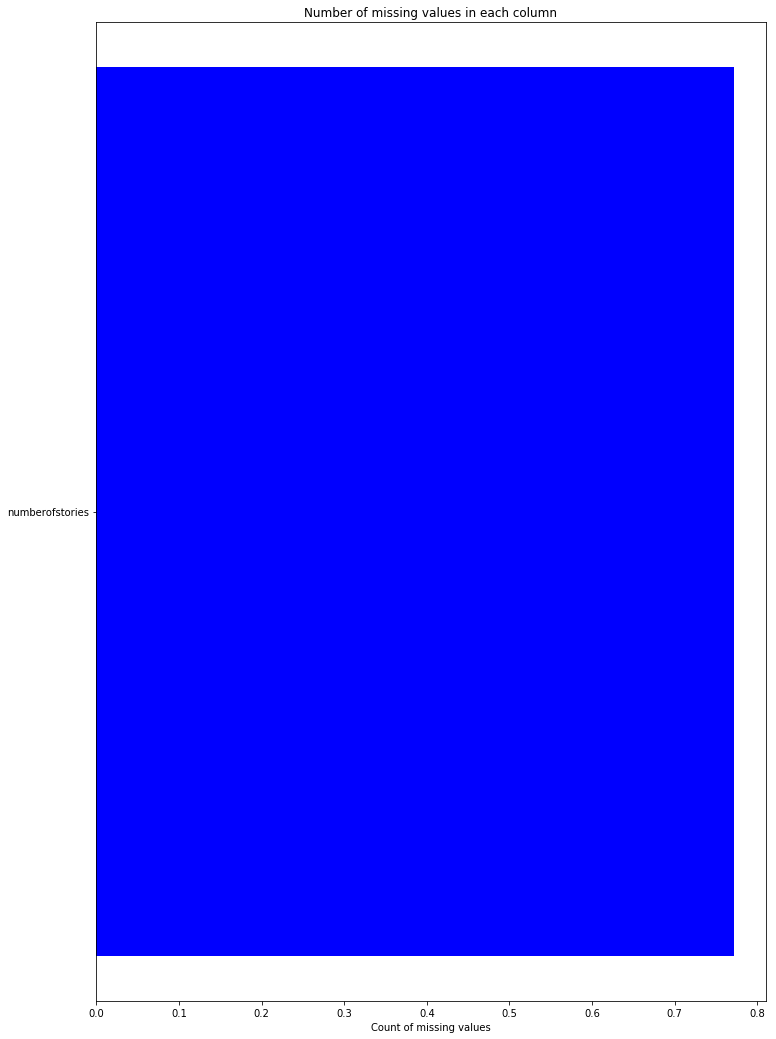

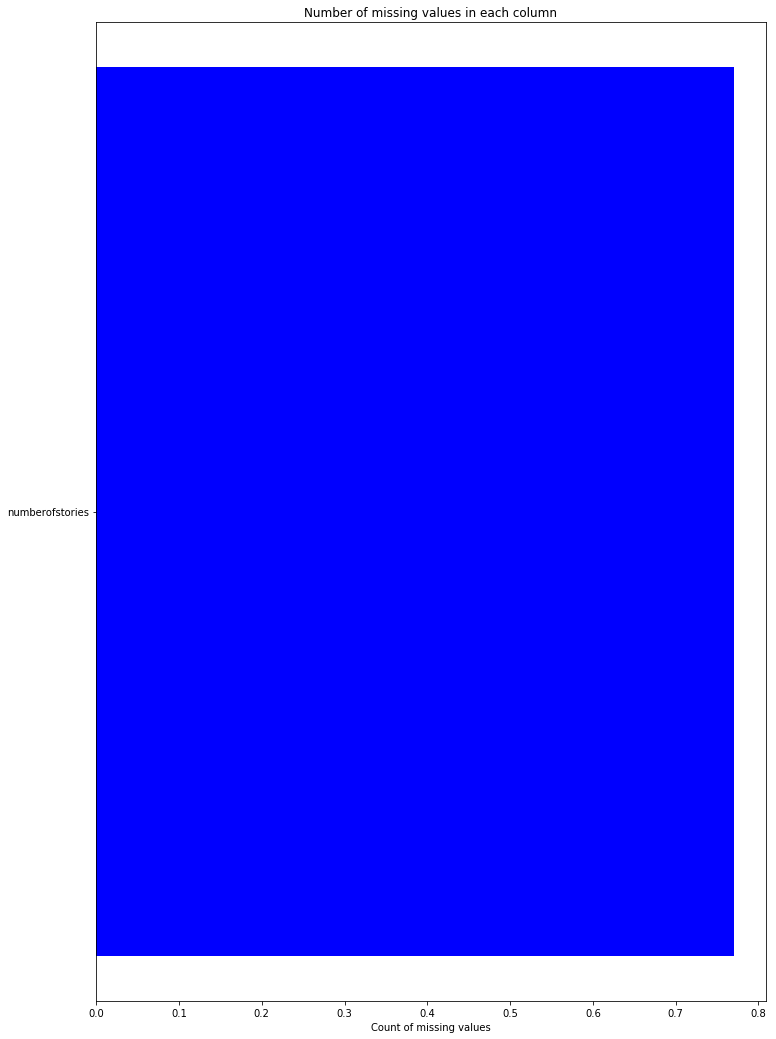

In [191]:
missing_2016_df = properties_2016_df.isnull().sum(axis=0).reset_index()
missing_2016_df.columns = ['column_name', 'missing_pct']
missing_2016_df = missing_2016_df.loc[missing_2016_df['missing_pct']>0]
missing_2016_df['missing_pct'] = missing_2016_df['missing_pct'] / length_properties_2016
missing_2016_df = missing_2016_df.sort_values(by='missing_pct')
ind = np.arange(missing_2016_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind, missing_2016_df.missing_pct.values, color='blue')
ax.set_yticks(ind)
ax.set_yticklabels(missing_2016_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")
plt.show()

missing_2017_df = properties_2017_df.isnull().sum(axis=0).reset_index()
missing_2017_df.columns = ['column_name', 'missing_pct']
missing_2017_df = missing_2017_df.loc[missing_2017_df['missing_pct']>0]
missing_2017_df['missing_pct'] = missing_2017_df['missing_pct'] / length_properties_2017
missing_2017_df = missing_2017_df.sort_values(by='missing_pct')
ind = np.arange(missing_2017_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind, missing_2017_df.missing_pct.values, color='blue')
ax.set_yticks(ind)
ax.set_yticklabels(missing_2017_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")
plt.show()

_THAT'S IT! ONE MORE! LET'S SAVE REAL QUICK!_

In [192]:
properties_2016_df.to_csv("Input/properties_2016_mod.csv", sep=',', encoding='utf-8', index=False)
properties_2017_df.to_csv("Input/properties_2017_mod.csv", sep=',', encoding='utf-8', index=False)

In [ ]:
logging.debug("READING IN 2016 PROPERTIES...")
properties_2016_df = pd.read_csv("Input/properties_2016_mod.csv")

logging.debug("READING IN 2017 PROPERTIES...")
properties_2017_df = pd.read_csv("Input/properties_2017_mod.csv")

DEBUG:root:[ nan   1.   4.   2.   3.  41.   5.   6.  20.   7.  14.  17.   8.]


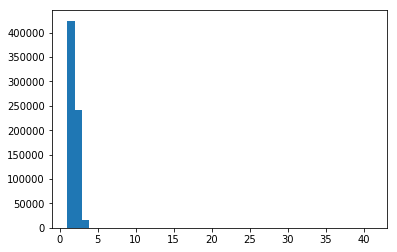

DEBUG:root:[ nan   1.   4.   2.   3.  41.   5.   6.  20.   7.  14.  17.   8.]


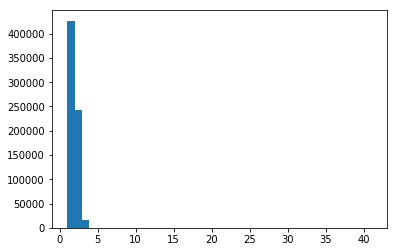

In [193]:
unique = properties_2016_df['numberofstories'].unique()
logging.debug(unique)

values = properties_2016_df[np.isfinite(properties_2016_df['numberofstories'])].numberofstories.values

plt.close()
plt.hist(values, bins=41)
plt.show()

unique = properties_2017_df['numberofstories'].unique()
logging.debug(unique)

values = properties_2017_df[np.isfinite(properties_2017_df['numberofstories'])].numberofstories.values

plt.close()
plt.hist(values, bins=41)
plt.show()

In [194]:
fillna_knn( df = properties_2017_df,
                  base = [ 'latitude', 'longitude' ] ,
                  target = 'numberofstories',
                  n_neighbors=3)

fillna_knn( df = properties_2016_df,
                  base = [ 'latitude', 'longitude' ] ,
                  target = 'numberofstories',
                  n_neighbors=3)

DEBUG:root:FITTING...
DEBUG:root:PREDICTING...
DEBUG:root:[ 2.  1.  1. ...,  2.  2.  1.]
DEBUG:root:2299541, 2299541
DEBUG:root:POPULATING...
DEBUG:root:FITTING...
DEBUG:root:PREDICTING...
DEBUG:root:[ 2.  1.  1. ...,  1.  1.  1.]
DEBUG:root:2303148, 2303148
DEBUG:root:POPULATING...


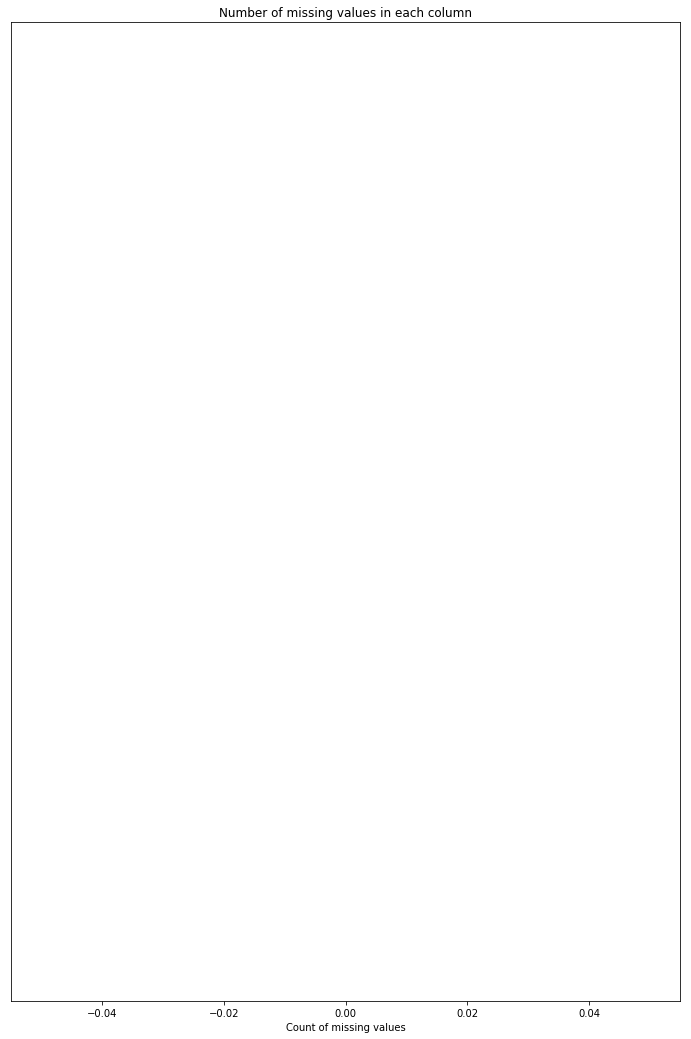

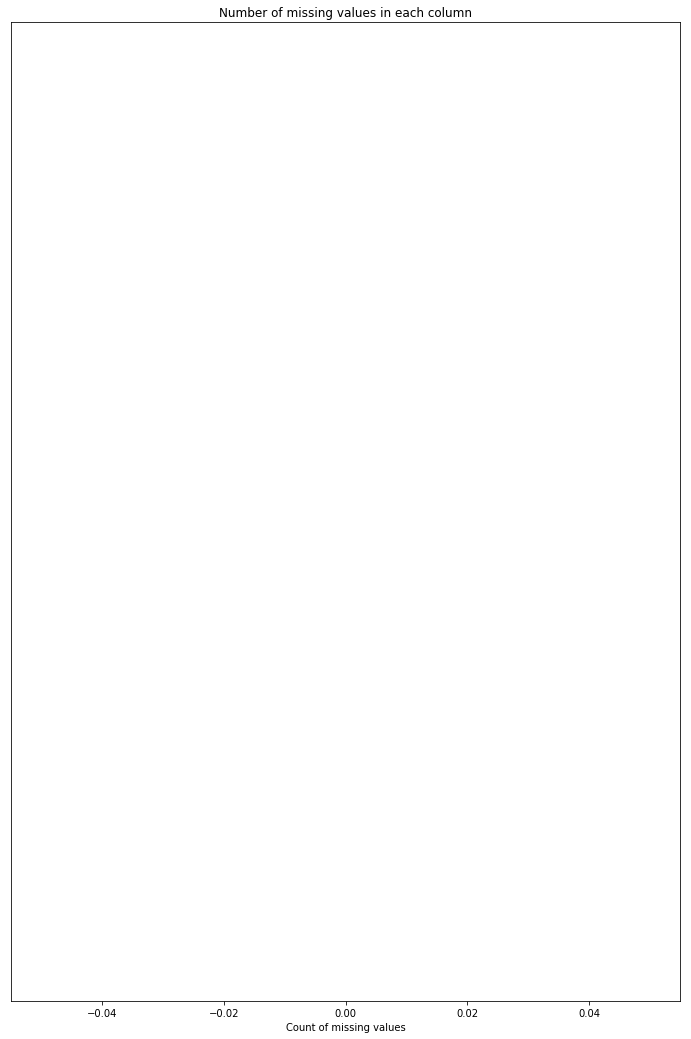

In [195]:
missing_2016_df = properties_2016_df.isnull().sum(axis=0).reset_index()
missing_2016_df.columns = ['column_name', 'missing_pct']
missing_2016_df = missing_2016_df.loc[missing_2016_df['missing_pct']>0]
missing_2016_df['missing_pct'] = missing_2016_df['missing_pct'] / length_properties_2016
missing_2016_df = missing_2016_df.sort_values(by='missing_pct')
ind = np.arange(missing_2016_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind, missing_2016_df.missing_pct.values, color='blue')
ax.set_yticks(ind)
ax.set_yticklabels(missing_2016_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")
plt.show()

missing_2017_df = properties_2017_df.isnull().sum(axis=0).reset_index()
missing_2017_df.columns = ['column_name', 'missing_pct']
missing_2017_df = missing_2017_df.loc[missing_2017_df['missing_pct']>0]
missing_2017_df['missing_pct'] = missing_2017_df['missing_pct'] / length_properties_2017
missing_2017_df = missing_2017_df.sort_values(by='missing_pct')
ind = np.arange(missing_2017_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind, missing_2017_df.missing_pct.values, color='blue')
ax.set_yticks(ind)
ax.set_yticklabels(missing_2017_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")
plt.show()

_THAT'S IT!! WE'VE IMPUTED ALL OF THE VALUES! NOW ALL WE HAVE TO DO IS SOME DUMMY ENCODING FOR A FEW VARIABLES!_

In [ ]:
properties_2016_df.to_csv("Input/properties_2016_mod.csv", sep=',', encoding='utf-8', index=False)
properties_2017_df.to_csv("Input/properties_2017_mod.csv", sep=',', encoding='utf-8', index=False)

In [196]:
del properties_2017_df['taxdelinquencyflag']
del properties_2016_df['taxdelinquencyflag']

In [197]:
cols = properties_2017_df.columns.tolist()

tp = []

for v in cols:
    tp.append(properties_2017_df[v].dtype)
    
    logging.debug("{}: {}".format(v, properties_2017_df[v].dtype))

DEBUG:root:parcelid: int64
DEBUG:root:basementsqft: float64
DEBUG:root:bathroomcnt: float64
DEBUG:root:bedroomcnt: float64
DEBUG:root:buildingclasstypeid: float64
DEBUG:root:calculatedfinishedsquarefeet: float64
DEBUG:root:finishedsquarefeet12: float64
DEBUG:root:fips: float64
DEBUG:root:fireplacecnt: float64
DEBUG:root:fullbathcnt: float64
DEBUG:root:garagecarcnt: float64
DEBUG:root:garagetotalsqft: float64
DEBUG:root:hashottuborspa: float64
DEBUG:root:latitude: float64
DEBUG:root:longitude: float64
DEBUG:root:lotsizesquarefeet: float64
DEBUG:root:poolsizesum: float64
DEBUG:root:propertycountylandusecode: object
DEBUG:root:propertylandusetypeid: float64
DEBUG:root:propertyzoningdesc: object
DEBUG:root:rawcensustractandblock: float64
DEBUG:root:regionidcity: float64
DEBUG:root:regionidcounty: float64
DEBUG:root:regionidneighborhood: float64
DEBUG:root:regionidzip: float64
DEBUG:root:threequarterbathnbr: float64
DEBUG:root:unitcnt: float64
DEBUG:root:yardbuildingsqft17: float64
DEBUG:ro

In [205]:
unique1 = set(properties_2017_df['propertycountylandusecode'].unique())
unique2 = set(properties_2016_df['propertycountylandusecode'].unique())

logging.debug(unique1-unique2)
logging.debug(unique2-unique1)

DEBUG:root:{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 91, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224

In [203]:
dictionary = {}
unique = list(unique2)

for i in range(len(unique)):
    properties_2016_df['propertycountylandusecode'] = properties_2016_df['propertycountylandusecode'].replace([unique[i]], i)
    properties_2017_df['propertycountylandusecode'] = properties_2017_df['propertycountylandusecode'].replace([unique[i]], i)



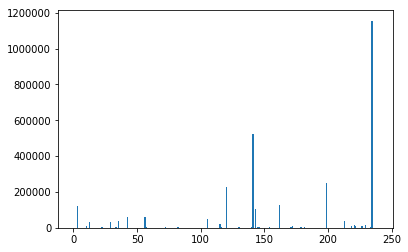

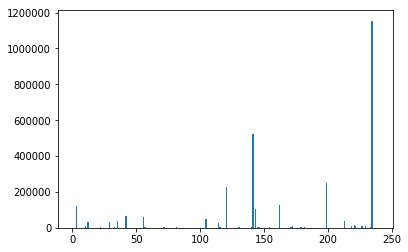

In [206]:
vals = properties_2016_df['propertycountylandusecode'].values

plt.close()
plt.hist(vals, bins=len(unique))
plt.show()

vals = properties_2017_df['propertycountylandusecode'].values

plt.close()
plt.hist(vals, bins=len(unique))
plt.show()

In [207]:
unique1 = set(properties_2017_df['propertyzoningdesc'].unique())
unique2 = set(properties_2016_df['propertyzoningdesc'].unique())

logging.debug(unique1-unique2)
logging.debug(unique2-unique1)

DEBUG:root:{'GLCI', 'RAS4', 'LALASED', 'HHR-A-S*', 'SPM1AY', 'SMC4', 'BFM1', 'LRMU', 'RPI-OH*', 'ARRM&D*', 'LARI-I*', 'GAAS', 'WCCR', 'LCMX-DRU', 'PDCP', 'CAML', 'LAR-1', 'CACG&D&ORL', 'LBPD13', 'GDR3_GRAND', 'CMM2', 'WCCR*', 'LCRAGOOO*', 'WHM2*', 'GLDSP/TD', 'LYCB'}
DEBUG:root:{'SHM2', 'CEM', 'GLC2', 'LVI-PR4.5D', 'POM1', 'TCM1', 'SGR3CM*', 'PRCG', 'DOC3', 'AZC4*', '0500', 'LRMU-N', 'DBC3'}


In [209]:
logging.debug("2017...")
unique = list(unique1 | unique2)
order = []

for i in range(len(unique)):
    if i%100 == 0:
        logging.debug("{:0.2f}% COMPLETE...".format(i*100/len(unique)))
    properties_2016_df['propertyzoningdesc'] = properties_2016_df['propertyzoningdesc'].replace([unique[i]], i)
    properties_2017_df['propertyzoningdesc'] = properties_2017_df['propertyzoningdesc'].replace([unique[i]], i)


DEBUG:root:2017...
DEBUG:root:0.00% COMPLETE...
DEBUG:root:1.77% COMPLETE...
DEBUG:root:3.53% COMPLETE...
DEBUG:root:5.30% COMPLETE...
DEBUG:root:7.06% COMPLETE...
DEBUG:root:8.83% COMPLETE...
DEBUG:root:10.59% COMPLETE...
DEBUG:root:12.36% COMPLETE...
DEBUG:root:14.12% COMPLETE...
DEBUG:root:15.89% COMPLETE...
DEBUG:root:17.66% COMPLETE...
DEBUG:root:19.42% COMPLETE...
DEBUG:root:21.19% COMPLETE...
DEBUG:root:22.95% COMPLETE...
DEBUG:root:24.72% COMPLETE...
DEBUG:root:26.48% COMPLETE...
DEBUG:root:28.25% COMPLETE...
DEBUG:root:30.01% COMPLETE...
DEBUG:root:31.78% COMPLETE...
DEBUG:root:33.55% COMPLETE...
DEBUG:root:35.31% COMPLETE...
DEBUG:root:37.08% COMPLETE...
DEBUG:root:38.84% COMPLETE...
DEBUG:root:40.61% COMPLETE...
DEBUG:root:42.37% COMPLETE...
DEBUG:root:44.14% COMPLETE...
DEBUG:root:45.90% COMPLETE...
DEBUG:root:47.67% COMPLETE...
DEBUG:root:49.44% COMPLETE...
DEBUG:root:51.20% COMPLETE...
DEBUG:root:52.97% COMPLETE...
DEBUG:root:54.73% COMPLETE...
DEBUG:root:56.50% COMPLETE.

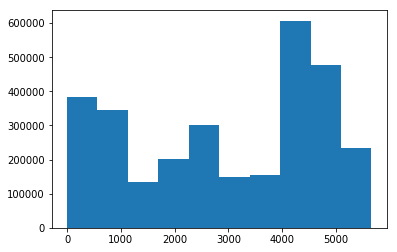

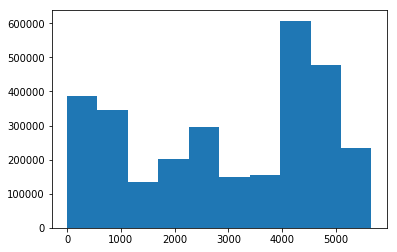

In [210]:
vals = properties_2016_df['propertyzoningdesc'].values

plt.close()
# plt.hist(vals, bins=unique.shape[0])
plt.hist(vals)
plt.show()

vals = properties_2017_df['propertyzoningdesc'].values

plt.close()
# plt.hist(vals, bins=unique.shape[0])
plt.hist(vals)
plt.show()

In [211]:
properties_2016_df.to_csv("Input/properties_2016_mod.csv", sep=',', encoding='utf-8', index=False)
properties_2017_df.to_csv("Input/properties_2017_mod.csv", sep=',', encoding='utf-8', index=False)